In [1]:
import torch
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3090'

In [2]:
import random
list1 = [[1,2],[3,4,5],[6,2],[7,2],[4,2]]
list_choice = random.sample(list1,3)
print(list_choice)

[[4, 2], [1, 2], [7, 2]]


In [3]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import random

import copy

from torch.utils.data import DataLoader, Dataset


from shufflenetv2 import*
from Lenet import*
from resnet import*
# from alex import*
# from vgg import*
# from mobilenet_v2_v2 import*

ShuffleNetV2(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): DownBlock(
      (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(88, 88, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=88, bias=False)
      (bn4): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(88, 88, k

In [4]:
# Parameters

data_set = 'cifar'

torch.manual_seed(0)
random.seed(1)
np.random.seed(1)

# iid = 'cifar_noniid'
iid = 0

gpu = 0

train_test_ratio = 1.0

num_clients =50

frac_C = 0.5

num_selecteds = int( num_clients * frac_C )

device = torch.device('cuda:{}'.format(gpu) if torch.cuda.is_available() and gpu != -1 else 'cpu')

epochs = 30

client_batch_size = 100

local_epochs = 3


agg_mode = 'global'

tolerance = 0

In [5]:
# Initialize

model_clientdict = {}

In [6]:
# Data Prep

if data_set =='mnist':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])

    train_data = datasets.MNIST(root='../dataset/mnist/',
                                train = True,
                                download = True,
                                transform = transform)

    test_data = datasets.MNIST(root='../dataset/mnist/', 
                               train = False,
                               download = True,
                               transform = transform)
elif data_set == 'cifar':
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


    train_data = datasets.CIFAR10(root='../dataset/cifar/', 
                                  train=True, 
                                  download=True, 
                                  transform=transform)

    test_data = datasets.CIFAR10(root='../dataset/cifar/', 
                                 train=False, 
                                 download=True, 
                                 transform=transform)
    
def sampling_iid(dataset, num_clients):

    datanum_per_client = int(len(dataset)/num_clients)
    client_dataidx_dict = {}
    temp_dict = [i for i in range(len(dataset))]
    for i in range(num_clients):
        client_dataidx_dict[i] = set(np.random.choice(temp_dict, datanum_per_client, replace=False))
        temp_dict = list(set(temp_dict) - client_dataidx_dict[i])
    return client_dataidx_dict

def sampling_noniid(dataset, num_clients):

    avgnum_per_client = int(len(dataset)/num_clients)
    client_dataidx_dict = {}
    temp_dict = [i for i in range(len(dataset))]
    for i in range(num_clients):
        client_dataidx_dict[i] = set(np.random.choice(temp_dict, random.randint(50,1130), replace=False))
        temp_dict = list(set(temp_dict) - client_dataidx_dict[i])
    return client_dataidx_dict

def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    idxs = idxs_labels[0,:]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate((dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

def cifar_noniid(dataset,num_users):
    
    num_items = int(len(dataset))
    dict_users = {}
    labels = [i for i in range(10)]
    idx = {i: np.array([], dtype='int64') for i in range(10) }
    
    j = 0
    # print((dataset[0][0]))
    for i in dataset:
        # print(i)
        idx[i[1]] = np.append(idx[i[1]],j)
        j += 1
        
    # if(num_users<=5):
    #     k = int(10/num_users)
    #     for i in range(num_users):
    #         a = 0
    #         for j in range(i*k,(i+1)*k):
    #             a += j
    #             if(j==i*k):
    #                 dict_users[i] = list(idx[j])
    #             else:
    #                 dict_users[i] = np.append(dict_users[i],idx[j])
    #         print(a)
    #     return dict_users
    

    # if k = 4, a particular user can have samples only from at max 4 classes
    k = 4
    # print(idx)
    num_examples = int(num_items/(k*num_users))
    
    for i in range(num_users):
        t = 0
        while(t!=k):
            j = random.randint(0,9)
            
            if (len(idx[(i+j)%len(labels)]) >= num_examples):
                rand_set = set(np.random.choice(idx[(i+j)%len(labels)], num_examples, replace=False))
                idx[(i+j)%len(labels)] = list(set(idx[(i+j)%len(labels)]) - rand_set)
                rand_set = list(rand_set)
                if(t==0):
                    dict_users[i] = rand_set
                else:
                    dict_users[i] = np.append(dict_users[i],rand_set)
                t += 1
    return dict_users


class Client_Dataset(Dataset):

    def __init__(self, dataset, idx):

        self.dataset = dataset
        self.idx = list(idx)

    def __len__(self):

        return len(self.idx)

    def __getitem__(self, item):

        inputs, targets = self.dataset[self.idx[item]]
        return inputs, targets

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Main


if iid == 0:
    client_dataidx_dict = sampling_iid(train_data, num_clients)
elif iid == 1:
    client_dataidx_dict = sampling_noniid(train_data, num_clients)
elif iid == 'cifar_noniid':
    client_dataidx_dict = cifar_noniid(train_data, num_clients)
elif iid == 'cifar_noniid_aligned':
    client_dataidx_dict = cifar_noniid_aligned(train_data,num_clients)
else:
    client_dataidx_dict = mnist_noniid(train_data, num_clients)


client_traindataidx_dict = {}
client_testdataidx_dict = {}

for i in range(num_clients):

    client_dataidx_dict[i] = list(client_dataidx_dict[i])

    client_traindataidx_dict[i] = list(random.sample(client_dataidx_dict[i],int(train_test_ratio*len(client_dataidx_dict[i]))))

    client_testdataidx_dict[i] = list(set(client_dataidx_dict[i])-set(client_traindataidx_dict[i]))

for i in range(0,num_clients):
    # model_clientdict[i] = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
#     model_clientdict[i] = [Lenet().to(device)]
#     model_clientdict[i] = [ResNet18().to(device)]
    # model_clientdict[i] = [VGG('VGG16').to(device)]
    # model_clientdict[i] = [AlexNet().to(device)]
    model_clientdict[i] = [ShuffleNetV2(net_size=1.5).to(device)]
    # model_clientdict[i] = [MobileNetV2(10, alpha = 1).to(device)]    
    model_clientdict[i][0].train()

model_ensemble_temp = ShuffleNetV2(net_size=1.5).to(device)
model_ensemble_temp.train()
#criterion 

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)ƒ

# train

def client_train(epoch, dataset, data_idx, model):
    
    # global batch_momentum

    data_idx = list(data_idx)

    criterion = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(Client_Dataset(dataset, data_idx), batch_size=client_batch_size, shuffle=True)



    model.train()



    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
    # optimizer = optim.Adam(model.parameters())

    
    
    # batch_momentum = 1.0

    print(batch_momentum,'momentum')
    for local_epoch in range(local_epochs): 
        loss_show = 0.0
        for batch_idx,(inputs,target) in enumerate(train_loader,0):

            # temp = 0
            # for name, layer  in (model.named_modules()):
            #     if 'bn' in name and temp<corresponding_breakpoint:
            #         layer.momentum =batch_momentum
            #     temp += 1


            # if batch_idx > 0 and flag == True:
            #     batch_momentum -= 0.001
            #     if batch_momentum < 0.1:
            #         batch_momentum = 0.1

            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            loss_show += loss.item()
            lossavg = loss_show/(batch_idx+1)
        # print('train_local_epoch:',local_epoch)            
        # print ('loss:',loss_show)

    return model.state_dict(),lossavg

def client_test(epoch, dataset, data_idx, model):

    test_loader = DataLoader(Client_Dataset(dataset, data_idx), batch_size=client_batch_size, shuffle=False)
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_show = 0.0
        for batch_idx,(inputs,target) in enumerate(test_loader,0):
            inputs,target = inputs.to(device),target.to(device)
            outputs = model(inputs)
            loss_test = criterion(outputs,target).item()
            loss_show += loss_test
            lossavg = loss_show/(batch_idx+1)
            
            temp, predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        acc = (correct/total)
    print('acc: ', acc)

    return acc, lossavg


def globle_agg(w):
    w_avg = copy.deepcopy(w[0])
    for i in w_avg.keys():
        for j in range(1,len(w)):
#             copy_temp = copy.deepcopy(w[j][i])
            copy_temp = w[j][i]
            w_avg[i] += copy_temp
        w_avg[i] = torch.div(w_avg[i],len(w))
    return w_avg

def test(model, dataset, batch_size):
    model.eval()

    dataloader = DataLoader(dataset, batch_size = batch_size)
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_show = 0.0
        for batch_idx,(inputs,target) in enumerate(dataloader,0) :
            inputs,target = inputs.to(device),target.to(device)
            outputs = model(inputs)
            temp, predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            loss_test = criterion(outputs,target).item()
            loss_show += loss_test
            lossavg = loss_show/(batch_idx+1)
        acc = (correct/total)
    print('acc_test: ', acc)
    return  acc, lossavg 


def test_ensemble(models, dataset, batch_size):
    

    dataloader = DataLoader(dataset, batch_size = batch_size)
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_show = 0.0
        
        
        for batch_idx,(inputs,target) in enumerate(dataloader,0) :
            count = 0
            for model_id in models:
                model_ensemble_temp.load_state_dict(model_id)
                model_ensemble_temp.eval()
                inputs,target = inputs.to(device),target.to(device)
                
                if count == 0:
                    outputs = model_ensemble_temp(inputs)
                else:
                    outputs += model_ensemble_temp(inputs)
                count += 1

            temp, predicted = torch.max(outputs.data, dim = 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            # loss_test = criterion(outputs,target).item()
            # loss_show += loss_test
            # lossavg = loss_show/(batch_idx+1)
        acc = (correct/total)
    print('acc_ensemble: ', acc)
    # return  acc, lossavg
    return  acc





# main()

acc_log = []
loss_log = []

acc_clients_log = [[] for i in range(num_clients)]
loss_clients_log = [[] for i in range(num_clients)]
acc_ensemble = []
# acc_client = [1.0 for i in range(num_clients)]
w_clients = [[i[0].state_dict()] for i in model_clientdict.values()]

# global_model = CNNCifar().to(device)
# global_model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
# global_model = LeNet().to(device)
# global_model = ShuffleNetV2(net_size=1.5).to(device)
# global_model = MobileNetV2(10, alpha = 1).to(device)


# global_model.train()

# w_glob = global_model.state_dict()

# w_glob_original = global_model.state_dict()



counter = 0
flag = False
batch_momentum = 1.0

for epoch in range(400):


    
    print('Epoch {} start'.format(epoch))

    loss_clients, acc_sum, acc_sum_1, acc_sum_2,loss_sum = [], 0 , 0, 0, 0










    for client_idx in range(0,num_clients):

        w_temp = []

        drop = False

        now_rd = len(w_clients[client_idx])-1

        if now_rd >= epochs:
            drop = True

        if client_idx<10:
            if random.random()<0.8:
                drop = True
        elif client_idx >= 10 and client_idx<40:
            if random.random()<0.5:
                drop = True
        else:
            if random.random()<0.2:
                drop = True  
                
#         if now_rd >= epochs:
#             drop = True

#         if client_idx<20:
#             if random.random()<0.8:
#                 drop = True
#         elif client_idx >= 20 and client_idx<80:
#             if random.random()<0.5:
#                 drop = True
#         else:
#             if random.random()<0.2:
#                 drop = True  

#         if  client_idx<20:
#             if epoch%2 == 0 or epoch%3 == 0 :
#                 drop = True
#         elif  client_idx >= 20 and client_idx<80:
#             if epoch%3 == 0:
#                 drop = True
#         else:
#             if epoch%6 == 0:
#                 drop = True        
        
        print('drop = ',drop)
        if drop == False:

 
            for i in w_clients:

                counter = 0
                for j in i:

                    # if counter <= (now_rd +  tolerance) and counter >= (now_rd - tolerance):
                    if counter == now_rd:
                        w_temp.append(j)
                    counter += 1
 
            print('len,w_temp',len(w_temp))

            if len(w_temp) >= num_selecteds:

#                 w_select = random.sample(w_temp,num_selecteds)
                w_select = w_temp

                w_agg = globle_agg(w_select)

                model_clientdict[client_idx][0].load_state_dict(w_agg)
                print('epoch:',epoch,'client:', client_idx,'now_rd:',now_rd)
                
                acc,loss_ = test( model_clientdict[client_idx][0], test_data, client_batch_size)

                w,loss_train = client_train(epoch, train_data, client_traindataidx_dict[client_idx], model = model_clientdict[client_idx][0])
                

                w_clients[client_idx].append (copy.deepcopy(w))
                
#                 w_clients[client_idx].append (w)

               

                acc_clients_log[client_idx].append(acc)

                loss_clients_log[client_idx].append(loss_)

                # acc_client[client_idx] = acc

                acc_sum += acc

                loss_sum += loss_
                # loss_sum += loss_train

    # if epoch < epochs:
    #     w_ensemble = []
    #     ensemble_rd = epoch
    #     for i in w_clients:
    #         counter = 0
    #         for j in i:
    #             # if counter <= (now_rd +  tolerance) and counter >= (now_rd - tolerance):
    #             if counter == ensemble_rd:
    #                 w_ensemble.append(j)
    #             counter += 1
    #     acc = test_ensemble( w_ensemble, test_data, client_batch_size)
    #     acc_ensemble.append(acc)

w_ensemble = []
ensemble_rd = epochs - 1
for i in w_clients:
    counter = 0
    for j in i:
        # if counter <= (now_rd +  tolerance) and counter >= (now_rd - tolerance):
        if counter == ensemble_rd:
            w_ensemble.append(j)
        counter += 1
acc = test_ensemble( w_ensemble, test_data, client_batch_size)



            # print('agg_mode = global,','agg_before:',agg_before)

            # for client_idx in range(0,num_clients):

            #     for i in list(w_clients[client_idx][-1].keys())[0:agg_before]:
            #         if 'bn' not in i:
            #             w_clients[client_idx][-1][i] = copy.deepcopy(w_glob[i])
            #     model_clientdict[client_idx][0].load_state_dict(w_clients[client_idx][-1])



    # glob_acc = test(global_model, test_data, client_batch_size)
    # globacc_log.append(glob_acc)




  


    # for client_idx in range(num_clients):
        # if acc_client[client_idx] < acc_client_lastepoch[client_idx]:
            # w_clients[client_idx] = w_clients_lastepoch[client_idx]
            # model_clientdict[client_idx].load_state_dict(w_clients[client_idx])















print(acc_log)
print(loss_log)
print(acc_clients_log)
print(loss_clients_log)
print(acc_ensemble)




Epoch 0 start
drop =  False
len,w_temp 50
epoch: 0 client: 0 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 2 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 7 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 9 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 50
epoch: 0 client: 10 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 50
epoch: 0 client: 11 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 13 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 16 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 18 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 0 client: 20 now_rd: 0
acc_test:  0.1


drop =  False
len,w_temp 45
epoch: 3 client: 23 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 30
epoch: 3 client: 24 now_rd: 2
acc_test:  0.1007
1.0 momentum
drop =  False
len,w_temp 30
epoch: 3 client: 25 now_rd: 2
acc_test:  0.1007
1.0 momentum
drop =  False
len,w_temp 45
epoch: 3 client: 26 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 50
epoch: 3 client: 27 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 46
epoch: 3 client: 29 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 46
epoch: 3 client: 30 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 33
epoch: 3 client: 31 now_rd: 2
acc_test:  0.1004
1.0 momentum
drop =  False
len,w_temp 46
epoch: 3 client: 32 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  False
len,w_temp 46
epoch: 3 client: 33 now_rd: 1
acc_test:  0.1
1.0 momentum
drop =  True
drop =  False
len,w_temp 50
epoch: 3 client: 35 now_rd: 0
acc_test:  0.1
1.0 momentum
drop =  False
len,w

acc_test:  0.4697
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 23
drop =  False
len,w_temp 23
drop =  True
drop =  False
len,w_temp 23
drop =  True
drop =  False
len,w_temp 36
epoch: 7 client: 28 now_rd: 3
acc_test:  0.4749
1.0 momentum
drop =  True
drop =  False
len,w_temp 44
epoch: 7 client: 30 now_rd: 2
acc_test:  0.4046
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 37
epoch: 7 client: 33 now_rd: 3
acc_test:  0.4788
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 37
epoch: 7 client: 38 now_rd: 3
acc_test:  0.4828
1.0 momentum
drop =  False
len,w_temp 37
epoch: 7 client: 39 now_rd: 3
acc_test:  0.4916
1.0 momentum
drop =  False
len,w_temp 27
epoch: 7 client: 40 now_rd: 4
acc_test:  0.512
1.0 momentum
drop =  False
len,w_temp 37
epoch: 7 client: 41 now_rd: 3
acc_test:  0.4984
1.0 momentum
drop =  False
len,w_temp 28
epoch: 7 client: 42 now_rd: 4
acc_test:  0.5186
1.0 momentum
drop 

acc_test:  0.1032
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 30
epoch: 11 client: 13 now_rd: 5
acc_test:  0.5833
1.0 momentum
drop =  True
drop =  False
len,w_temp 37
epoch: 11 client: 15 now_rd: 4
acc_test:  0.5812
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 17
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 31
epoch: 11 client: 23 now_rd: 5
acc_test:  0.5869
1.0 momentum
drop =  False
len,w_temp 18
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 44
epoch: 11 client: 29 now_rd: 3
acc_test:  0.5695
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 38
epoch: 11 client: 33 now_rd: 4
acc_test:  0.5841
1.0 momentum
drop =  False
len,w_temp 18
drop =  True
drop =  False
len,w_temp 44
epoch: 11 client: 36 now_rd: 3
acc_test:  0.5733
1.0 momentum
drop =  False
len,w_temp 32
epoch: 11 client: 

acc_test:  0.6115
1.0 momentum
drop =  False
len,w_temp 49
epoch: 15 client: 17 now_rd: 2
acc_test:  0.615
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 21
drop =  False
len,w_temp 44
epoch: 15 client: 21 now_rd: 4
acc_test:  0.6145
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 21
drop =  False
len,w_temp 35
epoch: 15 client: 25 now_rd: 6
acc_test:  0.6139
1.0 momentum
drop =  True
drop =  False
len,w_temp 42
epoch: 15 client: 27 now_rd: 5
acc_test:  0.615
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 36
epoch: 15 client: 30 now_rd: 6
acc_test:  0.6168
1.0 momentum
drop =  True
drop =  False
len,w_temp 23
drop =  False
len,w_temp 36
epoch: 15 client: 33 now_rd: 6
acc_test:  0.6157
1.0 momentum
drop =  False
len,w_temp 24
drop =  False
len,w_temp 47
epoch: 15 client: 35 now_rd: 3
acc_test:  0.6148
1.0 momentum
drop =  False
len,w_temp 45
epoch: 15 client: 36 now_rd: 4
acc_test:  0.6161
1.0 momentum
drop =  True
drop =  True
drop =  F

acc_test:  0.6378
1.0 momentum
Epoch 19 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 43
epoch: 19 client: 8 now_rd: 6
acc_test:  0.6356
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 45
epoch: 19 client: 14 now_rd: 5
acc_test:  0.6362
1.0 momentum
drop =  False
len,w_temp 44
epoch: 19 client: 15 now_rd: 6
acc_test:  0.6364
1.0 momentum
drop =  False
len,w_temp 28
epoch: 19 client: 16 now_rd: 8
acc_test:  0.6383
1.0 momentum
drop =  True
drop =  False
len,w_temp 28
epoch: 19 client: 18 now_rd: 8
acc_test:  0.637
1.0 momentum
drop =  True
drop =  False
len,w_temp 28
epoch: 19 client: 20 now_rd: 8
acc_test:  0.6379
1.0 momentum
drop =  False
len,w_temp 45
epoch: 19 client: 21 now_rd: 5
acc_test:  0.6382
1.0 momentum
drop =  False
len,w_temp 28
epoch: 19 client: 22 now_rd: 8
acc_test:  0.6376
1.0 momentum
drop =  False
len,w_temp 28
epoch: 19 cli

drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 21
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 39
epoch: 23 client: 19 now_rd: 8
acc_test:  0.6592
1.0 momentum
drop =  False
len,w_temp 32
epoch: 23 client: 20 now_rd: 9
acc_test:  0.6612
1.0 momentum
drop =  False
len,w_temp 39
epoch: 23 client: 21 now_rd: 8
acc_test:  0.6615
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 33
epoch: 23 client: 24 now_rd: 9
acc_test:  0.6635
1.0 momentum
drop =  True
drop =  False
len,w_temp 33
epoch: 23 client: 26 now_rd: 9
acc_test:  0.6628
1.0 momentum
drop =  False
len,w_temp 24
drop =  False
len,w_temp 33
epoch: 23 client: 28 now_rd: 9
acc_test:  0.6623
1.0 momentum
drop =  False
len,w_temp 25
epoch: 23 client: 29 now_rd: 10
acc_test:  0.6636
1.0 momentum
drop =  True
drop =  False
len,w_temp 39
epoch: 23 client: 31 now_rd: 8
acc_test:  0.6611
1.0 momentum
drop =  True
drop =  False
len,w_temp 25
epoch: 23 client: 33 now_rd: 10
acc_tes

acc_test:  0.6721
1.0 momentum
drop =  False
len,w_temp 35
epoch: 26 client: 34 now_rd: 10
acc_test:  0.6752
1.0 momentum
drop =  False
len,w_temp 13
drop =  False
len,w_temp 31
epoch: 26 client: 36 now_rd: 11
acc_test:  0.6742
1.0 momentum
drop =  False
len,w_temp 38
epoch: 26 client: 37 now_rd: 9
acc_test:  0.6755
1.0 momentum
drop =  True
drop =  False
len,w_temp 14
drop =  False
len,w_temp 14
drop =  False
len,w_temp 31
epoch: 26 client: 41 now_rd: 11
acc_test:  0.6729
1.0 momentum
drop =  False
len,w_temp 31
epoch: 26 client: 42 now_rd: 11
acc_test:  0.6743
1.0 momentum
drop =  False
len,w_temp 16
drop =  False
len,w_temp 16
drop =  False
len,w_temp 16
drop =  True
drop =  False
len,w_temp 16
drop =  True
drop =  False
len,w_temp 31
epoch: 26 client: 49 now_rd: 11
acc_test:  0.6719
1.0 momentum
Epoch 27 start
drop =  False
len,w_temp 42
epoch: 27 client: 0 now_rd: 8
acc_test:  0.6756
1.0 momentum
drop =  False
len,w_temp 45
epoch: 27 client: 1 now_rd: 7
acc_test:  0.6746
1.0 momen

acc_test:  0.6882
1.0 momentum
drop =  False
len,w_temp 23
drop =  False
len,w_temp 37
epoch: 30 client: 34 now_rd: 11
acc_test:  0.687
1.0 momentum
drop =  False
len,w_temp 23
drop =  True
drop =  False
len,w_temp 35
epoch: 30 client: 37 now_rd: 12
acc_test:  0.6871
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 24
drop =  True
drop =  True
drop =  False
len,w_temp 24
drop =  True
drop =  False
len,w_temp 24
drop =  False
len,w_temp 24
drop =  False
len,w_temp 24
drop =  True
drop =  False
len,w_temp 24
Epoch 31 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 35
epoch: 31 client: 10 now_rd: 12
acc_test:  0.6863
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 25
epoch: 31 client: 13 now_rd: 13
acc_test:  0.6894
1.0 momentum
drop =  False
len,w_temp 25
epoch: 31 client: 14 now_rd: 13
acc_test:  0.6903
1.0 momentum
drop =  True
drop =  True
dro

acc_test:  0.6986
1.0 momentum
drop =  False
len,w_temp 34
epoch: 34 client: 33 now_rd: 13
acc_test:  0.6999
1.0 momentum
drop =  False
len,w_temp 29
epoch: 34 client: 34 now_rd: 14
acc_test:  0.703
1.0 momentum
drop =  False
len,w_temp 16
drop =  False
len,w_temp 29
epoch: 34 client: 36 now_rd: 14
acc_test:  0.7033
1.0 momentum
drop =  True
drop =  False
len,w_temp 34
epoch: 34 client: 38 now_rd: 13
acc_test:  0.7037
1.0 momentum
drop =  False
len,w_temp 34
epoch: 34 client: 39 now_rd: 13
acc_test:  0.703
1.0 momentum
drop =  False
len,w_temp 31
epoch: 34 client: 40 now_rd: 14
acc_test:  0.7052
1.0 momentum
drop =  False
len,w_temp 18
drop =  False
len,w_temp 31
epoch: 34 client: 42 now_rd: 14
acc_test:  0.707
1.0 momentum
drop =  True
drop =  False
len,w_temp 31
epoch: 34 client: 44 now_rd: 14
acc_test:  0.7078
1.0 momentum
drop =  False
len,w_temp 31
epoch: 34 client: 45 now_rd: 14
acc_test:  0.7074
1.0 momentum
drop =  False
len,w_temp 21
drop =  False
len,w_temp 31
epoch: 34 clien

acc_test:  0.7115
1.0 momentum
drop =  False
len,w_temp 31
epoch: 38 client: 18 now_rd: 15
acc_test:  0.712
1.0 momentum
drop =  True
drop =  False
len,w_temp 36
epoch: 38 client: 20 now_rd: 14
acc_test:  0.7114
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 36
epoch: 38 client: 23 now_rd: 14
acc_test:  0.7111
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 29
epoch: 38 client: 27 now_rd: 16
acc_test:  0.711
1.0 momentum
drop =  False
len,w_temp 29
epoch: 38 client: 28 now_rd: 16
acc_test:  0.7112
1.0 momentum
drop =  False
len,w_temp 29
epoch: 38 client: 29 now_rd: 16
acc_test:  0.7108
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 29
epoch: 38 client: 33 now_rd: 16
acc_test:  0.7112
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 29
epoch: 38 client: 36 now_rd: 16
acc_test:  0.7107
1.0 momentum
drop =  True
drop =  False
len,w_temp 29
epoch: 38 client: 38 now_rd: 16
acc_test:  0.7127
1.0 momen

drop =  False
len,w_temp 26
epoch: 41 client: 41 now_rd: 18
acc_test:  0.7148
1.0 momentum
drop =  False
len,w_temp 26
epoch: 41 client: 42 now_rd: 18
acc_test:  0.7155
1.0 momentum
drop =  False
len,w_temp 32
epoch: 41 client: 43 now_rd: 17
acc_test:  0.7164
1.0 momentum
drop =  True
drop =  False
len,w_temp 32
epoch: 41 client: 45 now_rd: 17
acc_test:  0.7163
1.0 momentum
drop =  False
len,w_temp 28
epoch: 41 client: 46 now_rd: 18
acc_test:  0.7165
1.0 momentum
drop =  False
len,w_temp 28
epoch: 41 client: 47 now_rd: 18
acc_test:  0.7166
1.0 momentum
drop =  False
len,w_temp 28
epoch: 41 client: 48 now_rd: 18
acc_test:  0.7156
1.0 momentum
drop =  True
Epoch 42 start
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 49
epoch: 42 client: 3 now_rd: 5
acc_test:  0.713
1.0 momentum
drop =  True
drop =  False
len,w_temp 46
epoch: 42 client: 5 now_rd: 8
acc_test:  0.7166
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 28
epoch: 42 cli

acc_test:  0.7186
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 38
epoch: 45 client: 17 now_rd: 16
acc_test:  0.7218
1.0 momentum
drop =  False
len,w_temp 28
epoch: 45 client: 18 now_rd: 19
acc_test:  0.7189
1.0 momentum
drop =  False
len,w_temp 38
epoch: 45 client: 19 now_rd: 16
acc_test:  0.7226
1.0 momentum
drop =  False
len,w_temp 33
epoch: 45 client: 20 now_rd: 18
acc_test:  0.7194
1.0 momentum
drop =  True
drop =  False
len,w_temp 21
drop =  True
drop =  False
len,w_temp 38
epoch: 45 client: 24 now_rd: 16
acc_test:  0.7203
1.0 momentum
drop =  True
drop =  False
len,w_temp 29
epoch: 45 client: 26 now_rd: 19
acc_test:  0.7197
1.0 momentum
drop =  False
len,w_temp 29
epoch: 45 client: 27 now_rd: 19
acc_test:  0.7183
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 23
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 23
drop =  False
len,w_temp 23
drop =  True
drop =  False
len,w_temp 33
epoch: 45 client: 37 no

acc_test:  0.7179
1.0 momentum
drop =  True
drop =  False
len,w_temp 28
epoch: 49 client: 14 now_rd: 21
acc_test:  0.716
1.0 momentum
drop =  False
len,w_temp 34
epoch: 49 client: 15 now_rd: 19
acc_test:  0.7199
1.0 momentum
drop =  False
len,w_temp 28
epoch: 49 client: 16 now_rd: 21
acc_test:  0.7166
1.0 momentum
drop =  True
drop =  False
len,w_temp 28
epoch: 49 client: 18 now_rd: 21
acc_test:  0.717
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 38
epoch: 49 client: 21 now_rd: 17
acc_test:  0.7227
1.0 momentum
drop =  False
len,w_temp 28
epoch: 49 client: 22 now_rd: 21
acc_test:  0.7161
1.0 momentum
drop =  False
len,w_temp 32
epoch: 49 client: 23 now_rd: 20
acc_test:  0.719
1.0 momentum
drop =  False
len,w_temp 37
epoch: 49 client: 24 now_rd: 18
acc_test:  0.7219
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 29
epoch: 49 client: 28 now_rd: 21
acc_test:  0.7167
1.0 momentum
drop =  False
len,w_temp 29
epoch: 49 client: 29 now_rd: 21
ac

drop =  True
drop =  False
len,w_temp 24
drop =  False
len,w_temp 31
epoch: 52 client: 38 now_rd: 22
acc_test:  0.7137
1.0 momentum
drop =  True
drop =  False
len,w_temp 25
epoch: 52 client: 40 now_rd: 23
acc_test:  0.7124
1.0 momentum
drop =  True
drop =  False
len,w_temp 31
epoch: 52 client: 42 now_rd: 22
acc_test:  0.7136
1.0 momentum
drop =  False
len,w_temp 26
epoch: 52 client: 43 now_rd: 23
acc_test:  0.7116
1.0 momentum
drop =  False
len,w_temp 26
epoch: 52 client: 44 now_rd: 23
acc_test:  0.7125
1.0 momentum
drop =  False
len,w_temp 26
epoch: 52 client: 45 now_rd: 23
acc_test:  0.7129
1.0 momentum
drop =  False
len,w_temp 26
epoch: 52 client: 46 now_rd: 23
acc_test:  0.7139
1.0 momentum
drop =  True
drop =  False
len,w_temp 26
epoch: 52 client: 48 now_rd: 23
acc_test:  0.7148
1.0 momentum
drop =  False
len,w_temp 31
epoch: 52 client: 49 now_rd: 22
acc_test:  0.7146
1.0 momentum
Epoch 53 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  

acc_test:  0.7173
1.0 momentum
Epoch 56 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 46
epoch: 56 client: 6 now_rd: 11
acc_test:  0.7215
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 30
epoch: 56 client: 10 now_rd: 24
acc_test:  0.7173
1.0 momentum
drop =  False
len,w_temp 38
epoch: 56 client: 11 now_rd: 20
acc_test:  0.7231
1.0 momentum
drop =  False
len,w_temp 30
epoch: 56 client: 12 now_rd: 24
acc_test:  0.7177
1.0 momentum
drop =  True
drop =  False
len,w_temp 30
epoch: 56 client: 14 now_rd: 24
acc_test:  0.7171
1.0 momentum
drop =  False
len,w_temp 34
epoch: 56 client: 15 now_rd: 23
acc_test:  0.7192
1.0 momentum
drop =  False
len,w_temp 17
drop =  False
len,w_temp 41
epoch: 56 client: 17 now_rd: 19
acc_test:  0.7189
1.0 momentum
drop =  True
drop =  False
len,w_temp 36
epoch: 56 client: 19 now_rd: 22
acc_test:  0.7235
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 31
ep

drop =  True
drop =  False
len,w_temp 28
epoch: 59 client: 42 now_rd: 26
acc_test:  0.7202
1.0 momentum
drop =  False
len,w_temp 28
epoch: 59 client: 43 now_rd: 26
acc_test:  0.7206
1.0 momentum
drop =  False
len,w_temp 28
epoch: 59 client: 44 now_rd: 26
acc_test:  0.7198
1.0 momentum
drop =  False
len,w_temp 28
epoch: 59 client: 45 now_rd: 26
acc_test:  0.7196
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 28
epoch: 59 client: 48 now_rd: 26
acc_test:  0.7198
1.0 momentum
drop =  False
len,w_temp 28
epoch: 59 client: 49 now_rd: 26
acc_test:  0.7192
1.0 momentum
Epoch 60 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 47
epoch: 60 client: 7 now_rd: 11
acc_test:  0.7189
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 28
epoch: 60 client: 10 now_rd: 26
acc_test:  0.7194
1.0 momentum
drop =  False
len,w_temp 37
epoch: 60 client: 11 now_rd: 22
acc_test:  0.7231
1.0 momentum
drop =  Tru

acc_test:  0.7182
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 40
epoch: 63 client: 32 now_rd: 21
acc_test:  0.7235
1.0 momentum
drop =  False
len,w_temp 22
drop =  True
drop =  True
drop =  False
len,w_temp 22
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  True
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  False
len,w_temp 22
drop =  True
Epoch 64 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 48
epoch: 64 client: 4 now_rd: 9
acc_test:  0.7195
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 22
drop =  False
len,w_temp 38
epoch: 64 client: 11 now_rd: 23
acc_test:  0.7233
1.0 momentum
drop =  False
len,w_temp 34
epoch: 64 client: 12 now_rd: 26
acc_test:  0.7208
1.0 momentum
drop =  True
drop =  False
len,w_temp

acc_test:  0.7151
1.0 momentum
drop =  False
len,w_temp 25
epoch: 67 client: 47 now_rd: 29
acc_test:  0.7152
1.0 momentum
drop =  False
len,w_temp 25
epoch: 67 client: 48 now_rd: 29
acc_test:  0.7152
1.0 momentum
drop =  False
len,w_temp 25
epoch: 67 client: 49 now_rd: 29
acc_test:  0.7145
1.0 momentum
Epoch 68 start
drop =  False
len,w_temp 41
epoch: 68 client: 0 now_rd: 20
acc_test:  0.7224
1.0 momentum
drop =  False
len,w_temp 43
epoch: 68 client: 1 now_rd: 17
acc_test:  0.7229
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 47
epoch: 68 client: 7 now_rd: 13
acc_test:  0.7233
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 25
epoch: 68 client: 10 now_rd: 29
acc_test:  0.7139
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 38
epoch: 68 client: 17 now_rd: 25
acc_test:  0.7238
1.0 momentum
drop =  False
len,w_temp 25
epoch: 68 client: 18 now_rd: 29


acc_test:  0.7226
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 37
epoch: 73 client: 29 now_rd: 28
acc_test:  0.7236
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 40
epoch: 73 client: 32 now_rd: 24
acc_test:  0.7244
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 37
epoch: 73 client: 35 now_rd: 28
acc_test:  0.7239
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 74 start
drop =  True
drop =  True
drop =  False
len,w_temp 43
epoch: 74 client: 2 now_rd: 18
acc_test:  0.7238
1.0 momentum
drop =  False
len,w_temp 49
epoch: 74 client: 3 now_rd: 9
acc_test:  0.7219
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  

acc_test:  0.7198
1.0 momentum
drop =  False
len,w_temp 49
epoch: 82 client: 4 now_rd: 10
acc_test:  0.7203
1.0 momentum
drop =  True
drop =  False
len,w_temp 44
epoch: 82 client: 6 now_rd: 17
acc_test:  0.7208
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 50
epoch: 82 client: 9 now_rd: 8
acc_test:  0.7203
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 40
epoch: 82 client: 32 now_rd: 27
acc_test:  0.7196
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 83 start
drop =  True
drop =  True
drop =  True
drop =  T

acc_test:  0.7181
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 50
epoch: 92 client: 9 now_rd: 11
acc_test:  0.7196
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 93 start
drop =  True
drop =  True
drop =  False
len,w_temp 44
epoch: 93 client: 2 now_rd: 21
acc_test:  0.7193
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 48
epoch: 93 client: 8 now_rd: 14
acc_test:  0.7198
1.0 momentum
drop =  False
len,w_temp 50
epoch: 93 client: 9

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 102 start
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 46
epoch: 102 client: 3 now_rd: 19
acc_test:  0.7209
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 49
epoch: 102 client: 9 now_rd: 16
acc_test:  0.7207
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 47
epoch: 111 client: 8 now_rd: 21
acc_test:  0.7208
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 112 start
drop =  False
len,w_temp 41
epoch: 112 client: 0 now_rd: 29
acc_test:  0.7202
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 50
epoch: 112 client: 4 now_rd: 13
acc_test:  0.7196
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

drop =  True
drop =  False
len,w_temp 48
epoch: 121 client: 8 now_rd: 23
acc_test:  0.7216
1.0 momentum
drop =  False
len,w_temp 49
epoch: 121 client: 9 now_rd: 21
acc_test:  0.7209
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 122 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  False
len,w_temp 45
epoch: 122 client: 5 now_rd: 26
acc_test:  0.7208
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

acc_test:  0.7207
1.0 momentum
drop =  True
drop =  True
drop =  False
len,w_temp 46
epoch: 131 client: 7 now_rd: 26
acc_test:  0.7222
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 132 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 143 start
drop =  True
drop =  False
len,w_temp 46
epoch: 143 client: 1 now_rd: 29
acc_test:  0.7212
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

acc_test:  0.7212
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 154 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop

acc_test:  0.7212
1.0 momentum
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 169 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 215 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 254 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 255 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 298 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 299 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =

drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 339 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  T

drop =  True
Epoch 383 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
Epoch 384 start
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =  True
drop =

acc_ensemble:  0.719
[]
[]
[[0.1, 0.1, 0.132, 0.5886, 0.6162, 0.6322, 0.6591, 0.6722, 0.6756, 0.6787, 0.6973, 0.7133, 0.7194, 0.7191, 0.7212, 0.7214, 0.7204, 0.7195, 0.7199, 0.722, 0.7224, 0.7213, 0.7235, 0.7205, 0.7198, 0.7181, 0.7222, 0.7197, 0.7199, 0.7202], [0.1, 0.1001, 0.3672, 0.5114, 0.5776, 0.5908, 0.6675, 0.6746, 0.6788, 0.6855, 0.7063, 0.7173, 0.7195, 0.7216, 0.7183, 0.7208, 0.718, 0.7229, 0.7249, 0.725, 0.7212, 0.7199, 0.7196, 0.7198, 0.7198, 0.7205, 0.7215, 0.7195, 0.7208, 0.7212], [0.1, 0.1023, 0.3791, 0.531, 0.5915, 0.6097, 0.6244, 0.6336, 0.6862, 0.6998, 0.7046, 0.7184, 0.72, 0.7158, 0.721, 0.72, 0.7207, 0.7203, 0.7238, 0.7262, 0.7211, 0.7193, 0.7193, 0.7203, 0.7205, 0.7206, 0.7219, 0.7215, 0.7226, 0.7218], [0.1, 0.6022, 0.6691, 0.7027, 0.7117, 0.713, 0.7155, 0.7215, 0.7209, 0.7219, 0.7209, 0.7198, 0.721, 0.7184, 0.7201, 0.7228, 0.7214, 0.7222, 0.7204, 0.7209, 0.7196, 0.7212, 0.7211, 0.7202, 0.7208, 0.7219, 0.7216, 0.7209, 0.721, 0.7215], [0.1, 0.1032, 0.5796, 0.6324, 0.

In [8]:
for i in w_clients:
    print(len(i))

31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31


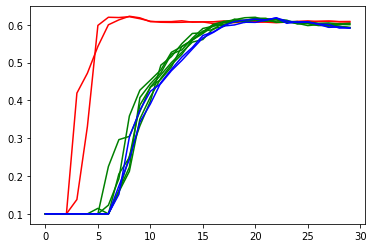

In [9]:
acc1 = [[0.1, 0.1, 0.1, 0.4192, 0.4718, 0.5425, 0.5997, 0.6127, 0.6223, 0.6181, 0.608, 0.6081, 0.6081, 0.6103, 0.6066, 0.6072, 0.6031, 0.6056, 0.6053, 0.6094, 0.6066, 0.6067, 0.6052, 0.6069, 0.6066, 0.6062, 0.6088, 0.6094, 0.6077, 0.6069], [0.1, 0.1, 0.1, 0.138, 0.331, 0.5981, 0.6196, 0.6189, 0.6211, 0.6158, 0.609, 0.6064, 0.606, 0.6063, 0.6075, 0.6075, 0.6077, 0.6099, 0.6071, 0.6093, 0.6086, 0.6091, 0.6067, 0.6063, 0.6087, 0.61, 0.6085, 0.6092, 0.6082, 0.6085], [0.1, 0.1, 0.1, 0.1, 0.0999, 0.1, 0.123, 0.1929, 0.3587, 0.4269, 0.4534, 0.4805, 0.527, 0.5423, 0.5596, 0.5765, 0.5969, 0.6053, 0.6078, 0.6104, 0.6169, 0.6169, 0.6066, 0.6064, 0.608, 0.6053, 0.6025, 0.6019, 0.6007, 0.6], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2056, 0.2492, 0.3875, 0.4344, 0.4558, 0.4883, 0.5425, 0.5594, 0.5831, 0.587, 0.6071, 0.6125, 0.6121, 0.6156, 0.6142, 0.614, 0.6075, 0.604, 0.6027, 0.5977, 0.598, 0.5956, 0.5916], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1578, 0.2525, 0.3326, 0.3977, 0.4931, 0.5154, 0.5498, 0.5768, 0.5786, 0.6005, 0.5973, 0.6131, 0.6184, 0.6196, 0.6114, 0.6068, 0.6066, 0.6078, 0.6074, 0.6036, 0.6047, 0.6019, 0.6036], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1582, 0.2125, 0.3507, 0.4091, 0.4585, 0.4943, 0.5216, 0.5596, 0.5817, 0.6008, 0.6086, 0.6122, 0.6058, 0.6145, 0.615, 0.6141, 0.6119, 0.6018, 0.6041, 0.6024, 0.5942, 0.5949, 0.593], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2251, 0.2962, 0.3048, 0.3704, 0.4356, 0.4674, 0.4998, 0.527, 0.5539, 0.5608, 0.5899, 0.5954, 0.6148, 0.6086, 0.6119, 0.6089, 0.6161, 0.6084, 0.6081, 0.604, 0.5993, 0.6004, 0.5958, 0.5916], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1146, 0.1, 0.1619, 0.2235, 0.4073, 0.4437, 0.4728, 0.5222, 0.5333, 0.5644, 0.59, 0.596, 0.6007, 0.6071, 0.6104, 0.6144, 0.6109, 0.6125, 0.6075, 0.6037, 0.5976, 0.6002, 0.5985, 0.6027, 0.6016], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1517, 0.3032, 0.3737, 0.4239, 0.4446, 0.4782, 0.5056, 0.5356, 0.5651, 0.5796, 0.5966, 0.5993, 0.6065, 0.6061, 0.612, 0.618, 0.6096, 0.6057, 0.6068, 0.6016, 0.6005, 0.5911, 0.5914], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1737, 0.2439, 0.3425, 0.3905, 0.447, 0.4818, 0.5144, 0.5399, 0.5713, 0.5808, 0.5977, 0.6082, 0.6121, 0.6146, 0.6125, 0.618, 0.6036, 0.6074, 0.6074, 0.6009, 0.593, 0.594, 0.591]]

acc2 = [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1009, 0.1063, 0.1001, 0.1668, 0.1787, 0.2348, 0.3195, 0.3694, 0.3906, 0.4189, 0.4468, 0.4666, 0.4819, 0.508, 0.5265, 0.5404, 0.5503, 0.5614, 0.574, 0.5814, 0.5883], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1367, 0.1, 0.1009, 0.1063, 0.1001, 0.1668, 0.1787, 0.2398, 0.3197, 0.3688, 0.3922, 0.4177, 0.4468, 0.465, 0.4835, 0.5093, 0.5271, 0.5404, 0.5525, 0.5614, 0.575, 0.581, 0.5887], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3185, 0.3712, 0.3899, 0.417, 0.4512, 0.4672, 0.4815, 0.5053, 0.5278, 0.5383, 0.5512, 0.5617, 0.571, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.0999, 0.1801, 0.2333, 0.3189, 0.3696, 0.3899, 0.417, 0.4478, 0.4671, 0.4818, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1518, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3189, 0.3712, 0.3907, 0.417, 0.4471, 0.4672, 0.4815, 0.5044, 0.5278, 0.5383, 0.5512, 0.5617, 0.571, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.0999, 0.1796, 0.2333, 0.3189, 0.3712, 0.3899, 0.417, 0.4504, 0.4671, 0.4802, 0.5031, 0.5219, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.136, 0.1796, 0.2333, 0.3141, 0.3712, 0.3885, 0.417, 0.4478, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3189, 0.3712, 0.3899, 0.417, 0.4512, 0.4671, 0.4771, 0.5053, 0.5237, 0.5344, 0.5465, 0.5538, 0.5678, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1812, 0.2363, 0.3185, 0.364, 0.3885, 0.4152, 0.4504, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.1, 0.1812, 0.2363, 0.3185, 0.364, 0.3885, 0.417, 0.4478, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789]]


import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in acc1:
    # print(len(j))
    if count< 2:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 2 and count<8:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
# plt.plot(x[0:30], z2[10][0:30],label='base',color = 'black')
# plt.plot(x[0:30], esb[0:30],label='base',color = 'grey')
count = 0
# plt.savefig('100ShufflenetCifar10.pdf')

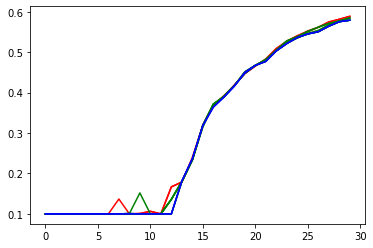

In [10]:
acc1 = [[0.1, 0.1, 0.1, 0.4192, 0.4718, 0.5425, 0.5997, 0.6127, 0.6223, 0.6181, 0.608, 0.6081, 0.6081, 0.6103, 0.6066, 0.6072, 0.6031, 0.6056, 0.6053, 0.6094, 0.6066, 0.6067, 0.6052, 0.6069, 0.6066, 0.6062, 0.6088, 0.6094, 0.6077, 0.6069], [0.1, 0.1, 0.1, 0.138, 0.331, 0.5981, 0.6196, 0.6189, 0.6211, 0.6158, 0.609, 0.6064, 0.606, 0.6063, 0.6075, 0.6075, 0.6077, 0.6099, 0.6071, 0.6093, 0.6086, 0.6091, 0.6067, 0.6063, 0.6087, 0.61, 0.6085, 0.6092, 0.6082, 0.6085], [0.1, 0.1, 0.1, 0.1, 0.0999, 0.1, 0.123, 0.1929, 0.3587, 0.4269, 0.4534, 0.4805, 0.527, 0.5423, 0.5596, 0.5765, 0.5969, 0.6053, 0.6078, 0.6104, 0.6169, 0.6169, 0.6066, 0.6064, 0.608, 0.6053, 0.6025, 0.6019, 0.6007, 0.6], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2056, 0.2492, 0.3875, 0.4344, 0.4558, 0.4883, 0.5425, 0.5594, 0.5831, 0.587, 0.6071, 0.6125, 0.6121, 0.6156, 0.6142, 0.614, 0.6075, 0.604, 0.6027, 0.5977, 0.598, 0.5956, 0.5916], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1578, 0.2525, 0.3326, 0.3977, 0.4931, 0.5154, 0.5498, 0.5768, 0.5786, 0.6005, 0.5973, 0.6131, 0.6184, 0.6196, 0.6114, 0.6068, 0.6066, 0.6078, 0.6074, 0.6036, 0.6047, 0.6019, 0.6036], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1582, 0.2125, 0.3507, 0.4091, 0.4585, 0.4943, 0.5216, 0.5596, 0.5817, 0.6008, 0.6086, 0.6122, 0.6058, 0.6145, 0.615, 0.6141, 0.6119, 0.6018, 0.6041, 0.6024, 0.5942, 0.5949, 0.593], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2251, 0.2962, 0.3048, 0.3704, 0.4356, 0.4674, 0.4998, 0.527, 0.5539, 0.5608, 0.5899, 0.5954, 0.6148, 0.6086, 0.6119, 0.6089, 0.6161, 0.6084, 0.6081, 0.604, 0.5993, 0.6004, 0.5958, 0.5916], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1146, 0.1, 0.1619, 0.2235, 0.4073, 0.4437, 0.4728, 0.5222, 0.5333, 0.5644, 0.59, 0.596, 0.6007, 0.6071, 0.6104, 0.6144, 0.6109, 0.6125, 0.6075, 0.6037, 0.5976, 0.6002, 0.5985, 0.6027, 0.6016], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1517, 0.3032, 0.3737, 0.4239, 0.4446, 0.4782, 0.5056, 0.5356, 0.5651, 0.5796, 0.5966, 0.5993, 0.6065, 0.6061, 0.612, 0.618, 0.6096, 0.6057, 0.6068, 0.6016, 0.6005, 0.5911, 0.5914], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1737, 0.2439, 0.3425, 0.3905, 0.447, 0.4818, 0.5144, 0.5399, 0.5713, 0.5808, 0.5977, 0.6082, 0.6121, 0.6146, 0.6125, 0.618, 0.6036, 0.6074, 0.6074, 0.6009, 0.593, 0.594, 0.591]]

acc2 = [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1009, 0.1063, 0.1001, 0.1668, 0.1787, 0.2348, 0.3195, 0.3694, 0.3906, 0.4189, 0.4468, 0.4666, 0.4819, 0.508, 0.5265, 0.5404, 0.5503, 0.5614, 0.574, 0.5814, 0.5883], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1367, 0.1, 0.1009, 0.1063, 0.1001, 0.1668, 0.1787, 0.2398, 0.3197, 0.3688, 0.3922, 0.4177, 0.4468, 0.465, 0.4835, 0.5093, 0.5271, 0.5404, 0.5525, 0.5614, 0.575, 0.581, 0.5887], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3185, 0.3712, 0.3899, 0.417, 0.4512, 0.4672, 0.4815, 0.5053, 0.5278, 0.5383, 0.5512, 0.5617, 0.571, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.0999, 0.1801, 0.2333, 0.3189, 0.3696, 0.3899, 0.417, 0.4478, 0.4671, 0.4818, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1518, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3189, 0.3712, 0.3907, 0.417, 0.4471, 0.4672, 0.4815, 0.5044, 0.5278, 0.5383, 0.5512, 0.5617, 0.571, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.0999, 0.1796, 0.2333, 0.3189, 0.3712, 0.3899, 0.417, 0.4504, 0.4671, 0.4802, 0.5031, 0.5219, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.136, 0.1796, 0.2333, 0.3141, 0.3712, 0.3885, 0.417, 0.4478, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.136, 0.1801, 0.2333, 0.3189, 0.3712, 0.3899, 0.417, 0.4512, 0.4671, 0.4771, 0.5053, 0.5237, 0.5344, 0.5465, 0.5538, 0.5678, 0.577, 0.5846], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1812, 0.2363, 0.3185, 0.364, 0.3885, 0.4152, 0.4504, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1007, 0.1, 0.1, 0.1, 0.1, 0.1812, 0.2363, 0.3185, 0.364, 0.3885, 0.417, 0.4478, 0.4671, 0.4771, 0.5031, 0.5212, 0.5361, 0.545, 0.5504, 0.5642, 0.5752, 0.5789]]


import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in acc2:
    # print(len(j))
    if count< 2:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 2 and count<8:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
# plt.plot(x[0:30], z2[10][0:30],label='base',color = 'black')
# plt.plot(x[0:30], esb[0:30],label='base',color = 'grey')
count = 0
# plt.savefig('100ShufflenetCifar10.pdf')

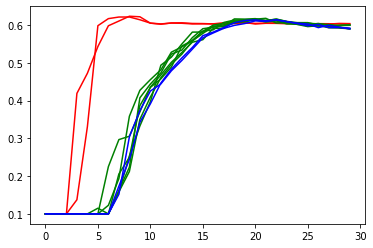

In [11]:
acc3 = [[0.1, 0.1, 0.1, 0.4189, 0.4722, 0.5429, 0.5979, 0.6104, 0.6231, 0.6217, 0.6048, 0.602, 0.6054, 0.6057, 0.604, 0.6037, 0.6028, 0.603, 0.6036, 0.6064, 0.6026, 0.6044, 0.6042, 0.6033, 0.6041, 0.6024, 0.6035, 0.6033, 0.6027, 0.6021], [0.1, 0.1, 0.1, 0.1374, 0.331, 0.5981, 0.6168, 0.621, 0.6211, 0.6138, 0.6049, 0.6028, 0.605, 0.6045, 0.6028, 0.6031, 0.603, 0.6059, 0.6056, 0.6054, 0.6042, 0.6048, 0.6057, 0.6055, 0.6046, 0.6029, 0.6027, 0.6023, 0.6041, 0.6036], [0.1, 0.1, 0.1, 0.1, 0.0999, 0.1, 0.1227, 0.1934, 0.3583, 0.427, 0.4553, 0.4813, 0.528, 0.542, 0.5579, 0.5775, 0.5963, 0.6004, 0.6075, 0.6088, 0.6154, 0.6176, 0.6051, 0.6068, 0.6047, 0.6011, 0.6039, 0.5991, 0.5981, 0.6002], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2056, 0.2497, 0.3865, 0.4348, 0.4574, 0.4886, 0.5442, 0.5592, 0.5838, 0.5872, 0.6067, 0.6131, 0.6136, 0.6139, 0.6117, 0.6125, 0.6071, 0.6014, 0.5957, 0.598, 0.5958, 0.5936, 0.5899], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1578, 0.2532, 0.3326, 0.3968, 0.4935, 0.5148, 0.5496, 0.5811, 0.5812, 0.5968, 0.5954, 0.616, 0.6155, 0.6168, 0.61, 0.6112, 0.6062, 0.6056, 0.6045, 0.6029, 0.6007, 0.5983, 0.5991], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1583, 0.2122, 0.3502, 0.4093, 0.4606, 0.4959, 0.5227, 0.5575, 0.5833, 0.5998, 0.6043, 0.6096, 0.6091, 0.6149, 0.6118, 0.6152, 0.6089, 0.6036, 0.5972, 0.5993, 0.5926, 0.592, 0.5899], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2251, 0.2966, 0.3055, 0.3699, 0.4355, 0.4679, 0.5012, 0.5271, 0.5543, 0.5611, 0.5914, 0.5909, 0.6107, 0.6113, 0.6135, 0.6113, 0.6157, 0.6094, 0.6062, 0.6062, 0.6, 0.6012, 0.5935, 0.5904], [0.1, 0.1, 0.1, 0.1, 0.1, 0.115, 0.1, 0.162, 0.2236, 0.4072, 0.4436, 0.4731, 0.5229, 0.5335, 0.5665, 0.5901, 0.594, 0.5978, 0.6052, 0.6102, 0.6135, 0.6078, 0.6107, 0.6027, 0.6018, 0.5996, 0.5971, 0.5956, 0.5993, 0.5994], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1519, 0.3039, 0.3732, 0.4251, 0.4439, 0.4787, 0.5061, 0.536, 0.566, 0.579, 0.5912, 0.5989, 0.6038, 0.6108, 0.6094, 0.6133, 0.6087, 0.6048, 0.6026, 0.593, 0.5992, 0.594, 0.5895], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1732, 0.2442, 0.3425, 0.3913, 0.4464, 0.483, 0.5127, 0.5405, 0.5716, 0.5812, 0.5935, 0.6058, 0.6119, 0.6134, 0.6107, 0.6135, 0.6088, 0.6038, 0.5979, 0.6014, 0.5931, 0.5932, 0.5917]]

import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in acc3:
    # print(len(j))
    if count< 2:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 2 and count<8:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
# plt.plot(x[0:30], z2[10][0:30],label='base',color = 'black')
# plt.plot(x[0:30], esb[0:30],label='base',color = 'grey')
count = 0
# plt.savefig('100ShufflenetCifar10.pdf')

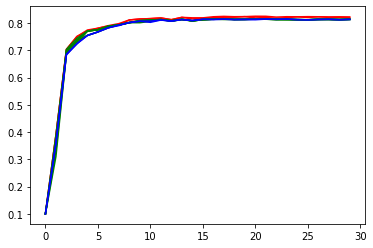

In [12]:
accres = [[0.1, 0.3886, 0.7033, 0.7505, 0.7744, 0.7809, 0.7892, 0.794, 0.8113, 0.8148, 0.8162, 0.8186, 0.8123, 0.8208, 0.8152, 0.8177, 0.8197, 0.8213, 0.8214, 0.8235, 0.8188, 0.8201, 0.8176, 0.8198, 0.8228, 0.8203, 0.823, 0.8207, 0.8204, 0.8192], [0.1, 0.3886, 0.7033, 0.7505, 0.7701, 0.7809, 0.7904, 0.7979, 0.8113, 0.8148, 0.8162, 0.8186, 0.8123, 0.8208, 0.8191, 0.819, 0.823, 0.8244, 0.8232, 0.8235, 0.8249, 0.8247, 0.8218, 0.8232, 0.8228, 0.8234, 0.823, 0.8225, 0.8229, 0.8225], [0.1, 0.3589, 0.6981, 0.7361, 0.7703, 0.7754, 0.7884, 0.7929, 0.8022, 0.8088, 0.8108, 0.8127, 0.8082, 0.8138, 0.808, 0.8137, 0.8142, 0.8156, 0.8134, 0.8136, 0.8144, 0.814, 0.8129, 0.8123, 0.8124, 0.812, 0.8141, 0.8131, 0.813, 0.8137], [0.1018, 0.3886, 0.6981, 0.7361, 0.7545, 0.7674, 0.7824, 0.7929, 0.8013, 0.8088, 0.8108, 0.8127, 0.8068, 0.8138, 0.808, 0.812, 0.8133, 0.8156, 0.8131, 0.8138, 0.8143, 0.8148, 0.8136, 0.8143, 0.8125, 0.8119, 0.813, 0.8135, 0.8123, 0.8133], [0.1, 0.3103, 0.6858, 0.7307, 0.7545, 0.7674, 0.7884, 0.7929, 0.8013, 0.8012, 0.8063, 0.8127, 0.8082, 0.8138, 0.808, 0.812, 0.8142, 0.8129, 0.8131, 0.8134, 0.8144, 0.814, 0.8125, 0.8123, 0.8124, 0.812, 0.8141, 0.8131, 0.813, 0.8137], [0.1, 0.3589, 0.7033, 0.7443, 0.7703, 0.7754, 0.7884, 0.7929, 0.8013, 0.8067, 0.8063, 0.8127, 0.8068, 0.8123, 0.808, 0.812, 0.8142, 0.8156, 0.8131, 0.8124, 0.8143, 0.8138, 0.8136, 0.8134, 0.8125, 0.8119, 0.813, 0.8135, 0.8123, 0.8133], [0.1, 0.3589, 0.6904, 0.7395, 0.7703, 0.7755, 0.7884, 0.793, 0.8022, 0.8067, 0.8108, 0.8127, 0.8082, 0.8123, 0.808, 0.8133, 0.8142, 0.814, 0.8131, 0.8138, 0.8143, 0.8143, 0.8136, 0.8143, 0.8125, 0.8119, 0.813, 0.8135, 0.8123, 0.8133], [0.1, 0.3318, 0.6858, 0.7241, 0.7703, 0.7754, 0.788, 0.7929, 0.8013, 0.8088, 0.8108, 0.8127, 0.8082, 0.8138, 0.808, 0.812, 0.8142, 0.8156, 0.8134, 0.8136, 0.8143, 0.8143, 0.8129, 0.8131, 0.8123, 0.8122, 0.8127, 0.8135, 0.813, 0.8137], [0.1, 0.3589, 0.6858, 0.7241, 0.7545, 0.7674, 0.783, 0.7906, 0.8022, 0.8067, 0.8073, 0.811, 0.8071, 0.8129, 0.809, 0.8137, 0.813, 0.814, 0.8122, 0.8124, 0.8121, 0.8143, 0.8136, 0.8143, 0.8125, 0.8119, 0.813, 0.8135, 0.8123, 0.8133], [0.1, 0.3589, 0.683, 0.7241, 0.7545, 0.7674, 0.7824, 0.7929, 0.8013, 0.8067, 0.8026, 0.811, 0.8071, 0.8129, 0.809, 0.8137, 0.813, 0.814, 0.8134, 0.8138, 0.8143, 0.8143, 0.8136, 0.8143, 0.8125, 0.8119, 0.813, 0.8135, 0.8123, 0.8133]]

import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in accres:
    # print(len(j))
    if count< 2:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 2 and count<8:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
    
count = 0

# for j in accres:
#     # print(len(j))
#     if count< 2:
#         plt.plot(x[20:30], j[20:30],label=str(count),color = 'red')
#     elif count >= 2 and count<8:
#         plt.plot(x[20:30], j[20:30],label=str(count),color = 'green')
#     else:
#         plt.plot(x[20:30], j[20:30],label=str(count),color = 'blue')
#     # plt.legend(loc = 'lower right')
#     count += 1
# plt.plot(x[0:30], z2[10][0:30],label='base',color = 'black')
# plt.plot(x[0:30], esb[0:30],label='base',color = 'grey')
count = 0
# plt.savefig('100ShufflenetCifar10.pdf')

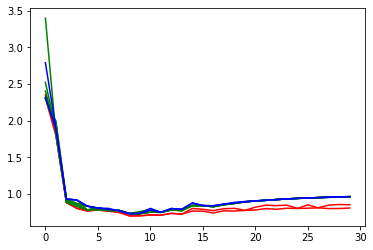

In [13]:
lossres = [[2.302625000476837, 1.8022244727611543, 0.8816425877809525, 0.8030892759561539, 0.7633408841490745, 0.7832955476641655, 0.7666320621967315, 0.7716605740785599, 0.6995455041527748, 0.7015583717823028, 0.7125322821736336, 0.709798610508442, 0.7346266108751297, 0.7240135145187377, 0.8015551522374154, 0.7896943962574006, 0.7721853756904602, 0.7975020176172256, 0.8033481627702713, 0.7748951783776283, 0.8182468488812447, 0.846570283472538, 0.8402186727523804, 0.846782191991806, 0.8014537099003792, 0.8503022861480712, 0.809961601793766, 0.8479916498064994, 0.8550600060820579, 0.851575990319252], [2.3516815900802612, 1.8022244727611543, 0.8816425877809525, 0.8030892759561539, 0.7724395892024041, 0.7832955476641655, 0.7638778042793274, 0.7464164859056472, 0.6995455041527748, 0.7015583717823028, 0.7125322821736336, 0.709798610508442, 0.7346266108751297, 0.7240135145187377, 0.7659588134288788, 0.7646622857451439, 0.7393116188049317, 0.7689427530765534, 0.7657485574483871, 0.7748951783776283, 0.7805384725332261, 0.7997619616985321, 0.7900769165158272, 0.8043197360634804, 0.8014537099003792, 0.8044896978139877, 0.809961601793766, 0.7999155613780021, 0.8005828389525413, 0.8075596091151237], [2.404179768562317, 1.8905949866771699, 0.8897841984033584, 0.8541855001449585, 0.7806223651766777, 0.8121909099817276, 0.7734455174207687, 0.7753765195608139, 0.728730115890503, 0.7298256632685661, 0.7502044293284417, 0.7485696756839753, 0.7808721876144409, 0.7713568690419197, 0.8417077839374543, 0.8404573139548301, 0.825343148112297, 0.8519865581393242, 0.8755746245384216, 0.8916268214583397, 0.9036878135800361, 0.913169646859169, 0.9229450178146362, 0.932092138826847, 0.939624054133892, 0.9459484052658081, 0.9483786714076996, 0.9528171324729919, 0.9569781613349915, 0.9616649931669236], [3.3983654379844666, 1.8022244727611543, 0.8897841984033584, 0.8541855001449585, 0.832276468873024, 0.8066540405154228, 0.7878804153203964, 0.7753765195608139, 0.733221066892147, 0.7298256632685661, 0.7502044293284417, 0.7485696756839753, 0.7926082429289818, 0.7713568690419197, 0.8417077839374543, 0.8395878821611404, 0.8304849946498871, 0.8519865581393242, 0.8698234704136848, 0.8908243581652642, 0.9038248860836029, 0.912590173482895, 0.9227285942435265, 0.9308664721250534, 0.9384874266386032, 0.9439046823978424, 0.9501583832502365, 0.9551686543226242, 0.9595692700147629, 0.9627619072794914], [2.303022267818451, 1.9948974025249482, 0.9282531821727753, 0.8709664636850357, 0.832276468873024, 0.8066540405154228, 0.7734455174207687, 0.7753765195608139, 0.733221066892147, 0.7589850217103958, 0.7865054276585579, 0.7485696756839753, 0.7808721876144409, 0.7713568690419197, 0.8417077839374543, 0.8395878821611404, 0.825343148112297, 0.8584724244475365, 0.8698234704136848, 0.8908513623476029, 0.9036878135800361, 0.913169646859169, 0.921620115339756, 0.932092138826847, 0.939624054133892, 0.9459484052658081, 0.9483786714076996, 0.9528171324729919, 0.9569781613349915, 0.9616649931669236], [2.521993811130524, 1.8905949866771699, 0.8816425877809525, 0.8275598925352097, 0.7806223651766777, 0.8121909099817276, 0.7734455174207687, 0.7753765195608139, 0.733221066892147, 0.7337018558382988, 0.7865054276585579, 0.7485696756839753, 0.7926082429289818, 0.7861045175790786, 0.8417077839374543, 0.8395878821611404, 0.825343148112297, 0.8519865581393242, 0.8698234704136848, 0.895598209798336, 0.9038248860836029, 0.9134479907155036, 0.9227285942435265, 0.9311926981806755, 0.9384874266386032, 0.9439046823978424, 0.9501583832502365, 0.9551686543226242, 0.9595692700147629, 0.9627619072794914], [2.3047210121154786, 1.8905949866771699, 0.910596986413002, 0.850525694489479, 0.7806223651766777, 0.7815598559379577, 0.7734455174207687, 0.7682825842499733, 0.728730115890503, 0.7337018558382988, 0.7502044293284417, 0.7485696756839753, 0.7808721876144409, 0.7861045175790786, 0.8417077839374543, 0.8451554775238037, 0.825343148112297, 0.8606594464182854, 0.8698234704136848, 0.8908243581652642, 0.9038248860836029, 0.9121031066775322, 0.9227285942435265, 0.9308664721250534, 0.9384874266386032, 0.9439046823978424, 0.9501583832502365, 0.9551686543226242, 0.9595692700147629, 0.9627619072794914], [2.3094701266288755, 1.970670154094696, 0.9282531821727753, 0.9162494742870331, 0.7806223651766777, 0.8121909099817276, 0.7836638987064362, 0.7753765195608139, 0.733221066892147, 0.7298256632685661, 0.7502044293284417, 0.7485696756839753, 0.7808721876144409, 0.7713568690419197, 0.8417077839374543, 0.8395878821611404, 0.825343148112297, 0.8519865581393242, 0.8755746245384216, 0.8916268214583397, 0.9038248860836029, 0.9121031066775322, 0.9229450178146362, 0.9320477631688118, 0.9381513112783432, 0.9449659192562103, 0.9494243779778481, 0.9548953372240067, 0.9569781613349915, 0.9616649931669236], [2.7909971570968626, 1.8905949866771699, 0.9282531821727753, 0.9162494742870331, 0.832276468873024, 0.8066540405154228, 0.8026415729522705, 0.7687056896090507, 0.728730115890503, 0.7337018558382988, 0.7781207191944123, 0.7492813417315483, 0.8004515621066094, 0.7907190671563149, 0.8766283640265464, 0.8404573139548301, 0.83856464356184, 0.8606594464182854, 0.8840768054127693, 0.895598209798336, 0.906757580935955, 0.9121031066775322, 0.9227285942435265, 0.9308664721250534, 0.9384874266386032, 0.9439046823978424, 0.9501583832502365, 0.9551686543226242, 0.9595692700147629, 0.9627619072794914], [2.3210678768157957, 1.8905949866771699, 0.9333493393659592, 0.9162494742870331, 0.832276468873024, 0.8066540405154228, 0.7878804153203964, 0.7753765195608139, 0.733221066892147, 0.7337018558382988, 0.8022836744785309, 0.7492813417315483, 0.8004515621066094, 0.7907190671563149, 0.8766283640265464, 0.8404573139548301, 0.83856464356184, 0.8606594464182854, 0.8755746245384216, 0.8908243581652642, 0.9038248860836029, 0.9121031066775322, 0.9227285942435265, 0.9308664721250534, 0.9384874266386032, 0.9439046823978424, 0.9501583832502365, 0.9551686543226242, 0.9595692700147629, 0.9627619072794914]]


import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in lossres:
    # print(len(j))
    if count< 2:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 2 and count<8:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
    
count = 0

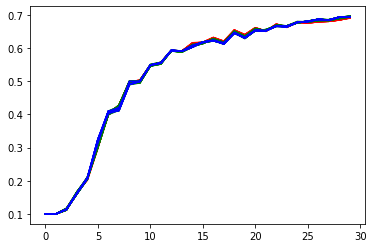

In [19]:
accshuffle = [[0.1, 0.1, 0.1143, 0.1642, 0.2082, 0.3013, 0.402, 0.4255, 0.4972, 0.4978, 0.5475, 0.5565, 0.5917, 0.5915, 0.6089, 0.6139, 0.6289, 0.617, 0.6512, 0.6355, 0.6593, 0.6522, 0.6702, 0.6659, 0.6789, 0.6783, 0.6826, 0.6826, 0.6865, 0.6912], [0.1, 0.1, 0.1118, 0.1603, 0.2102, 0.313, 0.403, 0.4262, 0.4984, 0.4988, 0.5485, 0.5569, 0.5917, 0.5915, 0.6115, 0.6146, 0.6283, 0.617, 0.6541, 0.636, 0.6582, 0.6522, 0.6688, 0.6662, 0.6789, 0.6777, 0.6821, 0.683, 0.6865, 0.6905], [0.1, 0.1, 0.1118, 0.1652, 0.2053, 0.3089, 0.4015, 0.4206, 0.497, 0.5019, 0.5485, 0.5569, 0.5918, 0.5917, 0.6115, 0.6146, 0.6289, 0.617, 0.6541, 0.636, 0.6582, 0.6526, 0.6718, 0.6641, 0.6785, 0.6786, 0.6793, 0.6815, 0.6851, 0.6917], [0.1, 0.1, 0.1161, 0.1631, 0.2023, 0.2988, 0.4038, 0.4265, 0.4994, 0.5027, 0.5487, 0.5568, 0.5934, 0.5914, 0.6144, 0.6157, 0.6317, 0.6199, 0.654, 0.639, 0.6617, 0.6505, 0.6721, 0.6634, 0.6781, 0.6751, 0.68, 0.6809, 0.6851, 0.6913], [0.1, 0.1, 0.1166, 0.1644, 0.2075, 0.3008, 0.403, 0.4276, 0.4973, 0.5035, 0.5487, 0.5569, 0.5926, 0.5899, 0.6162, 0.618, 0.6321, 0.6204, 0.6543, 0.6407, 0.6613, 0.6509, 0.673, 0.6624, 0.6777, 0.6762, 0.6789, 0.6809, 0.6846, 0.6919], [0.1, 0.1, 0.1147, 0.1636, 0.2063, 0.3012, 0.4029, 0.4276, 0.4988, 0.5031, 0.5492, 0.5565, 0.592, 0.5907, 0.6152, 0.6172, 0.6314, 0.6196, 0.654, 0.639, 0.66, 0.6517, 0.6715, 0.6635, 0.6768, 0.6783, 0.6793, 0.6815, 0.6851, 0.6917], [0.1, 0.1, 0.1116, 0.1652, 0.2077, 0.3089, 0.4, 0.4276, 0.4973, 0.5033, 0.5492, 0.5553, 0.593, 0.5907, 0.6152, 0.6172, 0.6309, 0.618, 0.6542, 0.6374, 0.6598, 0.6526, 0.6698, 0.6641, 0.6785, 0.6777, 0.6819, 0.681, 0.6851, 0.6917], [0.1, 0.1, 0.1147, 0.1651, 0.2053, 0.3015, 0.4, 0.4233, 0.497, 0.5031, 0.5496, 0.5565, 0.592, 0.5907, 0.6152, 0.6172, 0.6322, 0.6206, 0.6546, 0.6407, 0.6614, 0.6515, 0.6721, 0.6644, 0.6783, 0.677, 0.6795, 0.681, 0.6853, 0.6905], [0.1, 0.1, 0.1116, 0.1651, 0.2088, 0.3015, 0.3986, 0.4282, 0.497, 0.5019, 0.5485, 0.5569, 0.5919, 0.5907, 0.6144, 0.6157, 0.6317, 0.621, 0.6534, 0.6399, 0.6617, 0.6505, 0.6716, 0.6645, 0.6783, 0.6751, 0.68, 0.6809, 0.6851, 0.6917], [0.1, 0.1, 0.1147, 0.1631, 0.2023, 0.2987, 0.4038, 0.4265, 0.4989, 0.5011, 0.5478, 0.5575, 0.5926, 0.5919, 0.6144, 0.6178, 0.6316, 0.621, 0.6546, 0.6407, 0.6614, 0.6512, 0.6711, 0.6634, 0.6781, 0.6751, 0.68, 0.6809, 0.6849, 0.6915], [0.1, 0.1, 0.1128, 0.1624, 0.2062, 0.3251, 0.4031, 0.4176, 0.5, 0.5003, 0.5469, 0.5545, 0.5925, 0.5909, 0.6075, 0.6176, 0.6231, 0.6133, 0.6465, 0.6303, 0.6536, 0.653, 0.6676, 0.6656, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1152, 0.1628, 0.2065, 0.3063, 0.4029, 0.426, 0.497, 0.5019, 0.5485, 0.5565, 0.5917, 0.5915, 0.6089, 0.6151, 0.6289, 0.617, 0.6512, 0.6357, 0.6593, 0.6528, 0.6686, 0.6671, 0.6805, 0.6793, 0.6832, 0.6843, 0.6904, 0.695], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3215, 0.4098, 0.424, 0.4974, 0.4997, 0.5469, 0.5559, 0.5929, 0.5909, 0.6031, 0.6176, 0.6231, 0.6167, 0.6465, 0.6302, 0.6525, 0.6558, 0.6682, 0.6672, 0.678, 0.6801, 0.6842, 0.6834, 0.69, 0.695], [0.1, 0.1, 0.1143, 0.1652, 0.2065, 0.3129, 0.3998, 0.424, 0.4984, 0.4951, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6162, 0.6227, 0.6145, 0.6483, 0.6355, 0.656, 0.6525, 0.6686, 0.6671, 0.677, 0.6801, 0.6835, 0.6841, 0.692, 0.6962], [0.1, 0.1, 0.1116, 0.1666, 0.2053, 0.3013, 0.402, 0.4282, 0.4983, 0.4951, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6176, 0.6237, 0.6167, 0.6458, 0.6303, 0.6529, 0.6528, 0.6662, 0.6672, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6949], [0.1, 0.1, 0.1116, 0.1666, 0.2102, 0.313, 0.3993, 0.4233, 0.4974, 0.4997, 0.5491, 0.5562, 0.5914, 0.5906, 0.6031, 0.6176, 0.6237, 0.6167, 0.65, 0.6363, 0.6565, 0.6525, 0.6684, 0.6652, 0.6768, 0.6807, 0.6869, 0.6841, 0.6913, 0.6949], [0.1, 0.1, 0.1116, 0.1666, 0.2053, 0.3063, 0.3998, 0.4176, 0.4905, 0.5018, 0.5491, 0.5562, 0.5919, 0.588, 0.6042, 0.6187, 0.6219, 0.6167, 0.6458, 0.6303, 0.6536, 0.6528, 0.6662, 0.6643, 0.6762, 0.6807, 0.6869, 0.6841, 0.6907, 0.696], [0.1, 0.1, 0.1147, 0.1645, 0.2075, 0.3008, 0.403, 0.426, 0.497, 0.5019, 0.5485, 0.5542, 0.5924, 0.5886, 0.6056, 0.6139, 0.6279, 0.6172, 0.6508, 0.6355, 0.6593, 0.6518, 0.6683, 0.6673, 0.6786, 0.6793, 0.6832, 0.6845, 0.6899, 0.6957], [0.1, 0.1, 0.1143, 0.1601, 0.2055, 0.3206, 0.3998, 0.4176, 0.4905, 0.4964, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6187, 0.6231, 0.6167, 0.6465, 0.6302, 0.6529, 0.6528, 0.6662, 0.6663, 0.6768, 0.6807, 0.6869, 0.6841, 0.6932, 0.6934], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3206, 0.4098, 0.4176, 0.4971, 0.4988, 0.5485, 0.5537, 0.5919, 0.588, 0.6056, 0.6139, 0.6279, 0.6172, 0.65, 0.6355, 0.656, 0.6525, 0.6684, 0.6653, 0.6774, 0.6793, 0.6838, 0.6831, 0.6899, 0.696], [0.1, 0.1, 0.1143, 0.161, 0.2055, 0.3088, 0.4098, 0.4101, 0.4905, 0.4986, 0.5458, 0.5549, 0.5919, 0.588, 0.6042, 0.6185, 0.6219, 0.6145, 0.6483, 0.6314, 0.6536, 0.653, 0.6662, 0.6671, 0.677, 0.6818, 0.6842, 0.6858, 0.6932, 0.6962], [0.1, 0.1, 0.117, 0.1642, 0.2088, 0.3013, 0.402, 0.4275, 0.4971, 0.4964, 0.5482, 0.5536, 0.5924, 0.5886, 0.6056, 0.6139, 0.6279, 0.6172, 0.6506, 0.6346, 0.6565, 0.6525, 0.6682, 0.6663, 0.677, 0.6795, 0.6846, 0.6858, 0.6932, 0.6958], [0.1, 0.1, 0.1126, 0.1607, 0.2055, 0.3097, 0.3998, 0.4176, 0.4905, 0.5018, 0.5456, 0.557, 0.5925, 0.5906, 0.6075, 0.6185, 0.6227, 0.6141, 0.6467, 0.6303, 0.6529, 0.6528, 0.6682, 0.6656, 0.6769, 0.6803, 0.6869, 0.6853, 0.69, 0.6934], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3101, 0.4018, 0.424, 0.4905, 0.4997, 0.5456, 0.5521, 0.5925, 0.5883, 0.6042, 0.6185, 0.6219, 0.6145, 0.65, 0.6363, 0.653, 0.6524, 0.6682, 0.6663, 0.6767, 0.6801, 0.6842, 0.6855, 0.692, 0.695], [0.1, 0.1, 0.1144, 0.161, 0.2065, 0.3206, 0.4073, 0.4249, 0.4974, 0.5007, 0.5482, 0.5521, 0.5914, 0.5906, 0.6056, 0.6139, 0.6279, 0.6172, 0.6506, 0.6346, 0.6565, 0.6525, 0.6684, 0.6652, 0.6767, 0.6814, 0.6873, 0.6841, 0.6941, 0.6934], [0.1, 0.1, 0.1144, 0.1607, 0.2065, 0.313, 0.4021, 0.4275, 0.4983, 0.4951, 0.546, 0.5521, 0.5925, 0.5906, 0.6048, 0.6187, 0.6219, 0.6173, 0.6458, 0.6303, 0.656, 0.6524, 0.6674, 0.6659, 0.678, 0.6795, 0.6842, 0.6855, 0.69, 0.6955], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3097, 0.4018, 0.424, 0.5007, 0.5007, 0.5456, 0.5549, 0.5925, 0.5906, 0.6048, 0.6176, 0.6219, 0.6173, 0.6483, 0.6303, 0.6545, 0.6558, 0.6682, 0.6659, 0.6768, 0.6814, 0.6873, 0.6853, 0.6937, 0.6955], [0.1, 0.1, 0.1116, 0.1642, 0.2088, 0.3064, 0.4018, 0.4233, 0.4974, 0.4997, 0.5456, 0.557, 0.5949, 0.5908, 0.6048, 0.6187, 0.6231, 0.6141, 0.6458, 0.6303, 0.6529, 0.6524, 0.6691, 0.6671, 0.6763, 0.6808, 0.6835, 0.6834, 0.6905, 0.6962], [0.1, 0.1, 0.1163, 0.1601, 0.2077, 0.3015, 0.4018, 0.4249, 0.5009, 0.5007, 0.5456, 0.5549, 0.591, 0.5908, 0.6048, 0.6187, 0.6231, 0.6173, 0.6467, 0.629, 0.6545, 0.6533, 0.6673, 0.6665, 0.6768, 0.6795, 0.6863, 0.6853, 0.6937, 0.6955], [0.1, 0.1, 0.1163, 0.1666, 0.2084, 0.3091, 0.4032, 0.424, 0.4924, 0.5014, 0.5508, 0.5575, 0.591, 0.5886, 0.6032, 0.6187, 0.6231, 0.6141, 0.6458, 0.6314, 0.6537, 0.6533, 0.6658, 0.6673, 0.678, 0.6801, 0.6835, 0.6845, 0.6899, 0.695], [0.1, 0.1, 0.1116, 0.1656, 0.2102, 0.3121, 0.3998, 0.4196, 0.4897, 0.5014, 0.5456, 0.557, 0.591, 0.5908, 0.6048, 0.6162, 0.6219, 0.6173, 0.6467, 0.629, 0.6537, 0.6533, 0.6658, 0.6665, 0.678, 0.6804, 0.6873, 0.6853, 0.6937, 0.6941], [0.1, 0.1, 0.1123, 0.1614, 0.2065, 0.3089, 0.402, 0.4275, 0.4971, 0.5019, 0.55, 0.5537, 0.5924, 0.5886, 0.6115, 0.6139, 0.6289, 0.6173, 0.6517, 0.6355, 0.6593, 0.6523, 0.6699, 0.6673, 0.6786, 0.678, 0.6834, 0.6843, 0.6891, 0.6957], [0.1, 0.1, 0.1143, 0.1607, 0.2057, 0.3091, 0.4034, 0.4196, 0.4924, 0.4978, 0.5482, 0.5521, 0.5919, 0.5883, 0.6062, 0.6139, 0.6279, 0.617, 0.6517, 0.6355, 0.6593, 0.6523, 0.6699, 0.6665, 0.678, 0.6784, 0.6835, 0.6849, 0.6883, 0.6937], [0.1, 0.1, 0.1143, 0.1603, 0.2124, 0.3091, 0.3998, 0.4122, 0.4897, 0.5014, 0.5508, 0.557, 0.591, 0.5893, 0.6031, 0.6162, 0.6231, 0.6141, 0.6483, 0.632, 0.6537, 0.6558, 0.6674, 0.6665, 0.678, 0.6804, 0.6869, 0.6859, 0.69, 0.6958], [0.1, 0.1, 0.1163, 0.1607, 0.2065, 0.3194, 0.4034, 0.4122, 0.4897, 0.4951, 0.5473, 0.5521, 0.5925, 0.5906, 0.6053, 0.6162, 0.6219, 0.6141, 0.6458, 0.6302, 0.6541, 0.6533, 0.6673, 0.6643, 0.6768, 0.6814, 0.6873, 0.6841, 0.6927, 0.6941], [0.1, 0.1, 0.1116, 0.1644, 0.2082, 0.3013, 0.402, 0.4233, 0.4971, 0.4983, 0.5482, 0.5544, 0.591, 0.5906, 0.6075, 0.6162, 0.6219, 0.6167, 0.6458, 0.6302, 0.6541, 0.6533, 0.6673, 0.6643, 0.6768, 0.6804, 0.6869, 0.6831, 0.6899, 0.6957], [0.1, 0.1, 0.1152, 0.1666, 0.2082, 0.3013, 0.3986, 0.4233, 0.4974, 0.4983, 0.5482, 0.5559, 0.593, 0.5906, 0.6053, 0.6187, 0.6231, 0.6123, 0.6458, 0.6314, 0.6536, 0.6533, 0.6658, 0.6643, 0.6768, 0.6814, 0.6867, 0.6841, 0.6937, 0.6958], [0.1, 0.1, 0.1137, 0.1607, 0.2057, 0.313, 0.4034, 0.4196, 0.4971, 0.4951, 0.5473, 0.5521, 0.5925, 0.5906, 0.6031, 0.6187, 0.6219, 0.6145, 0.6483, 0.6363, 0.653, 0.6558, 0.6658, 0.6643, 0.6767, 0.6814, 0.6867, 0.6834, 0.69, 0.6962], [0.1, 0.1, 0.1137, 0.1603, 0.2065, 0.3015, 0.4008, 0.4251, 0.4924, 0.4992, 0.5469, 0.5521, 0.5925, 0.5893, 0.6031, 0.6187, 0.6231, 0.6124, 0.6447, 0.6302, 0.6525, 0.6558, 0.6673, 0.6665, 0.6768, 0.6809, 0.6867, 0.6853, 0.6924, 0.6962], [0.1, 0.1, 0.1137, 0.1603, 0.2065, 0.3194, 0.4098, 0.4233, 0.4974, 0.4955, 0.5482, 0.5551, 0.5925, 0.5893, 0.6031, 0.6187, 0.6231, 0.6124, 0.6479, 0.6311, 0.654, 0.6519, 0.6691, 0.6652, 0.6767, 0.6795, 0.6867, 0.6846, 0.6932, 0.694], [0.1, 0.1, 0.1137, 0.1627, 0.2109, 0.3251, 0.4034, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6231, 0.6167, 0.6447, 0.6322, 0.654, 0.6519, 0.6676, 0.664, 0.678, 0.6795, 0.6867, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1137, 0.1603, 0.2057, 0.3194, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5559, 0.593, 0.5909, 0.6075, 0.6178, 0.6231, 0.6124, 0.6447, 0.6322, 0.6536, 0.653, 0.6676, 0.6672, 0.678, 0.6807, 0.6867, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3194, 0.4098, 0.4206, 0.4905, 0.4997, 0.5491, 0.5559, 0.593, 0.5909, 0.6031, 0.6187, 0.6231, 0.6124, 0.6447, 0.6322, 0.654, 0.6519, 0.6673, 0.6643, 0.678, 0.6807, 0.6869, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.313, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6075, 0.6187, 0.6231, 0.6141, 0.6458, 0.6322, 0.6536, 0.6519, 0.6658, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6231, 0.6124, 0.6458, 0.6322, 0.654, 0.653, 0.6676, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6955], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4996, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6219, 0.6141, 0.6479, 0.6314, 0.6536, 0.6519, 0.6676, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1139, 0.1627, 0.2077, 0.3251, 0.4034, 0.4206, 0.4905, 0.5003, 0.5482, 0.5545, 0.5914, 0.5906, 0.6075, 0.6162, 0.624, 0.6133, 0.6465, 0.6303, 0.6529, 0.6519, 0.6658, 0.6641, 0.678, 0.6807, 0.6867, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1139, 0.1607, 0.2077, 0.3194, 0.4098, 0.4122, 0.4996, 0.4997, 0.5482, 0.5551, 0.5941, 0.5906, 0.6031, 0.6178, 0.624, 0.6133, 0.6465, 0.6303, 0.6536, 0.6519, 0.6676, 0.6643, 0.678, 0.6807, 0.6867, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1143, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4905, 0.5003, 0.5491, 0.5551, 0.5941, 0.5909, 0.6075, 0.6178, 0.624, 0.6133, 0.6465, 0.6302, 0.6529, 0.6519, 0.6676, 0.6641, 0.6768, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1128, 0.1627, 0.2077, 0.3251, 0.4034, 0.4122, 0.4905, 0.5003, 0.5491, 0.5559, 0.5941, 0.5909, 0.6031, 0.6187, 0.6231, 0.6133, 0.6458, 0.6303, 0.6529, 0.6524, 0.6673, 0.6643, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6934]]
lossshuffle = [[2.302586669921875, 2.552130482196808, 3.4729533123970033, 3.2414389276504516, 2.7709699368476866, 2.306362488269806, 1.9647595930099486, 1.8933792555332183, 1.697048671245575, 1.7317710900306702, 1.5511660444736481, 1.5155943089723587, 1.404426783323288, 1.3797707045078278, 1.3541198700666428, 1.3077057331800461, 1.3011579436063767, 1.3373360878229141, 1.2427619755268098, 1.292740559577942, 1.2263230800628662, 1.2527107322216033, 1.205464606285095, 1.229926666021347, 1.1918562573194504, 1.1939928847551347, 1.195872692465782, 1.195620698928833, 1.1832116222381592, 1.1636855655908585], [2.3075275111198423, 2.6438679003715517, 3.5023439526557922, 3.177270109653473, 2.737719612121582, 2.232659661769867, 1.9520419907569886, 1.8955491030216216, 1.6931398451328277, 1.7259604120254517, 1.5410828328132629, 1.5115718394517899, 1.404426783323288, 1.3797707045078278, 1.3481231927871704, 1.3065579152107238, 1.29880839407444, 1.3307577258348464, 1.2342171239852906, 1.2853971576690675, 1.2184755235910416, 1.2527107322216033, 1.1989732837677003, 1.2244733780622483, 1.1918562573194504, 1.19205016374588, 1.1890962129831315, 1.188557692170143, 1.1790587919950486, 1.1426731783151627], [2.302587058544159, 2.6438679003715517, 3.5023439526557922, 3.1991001033782958, 2.7702627396583557, 2.25997983455658, 1.957745646238327, 1.933597651720047, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5115718394517899, 1.3990898764133453, 1.374049745798111, 1.3481231927871704, 1.3065579152107238, 1.2948001205921174, 1.3307577258348464, 1.2342171239852906, 1.2853971576690675, 1.2184755235910416, 1.2495654493570327, 1.1889979708194733, 1.2133932733535766, 1.1812663191556931, 1.1889209336042403, 1.1879518413543702, 1.1865921026468278, 1.1685248452425003, 1.147725709080696], [2.3305732798576355, 2.6758850407600403, 3.500343005657196, 3.245230047702789, 2.826392774581909, 2.3224392175674438, 1.965462783575058, 1.8827664589881896, 1.6921020340919495, 1.6903079080581664, 1.540015777349472, 1.5120364201068879, 1.398958342075348, 1.3736294245719909, 1.3313883918523788, 1.2926079845428466, 1.2740235966444016, 1.3167740827798844, 1.2169540017843246, 1.2705491280555725, 1.1979192811250687, 1.2432794606685638, 1.16926427423954, 1.1956330847740173, 1.1615837228298187, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.1526659661531449, 1.134641744494438], [2.335748574733734, 2.6758850407600403, 3.4968648672103884, 3.2167298197746277, 2.7753422093391418, 2.3029297542572023, 1.9520419907569886, 1.8837871146202088, 1.6907727682590485, 1.6889723312854767, 1.540015777349472, 1.5102315986156463, 1.393014521598816, 1.3678319489955901, 1.3242650592327119, 1.2859063148498535, 1.2649694615602494, 1.3098175078630447, 1.2087257206439972, 1.2563499492406844, 1.1864617639780044, 1.2336379611492156, 1.163261079788208, 1.19118475317955, 1.1599277746677399, 1.1778128272294999, 1.1783358603715897, 1.1736491900682449, 1.1504293394088745, 1.130396614074707], [2.744264862537384, 2.6758850407600403, 3.4977765226364137, 3.2391914558410644, 2.7862229442596433, 2.305675950050354, 1.9646694695949554, 1.8837871146202088, 1.6901026809215545, 1.695512306690216, 1.5360819852352143, 1.5142690992355348, 1.4038281261920929, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.2809287405014038, 1.3228674411773682, 1.222843183875084, 1.2755136770009994, 1.2055258297920226, 1.2454188120365144, 1.183207637667656, 1.207615602016449, 1.178279821872711, 1.1868884110450744, 1.1879518413543702, 1.1865921026468278, 1.1685248452425003, 1.147725709080696], [2.308310627937317, 2.6007660675048827, 3.499389169216156, 3.1991001033782958, 2.762584354877472, 2.25997983455658, 1.9655590558052063, 1.8837871146202088, 1.6907727682590485, 1.6914602601528168, 1.5360819852352143, 1.5154405212402344, 1.3988326179981232, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.282814736366272, 1.3255106043815612, 1.2287578475475311, 1.2821507424116134, 1.2113389140367508, 1.2495654493570327, 1.194695091843605, 1.2133932733535766, 1.1812663191556931, 1.19205016374588, 1.188546040058136, 1.1860037475824357, 1.1685248452425003, 1.147725709080696], [2.3025877475738525, 2.557341284751892, 3.4681322884559633, 3.225234954357147, 2.7702627396583557, 2.2967079865932463, 1.9655590558052063, 1.9080431413650514, 1.6911639332771302, 1.695512306690216, 1.5373236072063445, 1.5142690992355348, 1.4038281261920929, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.2778066104650498, 1.314759978055954, 1.210155219435692, 1.2559875571727752, 1.189251921772957, 1.2407058155536652, 1.16926427423954, 1.1981225323677063, 1.1649846476316452, 1.182499604821205, 1.1841095393896104, 1.1826216030120849, 1.1615116953849793, 1.1426731783151627], [2.379911117553711, 2.6640325474739073, 3.499389169216156, 3.225234954357147, 2.7560336780548096, 2.2967079865932463, 1.972073118686676, 1.8801599490642547, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5115718394517899, 1.4028764408826828, 1.3765766525268555, 1.3313883918523788, 1.2926079845428466, 1.2740235966444016, 1.3115139836072922, 1.2130004221200943, 1.2664763402938843, 1.1979192811250687, 1.2432794606685638, 1.1749184501171113, 1.1982055085897445, 1.1649846476316452, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.1526659661531449, 1.1347879493236541], [2.3025896453857424, 2.6758850407600403, 3.4977765226364137, 3.245230047702789, 2.826392774581909, 2.3138943803310394, 1.965462783575058, 1.8827664589881896, 1.692507438659668, 1.695265407562256, 1.5415069878101348, 1.5111049216985704, 1.393014521598816, 1.3682530677318574, 1.3274499702453613, 1.2908886295557023, 1.2703212791681289, 1.3115139836072922, 1.210155219435692, 1.2559875571727752, 1.189251921772957, 1.23906600356102, 1.1666525083780288, 1.1956330847740173, 1.1615837228298187, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.158007960319519, 1.136861275434494], [2.3025921845436095, 2.557341284751892, 3.464500517845154, 3.124824891090393, 2.728281252384186, 2.150837981700897, 1.95979576587677, 1.9372370743751526, 1.6831029236316681, 1.7379163908958435, 1.5577503752708435, 1.5248184794187545, 1.4044001257419587, 1.3806460630893707, 1.3733759796619416, 1.2968456268310546, 1.3407948970794679, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.2851874333620072, 1.2961604756116867, 1.262399678826332, 1.2755142837762832, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3025951528549196, 2.6438679003715517, 3.485606589317322, 3.1880682134628295, 2.7409523606300352, 2.285139867067337, 1.9646694695949554, 1.8915642261505128, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5155943089723587, 1.404426783323288, 1.3797707045078278, 1.3541198700666428, 1.3134387809038162, 1.3011579436063767, 1.3373360878229141, 1.2427619755268098, 1.2969856017827988, 1.2477466762065887, 1.2868246859312058, 1.2332966560125351, 1.2400374609231948, 1.2131482136249543, 1.2051480954885483, 1.2141085374355316, 1.2036272084712982, 1.19024483025074, 1.1664375656843184], [2.342620761394501, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.1727105736732484, 1.9439126169681549, 1.911664638519287, 1.7006540811061859, 1.7432200980186463, 1.5577503752708435, 1.5093494015932083, 1.3994915616512298, 1.3806460630893707, 1.3882309406995774, 1.2968456268310546, 1.3407948970794679, 1.371156365275383, 1.297810206413269, 1.3557912391424178, 1.2796762281656264, 1.291543498635292, 1.2569949460029601, 1.2712744522094725, 1.238722305893898, 1.219173977971077, 1.2312574934959413, 1.2364263069629668, 1.2260017067193985, 1.2072448456287384], [2.302600622177124, 2.557341284751892, 3.4729533123970033, 3.2086420607566835, 2.7409523606300352, 2.2282753670215607, 1.962945032119751, 1.911664638519287, 1.6975031352043153, 1.7399793207645415, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.309698121547699, 1.3293544179201127, 1.374674061536789, 1.280689309835434, 1.3275252240896225, 1.270133159160614, 1.284921641945839, 1.2332966560125351, 1.2510561776161193, 1.2305225318670272, 1.219173977971077, 1.232197139263153, 1.2312682688236236, 1.2111488193273545, 1.2046192914247513], [2.3512217593193054, 2.651919541358948, 3.499389169216156, 3.2203999948501587, 2.7702627396583557, 2.306362488269806, 1.9647595930099486, 1.8801599490642547, 1.692680915594101, 1.7399793207645415, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.2968456268310546, 1.3383821940422058, 1.371156365275383, 1.2916994911432267, 1.345832012295723, 1.288835735321045, 1.2996683877706527, 1.263412088751793, 1.2712744522094725, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.227612817287445], [2.542677204608917, 2.651919541358948, 3.499389169216156, 3.2203999948501587, 2.737719612121582, 2.232659661769867, 1.9658026707172394, 1.9080431413650514, 1.7006540811061859, 1.7432200980186463, 1.546645245552063, 1.5067053723335266, 1.4029998451471328, 1.3756726121902465, 1.3882309406995774, 1.2968456268310546, 1.3383821940422058, 1.371156365275383, 1.2683964312076568, 1.3298700219392776, 1.2583308827877044, 1.284921641945839, 1.2340412747859955, 1.2682794016599654, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.2275057965517044, 1.227612817287445], [2.3026084208488466, 2.557341284751892, 3.499389169216156, 3.2203999948501587, 2.7702627396583557, 2.285139867067337, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7327716898918153, 1.546645245552063, 1.5067053723335266, 1.4021743232011794, 1.3980198341608048, 1.3798463553190232, 1.2961744672060014, 1.3337578934431076, 1.371156365275383, 1.2916994911432267, 1.345832012295723, 1.2851874333620072, 1.2996683877706527, 1.263412088751793, 1.2835076969861985, 1.252085909843445, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.212453618645668, 1.1840929466485977], [2.3100679683685303, 2.6758850407600403, 3.4977765226364137, 3.2290517807006838, 2.7753422093391418, 2.3029297542572023, 1.9520419907569886, 1.8915642261505128, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5289407938718795, 1.4012486773729325, 1.3898992782831192, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3585397666692733, 1.2449103993177415, 1.292740559577942, 1.2406844520568847, 1.2759493291378021, 1.2154031956195832, 1.2345383882522583, 1.2036429995298386, 1.2051480954885483, 1.2141085374355316, 1.2135280257463454, 1.206000589132309, 1.170398817062378], [2.302617001533508, 2.562538070678711, 3.4729533123970033, 3.1651740002632143, 2.743682897090912, 2.1826910901069643, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7328628981113434, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.2961744672060014, 1.3407948970794679, 1.371156365275383, 1.297810206413269, 1.3557912391424178, 1.288835735321045, 1.2996683877706527, 1.263412088751793, 1.2705945366621016, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.2273502898216249, 1.2236660277843476], [2.3115528798103333, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.1826910901069643, 1.9439126169681549, 1.9372370743751526, 1.701652946472168, 1.7259604120254517, 1.5531380736827851, 1.5305290734767913, 1.4021743232011794, 1.3980198341608048, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3585397666692733, 1.2683964312076568, 1.3275252240896225, 1.270133159160614, 1.284921641945839, 1.2340412747859955, 1.2472953188419342, 1.2254944002628327, 1.2051480954885483, 1.2194637548923493, 1.2188398319482803, 1.206000589132309, 1.1840929466485977], [2.302632074356079, 2.5647903990745546, 3.4729533123970033, 3.1408115553855898, 2.743682897090912, 2.2536398458480833, 1.9439126169681549, 1.9763650059700013, 1.7223165726661682, 1.7557244300842285, 1.5589919734001159, 1.5197126787900925, 1.4021743232011794, 1.3980198341608048, 1.3798463553190232, 1.3064100247621537, 1.3337578934431076, 1.374674061536789, 1.280689309835434, 1.3443602257966996, 1.2851874333620072, 1.2961604756116867, 1.263412088751793, 1.2510561776161193, 1.2305225318670272, 1.2228186440467834, 1.2312574934959413, 1.2375455737113952, 1.2273502898216249, 1.2046192914247513], [3.2006966423988343, 2.6758850407600403, 3.498877820968628, 3.2414389276504516, 2.7560336780548096, 2.306362488269806, 1.9647595930099486, 1.8834899961948395, 1.701652946472168, 1.7328628981113434, 1.5561695611476898, 1.5177936643362044, 1.4012486773729325, 1.3898992782831192, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3472175669670106, 1.2534987485408784, 1.3228224086761475, 1.2583308827877044, 1.284921641945839, 1.2406503748893738, 1.2705945366621016, 1.2305225318670272, 1.2199810594320297, 1.2231684589385987, 1.2375455737113952, 1.2273502898216249, 1.207895161509514], [2.3131466579437254, 2.6142862749099733, 3.4589433121681212, 3.147702548503876, 2.743682897090912, 2.2583458614349365, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7327716898918153, 1.5588042068481445, 1.4978421407938003, 1.4044001257419587, 1.3756726121902465, 1.3733759796619416, 1.3064100247621537, 1.3293544179201127, 1.3756103831529618, 1.2889063608646394, 1.345832012295723, 1.288835735321045, 1.2996683877706527, 1.2569949460029601, 1.2755142837762832, 1.2448687905073166, 1.249067295193672, 1.2335953605175018, 1.2414103829860688, 1.2260017067193985, 1.2236660277843476], [2.302648432254791, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.2501102674007414, 1.9540553975105286, 1.911664638519287, 1.7223165726661682, 1.7432200980186463, 1.5588042068481445, 1.5329364794492721, 1.4006835985183717, 1.3917348605394364, 1.3798463553190232, 1.3064100247621537, 1.3337578934431076, 1.374674061536789, 1.2683964312076568, 1.3298700219392776, 1.2828948444128037, 1.2878081792593001, 1.2569949460029601, 1.2705945366621016, 1.238724250793457, 1.219173977971077, 1.2312574934959413, 1.237719311118126, 1.2111488193273545, 1.2072448456287384], [2.302671353816986, 2.6142862749099733, 3.4535063695907593, 3.1408115553855898, 2.7409523606300352, 2.1826910901069643, 1.957605437040329, 1.905255388021469, 1.7006540811061859, 1.7322651720046998, 1.5561695611476898, 1.5329364794492721, 1.4029998451471328, 1.3756726121902465, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3472175669670106, 1.2534987485408784, 1.3228224086761475, 1.2583308827877044, 1.284921641945839, 1.2340412747859955, 1.2587033414840698, 1.238724250793457, 1.2254757130146026, 1.2297479349374771, 1.239717652797699, 1.222591250538826, 1.2236660277843476], [2.3027071022987364, 2.5718435549736025, 3.4535063695907593, 3.147702548503876, 2.7409523606300352, 2.232659661769867, 1.9557599055767059, 1.8834899961948395, 1.692680915594101, 1.7399793207645415, 1.5624996292591096, 1.5329364794492721, 1.4006835985183717, 1.3756726121902465, 1.378655492067337, 1.2961744672060014, 1.3337578934431076, 1.3678605133295059, 1.2916994911432267, 1.345832012295723, 1.270133159160614, 1.2878081792593001, 1.2472918367385863, 1.277007726430893, 1.242658150792122, 1.2199810594320297, 1.2312574934959413, 1.237719311118126, 1.2260017067193985, 1.2188333719968796], [2.3152948665618895, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.2583458614349365, 1.9540553975105286, 1.911664638519287, 1.680338715314865, 1.7322651720046998, 1.5588042068481445, 1.5197126787900925, 1.4006835985183717, 1.3756726121902465, 1.378655492067337, 1.2968456268310546, 1.3337578934431076, 1.3678605133295059, 1.280689309835434, 1.351912675499916, 1.2894033551216126, 1.291543498635292, 1.2569949460029601, 1.277007726430893, 1.2376591795682907, 1.2254757130146026, 1.2297479349374771, 1.2431820911169051, 1.2238343894481658, 1.2188333719968796], [2.4073319244384765, 2.651919541358948, 3.499389169216156, 3.2414389276504516, 2.7560336780548096, 2.2718910086154938, 1.9540553975105286, 1.9080431413650514, 1.7006540811061859, 1.7432200980186463, 1.5588042068481445, 1.4978421407938003, 1.3934760361909866, 1.376544730067253, 1.378655492067337, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.351912675499916, 1.288835735321045, 1.281854711174965, 1.2332598692178727, 1.2510561776161193, 1.2313321888446809, 1.2173432391881942, 1.232197139263153, 1.2364263069629668, 1.2056762439012527, 1.2046192914247513], [2.3027437353134155, 2.6142862749099733, 3.4748205161094665, 3.1651740002632143, 2.762584354877472, 2.2967079865932463, 1.9540553975105286, 1.905255388021469, 1.6870718824863433, 1.7322651720046998, 1.5588042068481445, 1.5197126787900925, 1.4083802020549774, 1.376544730067253, 1.378655492067337, 1.2961744672060014, 1.3407948970794679, 1.3678605133295059, 1.2889063608646394, 1.3503990137577058, 1.2894033551216126, 1.2964132368564605, 1.2533205604553224, 1.2714147013425827, 1.2376591795682907, 1.2199810594320297, 1.2248683786392212, 1.2414103829860688, 1.2238343894481658, 1.2188333719968796], [2.3174498105049133, 2.6363672542572023, 3.4748205161094665, 3.2203999948501587, 2.7483539986610412, 2.2586568748950957, 1.9743555176258087, 1.911664638519287, 1.7024928116798401, 1.7349306535720825, 1.5292100894451142, 1.4969947785139084, 1.4083802020549774, 1.3840631824731826, 1.3852653521299363, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.3443602257966996, 1.2833589726686478, 1.2964132368564605, 1.2603388476371764, 1.2760662585496902, 1.242658150792122, 1.219173977971077, 1.232197139263153, 1.2135280257463454, 1.206000589132309, 1.1664375656843184], [2.3027876901626585, 2.6363672542572023, 3.499389169216156, 3.1774135851860046, 2.737719612121582, 2.234567166566849, 1.977278275489807, 1.9260036969184875, 1.7219166135787964, 1.7349306535720825, 1.5588042068481445, 1.4978421407938003, 1.4083802020549774, 1.376544730067253, 1.378655492067337, 1.3009759086370467, 1.3337578934431076, 1.3678605133295059, 1.2889063608646394, 1.3503990137577058, 1.2833589726686478, 1.2964132368564605, 1.2603388476371764, 1.2714147013425827, 1.242658150792122, 1.2339168524742126, 1.2297479349374771, 1.2431820911169051, 1.2238343894481658, 1.2246351099014283], [2.3028463435173037, 2.5780766081809996, 3.448925633430481, 3.1008597683906554, 2.7409523606300352, 2.25997983455658, 1.9647595930099486, 1.8834899961948395, 1.701652946472168, 1.6994093358516693, 1.5378476393222809, 1.5305290734767913, 1.4012486773729325, 1.3898992782831192, 1.3481231927871704, 1.3077057331800461, 1.3011579436063767, 1.3348410773277282, 1.241990663409233, 1.292740559577942, 1.2263230800628662, 1.2675216317176818, 1.2124020785093308, 1.2345383882522583, 1.2036429995298386, 1.2016195499897002, 1.2026517897844315, 1.2036272084712982, 1.1982196003198624, 1.170398817062378], [2.3029181122779847, 2.6363672542572023, 3.4729533123970033, 3.147702548503876, 2.7437607645988464, 2.2586568748950957, 1.9577132892608642, 1.9260036969184875, 1.7024928116798401, 1.7321773064136505, 1.5561695611476898, 1.5329364794492721, 1.4021743232011794, 1.3917348605394364, 1.3647652173042297, 1.3245150297880173, 1.306728674173355, 1.3373360878229141, 1.241990663409233, 1.292740559577942, 1.2406844520568847, 1.2675216317176818, 1.2124020785093308, 1.2298021912574768, 1.1987410068511963, 1.1996943563222886, 1.201117109656334, 1.1965372085571289, 1.1917253601551057, 1.1656107163429261], [2.302999851703644, 2.6363672542572023, 3.4729533123970033, 3.177270109653473, 2.724338095188141, 2.2586568748950957, 1.977278275489807, 1.9623688495159148, 1.7219166135787964, 1.7349306535720825, 1.5292100894451142, 1.4978421407938003, 1.4083802020549774, 1.3849457824230194, 1.3882309406995774, 1.3009759086370467, 1.3407948970794679, 1.3756103831529618, 1.280689309835434, 1.3406588178873062, 1.2833589726686478, 1.291543498635292, 1.2472918367385863, 1.2714147013425827, 1.242658150792122, 1.2339168524742126, 1.234664769768715, 1.2471722769737243, 1.2260017067193985, 1.207895161509514], [2.3030930757522583, 2.5780766081809996, 3.4748205161094665, 3.147702548503876, 2.7409523606300352, 2.1899530136585237, 1.9577132892608642, 1.9623688495159148, 1.7219166135787964, 1.7399793207645415, 1.555640596151352, 1.5329364794492721, 1.4006835985183717, 1.3756726121902465, 1.3790653359889984, 1.3009759086370467, 1.3337578934431076, 1.3756103831529618, 1.2916994911432267, 1.3557912391424178, 1.2856393903493881, 1.2964132368564605, 1.2533205604553224, 1.2835076969861985, 1.2376591795682907, 1.2254757130146026, 1.2297479349374771, 1.240816115140915, 1.2296903669834136, 1.2246351099014283], [2.4501484203338624, 2.651919541358948, 3.499389169216156, 3.2167298197746277, 2.7709699368476866, 2.306362488269806, 1.9647595930099486, 1.9080431413650514, 1.701652946472168, 1.7406095790863036, 1.5561695611476898, 1.5069543558359146, 1.4083802020549774, 1.3756726121902465, 1.3733759796619416, 1.3009759086370467, 1.3337578934431076, 1.371156365275383, 1.2916994911432267, 1.3557912391424178, 1.2856393903493881, 1.2964132368564605, 1.2533205604553224, 1.2835076969861985, 1.2376591795682907, 1.2339168524742126, 1.234664769768715, 1.2188398319482803, 1.206000589132309, 1.170398817062378], [2.363085036277771, 2.6438679003715517, 3.485606589317322, 3.2203999948501587, 2.7709699368476866, 2.306362488269806, 1.972073118686676, 1.9080431413650514, 1.7006540811061859, 1.7406095790863036, 1.5561695611476898, 1.5093494015932083, 1.3988107234239577, 1.3756726121902465, 1.3790653359889984, 1.2961744672060014, 1.3407948970794679, 1.3883282297849655, 1.2916994911432267, 1.3443602257966996, 1.2851874333620072, 1.2964132368564605, 1.2603388476371764, 1.2835076969861985, 1.2376591795682907, 1.2254757130146026, 1.2348465329408647, 1.240816115140915, 1.2238343894481658, 1.207895161509514], [2.3032264614105227, 2.5780766081809996, 3.4646975350379945, 3.147702548503876, 2.7437607645988464, 2.232659661769867, 1.9577132892608642, 1.9260036969184875, 1.701652946472168, 1.7399793207645415, 1.5603646564483642, 1.5329364794492721, 1.4044001257419587, 1.3756726121902465, 1.3882309406995774, 1.2961744672060014, 1.3337578934431076, 1.374674061536789, 1.280689309835434, 1.3298700219392776, 1.2828948444128037, 1.291543498635292, 1.2603388476371764, 1.2835076969861985, 1.238724250793457, 1.2254757130146026, 1.2348465329408647, 1.2364263069629668, 1.2260017067193985, 1.2046192914247513], [2.3033593988418577, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7409523606300352, 2.2967079865932463, 1.964482340812683, 1.9141951489448548, 1.7024928116798401, 1.7426748526096345, 1.5577503752708435, 1.5329364794492721, 1.4006835985183717, 1.3849457824230194, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3557912391424178, 1.2796762281656264, 1.291543498635292, 1.2533205604553224, 1.2714147013425827, 1.2376591795682907, 1.2291911512613296, 1.2348465329408647, 1.2431820911169051, 1.2151476752758026, 1.2046192914247513], [2.3035509634017943, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7409523606300352, 2.1899530136585237, 1.9439126169681549, 1.9080431413650514, 1.7006540811061859, 1.7371064519882202, 1.5561695611476898, 1.506690480709076, 1.4006835985183717, 1.3849457824230194, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2840228736400605, 1.3509084659814834, 1.2877459758520127, 1.2996598052978516, 1.2332598692178727, 1.2682794016599654, 1.238724250793457, 1.2199810594320297, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2256556308269502], [2.30376042842865, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.703319902420044, 2.150837981700897, 1.9577132892608642, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3407948970794679, 1.371156365275383, 1.2946320348978042, 1.3391518247127534, 1.2877459758520127, 1.2996598052978516, 1.262399678826332, 1.2885348814725877, 1.238722305893898, 1.2199810594320297, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3039912033081054, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7437607645988464, 2.1899530136585237, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.5093494015932083, 1.3988107234239577, 1.3806460630893707, 1.3733759796619416, 1.292024198770523, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3391518247127534, 1.2851874333620072, 1.2961604756116867, 1.262399678826332, 1.2712744522094725, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.3042902898788453, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.1899530136585237, 1.9439126169681549, 1.933597651720047, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.5093494015932083, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3391518247127534, 1.2877459758520127, 1.2996598052978516, 1.2533205604553224, 1.2835076969861985, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.304603788852692, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.232659661769867, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3733759796619416, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.3391518247127534, 1.2851874333620072, 1.2996598052978516, 1.2603388476371764, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3049919509887697, 2.6208685994148255, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3407948970794679, 1.3888658303022385, 1.2916994911432267, 1.3391518247127534, 1.2877459758520127, 1.2961604756116867, 1.262399678826332, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2188333719968796], [2.32188383102417, 2.6208685994148255, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.681040245294571, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3337578934431076, 1.3756103831529618, 1.2840228736400605, 1.3443602257966996, 1.2851874333620072, 1.2996598052978516, 1.262399678826332, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.305458323955536, 2.5839535450935363, 3.449414224624634, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9577132892608642, 1.933597651720047, 1.7223165726661682, 1.7379163908958435, 1.5561695611476898, 1.5248184794187545, 1.4029998451471328, 1.3756726121902465, 1.3733759796619416, 1.3009759086370467, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.288835735321045, 1.2996598052978516, 1.2603388476371764, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.3059693217277526, 2.5839535450935363, 3.449414224624634, 3.147702548503876, 2.715602433681488, 2.1899530136585237, 1.9439126169681549, 1.9623688495159148, 1.681040245294571, 1.7432200980186463, 1.5561695611476898, 1.506690480709076, 1.3953058022260665, 1.3756726121902465, 1.3882309406995774, 1.292024198770523, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.2851874333620072, 1.2996598052978516, 1.262399678826332, 1.2835076969861985, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3260886740684508, 2.6208685994148255, 3.4729533123970033, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7379163908958435, 1.546645245552063, 1.506690480709076, 1.3953058022260665, 1.3806460630893707, 1.3733759796619416, 1.292024198770523, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.3557912391424178, 1.288835735321045, 1.2996598052978516, 1.262399678826332, 1.284162369966507, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3065733313560486, 2.589086499214172, 3.464500517845154, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9577132892608642, 1.9623688495159148, 1.7223165726661682, 1.7379163908958435, 1.546645245552063, 1.5093494015932083, 1.3953058022260665, 1.3806460630893707, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3908909463882446, 1.2916994911432267, 1.345832012295723, 1.288835735321045, 1.2878081792593001, 1.2533205604553224, 1.2835076969861985, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476]]

accshuffleold = [[0.1, 0.1, 0.132, 0.5886, 0.6162, 0.6322, 0.6591, 0.6722, 0.6756, 0.6787, 0.6973, 0.7133, 0.7194, 0.7191, 0.7212, 0.7214, 0.7204, 0.7195, 0.7199, 0.722, 0.7224, 0.7213, 0.7235, 0.7205, 0.7198, 0.7181, 0.7222, 0.7197, 0.7199, 0.7202], [0.1, 0.1001, 0.3672, 0.5114, 0.5776, 0.5908, 0.6675, 0.6746, 0.6788, 0.6855, 0.7063, 0.7173, 0.7195, 0.7216, 0.7183, 0.7208, 0.718, 0.7229, 0.7249, 0.725, 0.7212, 0.7199, 0.7196, 0.7198, 0.7198, 0.7205, 0.7215, 0.7195, 0.7208, 0.7212], [0.1, 0.1023, 0.3791, 0.531, 0.5915, 0.6097, 0.6244, 0.6336, 0.6862, 0.6998, 0.7046, 0.7184, 0.72, 0.7158, 0.721, 0.72, 0.7207, 0.7203, 0.7238, 0.7262, 0.7211, 0.7193, 0.7193, 0.7203, 0.7205, 0.7206, 0.7219, 0.7215, 0.7226, 0.7218], [0.1, 0.6022, 0.6691, 0.7027, 0.7117, 0.713, 0.7155, 0.7215, 0.7209, 0.7219, 0.7209, 0.7198, 0.721, 0.7184, 0.7201, 0.7228, 0.7214, 0.7222, 0.7204, 0.7209, 0.7196, 0.7212, 0.7211, 0.7202, 0.7208, 0.7219, 0.7216, 0.7209, 0.721, 0.7215], [0.1, 0.1032, 0.5796, 0.6324, 0.6497, 0.6601, 0.6733, 0.7183, 0.7157, 0.7195, 0.7203, 0.721, 0.7208, 0.7196, 0.7224, 0.7213, 0.7209, 0.7212, 0.7207, 0.7224, 0.7214, 0.7217, 0.7216, 0.7216, 0.7199, 0.7201, 0.7194, 0.7214, 0.7212, 0.7209], [0.1, 0.3398, 0.6331, 0.6568, 0.6685, 0.6731, 0.7049, 0.7125, 0.7166, 0.7206, 0.7161, 0.7216, 0.7224, 0.7187, 0.7235, 0.7211, 0.7204, 0.7201, 0.7203, 0.7204, 0.7223, 0.7217, 0.721, 0.7215, 0.7208, 0.7195, 0.7208, 0.7215, 0.7236, 0.7225], [0.1, 0.1, 0.4534, 0.5317, 0.5986, 0.6093, 0.6328, 0.7178, 0.7201, 0.7214, 0.7203, 0.7215, 0.7166, 0.7196, 0.723, 0.7216, 0.7226, 0.7208, 0.7204, 0.7211, 0.7197, 0.7188, 0.7181, 0.7193, 0.721, 0.7195, 0.7216, 0.7202, 0.7222, 0.7218], [0.1, 0.1, 0.1013, 0.5814, 0.5922, 0.6234, 0.6335, 0.6442, 0.7083, 0.7177, 0.7206, 0.7189, 0.7235, 0.7233, 0.7222, 0.7212, 0.7201, 0.7211, 0.7184, 0.7223, 0.7208, 0.7209, 0.7209, 0.7206, 0.7212, 0.7208, 0.7222, 0.7227, 0.7225, 0.7227], [0.1, 0.1, 0.528, 0.5873, 0.6111, 0.6251, 0.6356, 0.6626, 0.6936, 0.6981, 0.7133, 0.7185, 0.7201, 0.7202, 0.7198, 0.7199, 0.7215, 0.7198, 0.7204, 0.7203, 0.7204, 0.7208, 0.7214, 0.7216, 0.7232, 0.7208, 0.7212, 0.7204, 0.7212, 0.7194], [0.1, 0.1279, 0.6505, 0.7115, 0.7171, 0.7184, 0.7218, 0.7198, 0.7203, 0.7187, 0.7203, 0.7196, 0.7212, 0.7211, 0.7206, 0.7202, 0.7207, 0.7187, 0.7201, 0.7203, 0.7201, 0.7209, 0.72, 0.7202, 0.7208, 0.7226, 0.7207, 0.721, 0.7211, 0.7222], [0.1, 0.1, 0.1053, 0.2938, 0.5274, 0.5682, 0.6151, 0.6259, 0.6458, 0.66, 0.6729, 0.6844, 0.6863, 0.6957, 0.6983, 0.7046, 0.7143, 0.7134, 0.7162, 0.7165, 0.7163, 0.7169, 0.7119, 0.7144, 0.7173, 0.7188, 0.7194, 0.7153, 0.7197, 0.7139], [0.1, 0.1011, 0.2991, 0.5145, 0.5686, 0.6117, 0.6731, 0.6791, 0.6866, 0.7003, 0.7081, 0.7129, 0.7197, 0.721, 0.719, 0.7194, 0.722, 0.7204, 0.7243, 0.7222, 0.7231, 0.722, 0.7231, 0.7233, 0.7222, 0.7231, 0.7258, 0.725, 0.7215, 0.7207], [0.1, 0.1, 0.1519, 0.4074, 0.5289, 0.5712, 0.6035, 0.6337, 0.6474, 0.6595, 0.672, 0.673, 0.6873, 0.6942, 0.7079, 0.7039, 0.7127, 0.7116, 0.7165, 0.7186, 0.7179, 0.7158, 0.7172, 0.715, 0.7177, 0.7187, 0.7208, 0.7166, 0.7165, 0.7218], [0.1, 0.1, 0.1046, 0.5363, 0.5691, 0.5833, 0.6161, 0.6337, 0.6637, 0.6749, 0.6747, 0.6798, 0.6898, 0.6894, 0.7012, 0.714, 0.7189, 0.7172, 0.7202, 0.7205, 0.7186, 0.7223, 0.7222, 0.7212, 0.7224, 0.7199, 0.7207, 0.7196, 0.7217, 0.7208], [0.1, 0.1, 0.4821, 0.5577, 0.5913, 0.6362, 0.6494, 0.6642, 0.6695, 0.674, 0.6746, 0.6805, 0.687, 0.6903, 0.702, 0.7042, 0.7127, 0.7124, 0.7175, 0.7158, 0.7174, 0.716, 0.7124, 0.7159, 0.7171, 0.7187, 0.719, 0.7157, 0.7194, 0.7163], [0.1, 0.1, 0.4815, 0.5582, 0.5812, 0.5901, 0.6364, 0.6457, 0.65, 0.66, 0.6644, 0.6733, 0.6884, 0.6984, 0.7075, 0.7039, 0.7124, 0.7136, 0.722, 0.7199, 0.7224, 0.7224, 0.7212, 0.7192, 0.7223, 0.7234, 0.7176, 0.7165, 0.7156, 0.716], [0.1, 0.1, 0.4841, 0.5603, 0.5921, 0.6115, 0.6167, 0.6257, 0.6383, 0.6525, 0.6647, 0.6778, 0.707, 0.7046, 0.7046, 0.7112, 0.7117, 0.7137, 0.7173, 0.7166, 0.717, 0.7166, 0.7125, 0.7116, 0.7132, 0.7213, 0.7192, 0.7163, 0.7196, 0.7239], [0.1, 0.3556, 0.615, 0.6462, 0.6521, 0.6627, 0.6732, 0.6794, 0.6935, 0.6993, 0.7006, 0.7073, 0.7115, 0.7119, 0.716, 0.7201, 0.7218, 0.7209, 0.7205, 0.7189, 0.7209, 0.7223, 0.7251, 0.7228, 0.7227, 0.7238, 0.7254, 0.7265, 0.7235, 0.7257], [0.1, 0.1, 0.159, 0.4697, 0.5301, 0.573, 0.6156, 0.6285, 0.637, 0.6658, 0.6767, 0.6786, 0.6869, 0.6923, 0.7005, 0.712, 0.713, 0.7154, 0.7156, 0.7189, 0.7164, 0.717, 0.7117, 0.7175, 0.7216, 0.7218, 0.7181, 0.7159, 0.7194, 0.7133], [0.1, 0.1, 0.1798, 0.4063, 0.5305, 0.5749, 0.6061, 0.6282, 0.6592, 0.6815, 0.6847, 0.7015, 0.7069, 0.705, 0.7117, 0.7194, 0.7226, 0.7205, 0.721, 0.7217, 0.7193, 0.7226, 0.7235, 0.7214, 0.7225, 0.7238, 0.7206, 0.7228, 0.7226, 0.7241], [0.1, 0.1, 0.1109, 0.3196, 0.5312, 0.592, 0.6056, 0.6165, 0.6379, 0.6612, 0.6647, 0.679, 0.6988, 0.7038, 0.7114, 0.7124, 0.7109, 0.7187, 0.7194, 0.7202, 0.7165, 0.7171, 0.7118, 0.7228, 0.7254, 0.7237, 0.7203, 0.7187, 0.7197, 0.7191], [0.1, 0.1019, 0.5875, 0.6026, 0.6145, 0.6382, 0.6469, 0.6508, 0.6615, 0.666, 0.6729, 0.6783, 0.7066, 0.7127, 0.7172, 0.719, 0.7205, 0.7227, 0.7215, 0.7207, 0.7204, 0.7202, 0.7192, 0.7184, 0.724, 0.7229, 0.7203, 0.7178, 0.7179, 0.721], [0.1, 0.1, 0.101, 0.4052, 0.5328, 0.6006, 0.6191, 0.628, 0.6376, 0.6533, 0.6656, 0.6735, 0.6891, 0.6988, 0.7003, 0.7119, 0.7171, 0.7182, 0.7195, 0.7155, 0.716, 0.7161, 0.7163, 0.7138, 0.718, 0.7183, 0.7187, 0.7176, 0.715, 0.7129], [0.1, 0.1, 0.1177, 0.4133, 0.5324, 0.5869, 0.6295, 0.6356, 0.6398, 0.6587, 0.6662, 0.6901, 0.6922, 0.7051, 0.7111, 0.7096, 0.7131, 0.7176, 0.7198, 0.7225, 0.719, 0.7201, 0.7161, 0.718, 0.7225, 0.7201, 0.7217, 0.717, 0.7218, 0.7214], [0.1, 0.1, 0.1007, 0.3256, 0.5477, 0.5757, 0.5989, 0.641, 0.6478, 0.6635, 0.6723, 0.6827, 0.688, 0.6982, 0.7176, 0.721, 0.7203, 0.7209, 0.7219, 0.7215, 0.7193, 0.7242, 0.7211, 0.7189, 0.7229, 0.7235, 0.7192, 0.7191, 0.716, 0.713], [0.1, 0.1, 0.1007, 0.4182, 0.5475, 0.5892, 0.6139, 0.6529, 0.6652, 0.6751, 0.6781, 0.6839, 0.6882, 0.6952, 0.6963, 0.7035, 0.7114, 0.7117, 0.7175, 0.7166, 0.7194, 0.7181, 0.7165, 0.7182, 0.7177, 0.7245, 0.7209, 0.7168, 0.7159, 0.7146], [0.1, 0.1, 0.1191, 0.4235, 0.5371, 0.6023, 0.6285, 0.6352, 0.6463, 0.6628, 0.6665, 0.6784, 0.6889, 0.6934, 0.6967, 0.7042, 0.7116, 0.7115, 0.7177, 0.7197, 0.7144, 0.7165, 0.7133, 0.7184, 0.721, 0.7219, 0.7196, 0.7192, 0.7155, 0.7147], [0.1, 0.0997, 0.5391, 0.5949, 0.6069, 0.615, 0.6278, 0.646, 0.6476, 0.6585, 0.6664, 0.673, 0.6853, 0.6933, 0.6965, 0.7057, 0.711, 0.7159, 0.7164, 0.7183, 0.716, 0.7211, 0.7217, 0.7237, 0.7196, 0.722, 0.7183, 0.7165, 0.7219, 0.7194], [0.1, 0.1, 0.1951, 0.4749, 0.5936, 0.6165, 0.6286, 0.6416, 0.6485, 0.6623, 0.6671, 0.6819, 0.6869, 0.6931, 0.697, 0.7068, 0.7112, 0.7103, 0.7179, 0.7165, 0.7143, 0.7167, 0.7138, 0.7183, 0.7227, 0.7233, 0.7201, 0.7182, 0.7157, 0.7153], [0.1, 0.1, 0.2099, 0.5695, 0.59, 0.5947, 0.6078, 0.6359, 0.6423, 0.6532, 0.6636, 0.6721, 0.686, 0.699, 0.7043, 0.7092, 0.7108, 0.7158, 0.7166, 0.7173, 0.718, 0.7169, 0.7155, 0.7136, 0.7176, 0.7207, 0.7159, 0.7248, 0.7236, 0.7215], [0.1, 0.1, 0.4046, 0.5234, 0.5704, 0.5913, 0.6168, 0.6311, 0.6331, 0.6521, 0.6656, 0.673, 0.6875, 0.6914, 0.6961, 0.702, 0.7128, 0.7104, 0.7189, 0.7153, 0.7182, 0.7163, 0.715, 0.7181, 0.7168, 0.7215, 0.7189, 0.7191, 0.7162, 0.7157], [0.1, 0.1, 0.1004, 0.3404, 0.5517, 0.6081, 0.6414, 0.654, 0.6611, 0.6952, 0.6985, 0.7093, 0.7051, 0.7194, 0.7204, 0.7245, 0.7185, 0.7224, 0.7205, 0.7213, 0.7226, 0.7259, 0.7195, 0.7237, 0.7249, 0.7271, 0.7247, 0.7252, 0.7248, 0.7231], [0.1, 0.1, 0.1234, 0.4292, 0.5367, 0.5938, 0.6086, 0.6313, 0.6428, 0.6662, 0.6733, 0.6882, 0.6986, 0.7056, 0.719, 0.7199, 0.7203, 0.7195, 0.7226, 0.7187, 0.7219, 0.7235, 0.7203, 0.7273, 0.7244, 0.725, 0.7223, 0.7196, 0.7204, 0.7213], [0.1, 0.1, 0.126, 0.4788, 0.5841, 0.5968, 0.6157, 0.6182, 0.6333, 0.6529, 0.6634, 0.6721, 0.6881, 0.6999, 0.7084, 0.7038, 0.7112, 0.7158, 0.7178, 0.719, 0.719, 0.718, 0.7172, 0.7176, 0.7163, 0.7206, 0.7193, 0.7163, 0.7149, 0.721], [0.1, 0.1, 0.2261, 0.4329, 0.5528, 0.5749, 0.6099, 0.6175, 0.6351, 0.6701, 0.6752, 0.687, 0.6882, 0.6956, 0.703, 0.705, 0.7135, 0.7146, 0.7168, 0.7169, 0.7159, 0.7171, 0.714, 0.7129, 0.7217, 0.7233, 0.7197, 0.7164, 0.7199, 0.7157], [0.1, 0.1006, 0.5206, 0.6148, 0.6304, 0.6351, 0.6419, 0.647, 0.6573, 0.6629, 0.6692, 0.673, 0.6889, 0.6962, 0.6962, 0.7047, 0.7113, 0.7119, 0.7179, 0.7164, 0.7164, 0.717, 0.7128, 0.7114, 0.7221, 0.7214, 0.7196, 0.7239, 0.7239, 0.7227], [0.1, 0.1001, 0.2577, 0.5733, 0.6161, 0.6302, 0.6356, 0.6462, 0.6493, 0.6619, 0.668, 0.6742, 0.6836, 0.6957, 0.7033, 0.7079, 0.7107, 0.711, 0.7169, 0.7174, 0.7163, 0.7175, 0.7152, 0.7112, 0.7225, 0.725, 0.7175, 0.717, 0.7163, 0.7215], [0.1, 0.1001, 0.1003, 0.4348, 0.5397, 0.5874, 0.6099, 0.6318, 0.6597, 0.6755, 0.6835, 0.6867, 0.6871, 0.6957, 0.7057, 0.7081, 0.7106, 0.7178, 0.7197, 0.7209, 0.7191, 0.7161, 0.7152, 0.7121, 0.7231, 0.7219, 0.7176, 0.7172, 0.7167, 0.7212], [0.1, 0.1, 0.1002, 0.4828, 0.554, 0.6189, 0.6288, 0.6364, 0.6433, 0.6538, 0.6717, 0.686, 0.6951, 0.7037, 0.7061, 0.7084, 0.7127, 0.7108, 0.7153, 0.7168, 0.719, 0.7159, 0.7137, 0.7168, 0.7218, 0.722, 0.7179, 0.7186, 0.7249, 0.7202], [0.1, 0.1, 0.1002, 0.4916, 0.5567, 0.5765, 0.6006, 0.6422, 0.6493, 0.6638, 0.6698, 0.6722, 0.6891, 0.703, 0.7038, 0.7068, 0.7132, 0.7107, 0.7175, 0.7184, 0.7159, 0.7167, 0.7206, 0.7199, 0.7223, 0.7246, 0.7182, 0.7166, 0.7195, 0.7161], [0.1, 0.1, 0.1003, 0.3522, 0.512, 0.5578, 0.6116, 0.6178, 0.6355, 0.654, 0.6606, 0.6706, 0.685, 0.6921, 0.7052, 0.7032, 0.7121, 0.7123, 0.715, 0.7161, 0.7162, 0.717, 0.7139, 0.7124, 0.716, 0.7243, 0.717, 0.7167, 0.7194, 0.716], [0.1, 0.1, 0.1003, 0.4984, 0.5407, 0.5772, 0.6028, 0.6201, 0.634, 0.6547, 0.6607, 0.6729, 0.6844, 0.6931, 0.6952, 0.7036, 0.7136, 0.7099, 0.7148, 0.7163, 0.7162, 0.7179, 0.7134, 0.7171, 0.717, 0.7215, 0.7171, 0.7165, 0.7153, 0.7157], [0.1, 0.1, 0.1004, 0.3541, 0.5186, 0.5763, 0.6023, 0.6313, 0.6348, 0.6548, 0.661, 0.6743, 0.6863, 0.6923, 0.707, 0.7083, 0.7138, 0.7109, 0.7155, 0.7151, 0.7151, 0.7179, 0.7136, 0.7116, 0.7174, 0.7212, 0.7202, 0.7153, 0.7153, 0.7154], [0.1, 0.1, 0.1006, 0.364, 0.5173, 0.5865, 0.6034, 0.6203, 0.633, 0.6568, 0.663, 0.6713, 0.6884, 0.6915, 0.6949, 0.7077, 0.714, 0.7164, 0.7175, 0.7153, 0.7163, 0.717, 0.717, 0.7116, 0.7168, 0.7204, 0.7206, 0.7165, 0.7203, 0.7149], [0.1, 0.1, 0.1008, 0.365, 0.5183, 0.5613, 0.6017, 0.6209, 0.6344, 0.6568, 0.6628, 0.6735, 0.6875, 0.6935, 0.7078, 0.7042, 0.715, 0.7133, 0.7178, 0.7156, 0.7168, 0.7176, 0.7124, 0.7125, 0.7172, 0.7218, 0.7198, 0.7172, 0.7205, 0.716], [0.1, 0.1, 0.1009, 0.3666, 0.5209, 0.561, 0.6029, 0.6215, 0.6443, 0.6562, 0.6637, 0.6721, 0.6861, 0.6933, 0.7074, 0.703, 0.7128, 0.7163, 0.7171, 0.7174, 0.7155, 0.7151, 0.7129, 0.7129, 0.7172, 0.7218, 0.7196, 0.7162, 0.7206, 0.715], [0.1, 0.1, 0.1081, 0.3674, 0.5218, 0.5621, 0.6106, 0.6327, 0.6357, 0.6589, 0.6702, 0.6836, 0.6886, 0.6965, 0.6953, 0.7045, 0.7112, 0.7139, 0.7165, 0.7161, 0.716, 0.7163, 0.7171, 0.7139, 0.7175, 0.7239, 0.7173, 0.7154, 0.7146, 0.7151], [0.1, 0.1, 0.1053, 0.45, 0.5224, 0.5815, 0.6048, 0.6222, 0.645, 0.658, 0.6703, 0.674, 0.6864, 0.6976, 0.7089, 0.7036, 0.711, 0.7128, 0.7166, 0.7158, 0.7161, 0.7167, 0.7112, 0.7112, 0.7177, 0.7249, 0.719, 0.7165, 0.7203, 0.7152], [0.1, 0.1, 0.1291, 0.383, 0.5261, 0.5662, 0.604, 0.6238, 0.6368, 0.6602, 0.6631, 0.6736, 0.6866, 0.6938, 0.696, 0.7047, 0.711, 0.7129, 0.7156, 0.7182, 0.7173, 0.716, 0.7115, 0.7148, 0.7218, 0.7241, 0.7198, 0.7158, 0.7202, 0.7152], [0.1, 0.1, 0.1056, 0.3878, 0.5258, 0.5681, 0.6124, 0.6249, 0.6378, 0.66, 0.6659, 0.6719, 0.6894, 0.6947, 0.7044, 0.7125, 0.7138, 0.7125, 0.7177, 0.7168, 0.716, 0.7191, 0.7146, 0.7117, 0.7173, 0.7186, 0.7192, 0.7158, 0.72, 0.7145]]

lossshuffleold = [[2.302586669921875, 2.5577716064453124, 3.460232126712799, 1.3128860366344453, 1.282085655927658, 1.2444655001163483, 1.1841231548786164, 1.1670954787731171, 1.1730199617147445, 1.1798877519369126, 1.1361556243896485, 1.105985929965973, 1.0959935903549194, 1.0903725981712342, 1.1096547693014145, 1.1106593483686447, 1.1336632972955705, 1.1297268378734588, 1.1431525123119355, 1.1078424447774886, 1.1400496155023574, 1.1249992537498474, 1.1357573860883712, 1.147527844309807, 1.1368250143527985, 1.1396876335144044, 1.1286724442243576, 1.1414756095409393, 1.141741738319397, 1.1378557294607163], [2.307491626739502, 3.607285873889923, 2.057404352426529, 1.5227972376346588, 1.3552342420816421, 1.3148056560754775, 1.155505170226097, 1.16465474486351, 1.173179995417595, 1.1491506588459015, 1.1194073271751404, 1.0862290328741073, 1.0934407019615173, 1.0905556493997575, 1.1150976884365082, 1.0986600774526596, 1.1307761669158936, 1.1210262006521226, 1.1224942576885224, 1.114199161529541, 1.1129098182916641, 1.1247118264436722, 1.1391210317611695, 1.1396472555398942, 1.1339434152841568, 1.127099204659462, 1.1208826953172684, 1.1339204400777816, 1.1338557130098343, 1.0930012601613999], [2.302587003707886, 3.6564833092689515, 2.016496660709381, 1.4795859038829804, 1.3166091215610505, 1.2888027173280716, 1.2576236933469773, 1.241775067448616, 1.1455480027198792, 1.1113306760787964, 1.1140318810939789, 1.0920463657379151, 1.0842366927862168, 1.1081175136566161, 1.1206146210432053, 1.1212825030088425, 1.1198626017570497, 1.133456729054451, 1.1189683210849761, 1.100939012169838, 1.1175124961137772, 1.11798275411129, 1.1156683206558227, 1.1164299076795579, 1.1109681332111359, 1.112044206261635, 1.1046722048521043, 1.1035430055856705, 1.105277429819107, 1.1035070353746415], [2.33141925573349, 1.3066057866811753, 1.142977911233902, 1.1030280601978302, 1.0825847274065017, 1.0664594668149947, 1.0741534614562989, 1.0472786301374435, 1.087444245815277, 1.0787173664569856, 1.0809175372123718, 1.0984963858127594, 1.0894254046678542, 1.086014256477356, 1.0830218553543092, 1.082958505153656, 1.0822545897960663, 1.0819015580415725, 1.0981446236371994, 1.0953561002016068, 1.0927815115451813, 1.090663616657257, 1.089235070347786, 1.0799015939235688, 1.0735119527578354, 1.0781423473358154, 1.0722281193733216, 1.0744701033830644, 1.071263418197632, 1.0658346843719482], [2.3368676280975342, 4.682426743507385, 1.330108042359352, 1.2406068980693816, 1.1982852816581726, 1.1746036452054978, 1.163456673026085, 1.0980472314357757, 1.0857517975568771, 1.0695454370975495, 1.0917252629995347, 1.0871428233385085, 1.0670162171125412, 1.0750561279058457, 1.071555250287056, 1.071287957429886, 1.0695603239536284, 1.069798891544342, 1.0764676052331925, 1.0778084045648575, 1.07144047498703, 1.0687362778186797, 1.0742219084501266, 1.0687862902879715, 1.0716246956586837, 1.0732863253355027, 1.0646121555566788, 1.0658782595396041, 1.063550946712494, 1.0705509263277053], [2.8922520542144774, 2.378572279214859, 1.2351864230632783, 1.179498706459999, 1.1502280843257904, 1.1584721249341965, 1.1125019204616546, 1.0814603298902512, 1.0696509301662445, 1.0736483180522918, 1.092999210357666, 1.0631877827644347, 1.0629615557193757, 1.0943675875663756, 1.0754096257686614, 1.0995919144153594, 1.0888251262903212, 1.0991214114427565, 1.1097530990839004, 1.1064832127094268, 1.106240149140358, 1.1017519652843475, 1.1063157325983048, 1.1040363544225693, 1.102716977596283, 1.1025806480646134, 1.1096393609046935, 1.10166568338871, 1.1056415235996246, 1.103534973859787], [2.3082910871505735, 2.9250694131851196, 1.7226633644104004, 1.4728405737876893, 1.3213907480239868, 1.2873315191268921, 1.2468628478050232, 1.0877829587459564, 1.0902528595924377, 1.0890568125247955, 1.089057550430298, 1.0951694267988206, 1.0952367693185807, 1.0911820530891418, 1.0911123621463776, 1.100423600077629, 1.0960325193405152, 1.1242565846443175, 1.1166939091682435, 1.1173184782266616, 1.1193102365732193, 1.1170786893367768, 1.1315562868118285, 1.1182745534181595, 1.1137924057245254, 1.1244987159967423, 1.1103419041633606, 1.1146296483278275, 1.1030383121967315, 1.1039429754018784], [2.3025879669189453, 2.582960033416748, 3.689469838142395, 1.329519835114479, 1.3147608309984207, 1.2579120802879333, 1.2451726293563843, 1.224140123128891, 1.115400367975235, 1.1035677701234818, 1.1065394812822342, 1.078204593062401, 1.0648393309116364, 1.0932154208421707, 1.0983172303438187, 1.096384459733963, 1.0948852241039275, 1.0763909780979157, 1.0838855814933777, 1.075700929760933, 1.0774258583784104, 1.0850447380542756, 1.0839975595474243, 1.093034469485283, 1.0853669929504395, 1.083817407488823, 1.0971067255735398, 1.0961312729120254, 1.091474653482437, 1.089054747223854], [2.3861567902565004, 4.540426383018493, 1.4827072155475616, 1.3208867025375366, 1.2791425752639771, 1.2545532482862471, 1.2469817417860032, 1.174752383828163, 1.130167293548584, 1.1110620629787444, 1.0962993854284286, 1.1024171805381775, 1.1226571244001389, 1.0961717796325683, 1.0809559416770935, 1.0858830606937409, 1.084805238842964, 1.0708806109428406, 1.0816996836662292, 1.0909157413244248, 1.0966332566738128, 1.090313180088997, 1.089438927769661, 1.092655685544014, 1.0808670085668564, 1.0806202167272567, 1.0770075982809066, 1.0752551156282424, 1.0686896085739135, 1.080146057009697], [2.302589671611786, 4.174324395656586, 1.1943735104799271, 1.0835088008642197, 1.0755180543661118, 1.0817373007535935, 1.0685077941417693, 1.0776985210180283, 1.0832850086688994, 1.0761897081136704, 1.0660210925340652, 1.067420562505722, 1.0659770810604094, 1.0711109298467636, 1.069363876581192, 1.0742549431324004, 1.0712776297330857, 1.0726410973072051, 1.084927083849907, 1.073063621520996, 1.0792697811126708, 1.0914435768127442, 1.084917151927948, 1.0744344025850296, 1.0818700885772705, 1.0742764347791671, 1.0795064121484756, 1.0749015325307847, 1.0865378826856613, 1.0824971371889114], [2.3025920486450193, 2.600407135486603, 3.4883266282081604, 2.2663310980796814, 1.4708914971351623, 1.36476846575737, 1.282013664841652, 1.2518982678651809, 1.2338176035881043, 1.1830141264200211, 1.187601131796837, 1.1606431221961975, 1.179176304936409, 1.1575611263513566, 1.1576185262203216, 1.1563654410839082, 1.1516961497068405, 1.159484258890152, 1.1474635630846024, 1.183541665673256, 1.2073447269201278, 1.220657441020012, 1.2620337611436845, 1.278154240846634, 1.2315352630615235, 1.2393449658155442, 1.2330371516942977, 1.2690615999698638, 1.2583099830150604, 1.305705989599228], [2.302594838142395, 3.76502436876297, 2.3480851566791534, 1.5165604901313783, 1.3745192909240722, 1.2870279461145402, 1.1585262763500213, 1.1544163101911544, 1.1410059624910354, 1.1210438591241836, 1.1216818499565124, 1.1055624616146087, 1.0898475259542466, 1.0935361486673356, 1.1103762626647948, 1.1207367795705796, 1.1047895759344102, 1.1340719562768937, 1.1350338119268417, 1.1378723907470703, 1.168758220076561, 1.1580148005485535, 1.16135901927948, 1.1492148780822753, 1.1960362780094147, 1.1836266469955445, 1.1798648196458816, 1.1508830457925796, 1.1716983103752137, 1.1666286873817444], [2.3440367794036865, 3.12286164522171, 3.2686472082138063, 1.8511237573623658, 1.4656803488731385, 1.3604539412260055, 1.3255378556251527, 1.2408100116252898, 1.2204352521896362, 1.1942141932249069, 1.1901236742734909, 1.197466979622841, 1.169051297903061, 1.1660453063249587, 1.1439429873228073, 1.1532376194000244, 1.152825612425804, 1.1457882750034332, 1.1504309397935868, 1.183894704580307, 1.2109770756959914, 1.2316265952587129, 1.236024477481842, 1.2451056301593781, 1.2306031972169875, 1.2171175074577332, 1.223416388630867, 1.2658963549137114, 1.3023620867729186, 1.2909385716915132], [2.302600200176239, 2.617389006614685, 3.6780494618415833, 1.4617768585681916, 1.3765337592363358, 1.336894343495369, 1.278795834183693, 1.2404854303598405, 1.1723872125148773, 1.1781025058031083, 1.190433251261711, 1.1886997348070145, 1.1566060835123062, 1.1694976818561553, 1.150917956829071, 1.1387638819217683, 1.1457047045230866, 1.159561139345169, 1.1647260081768036, 1.1745694696903228, 1.1859287977218629, 1.2002226632833481, 1.1604639381170272, 1.1653586030006409, 1.1943948292732238, 1.2171741062402726, 1.2381548583507538, 1.2428907418251038, 1.2380469566583634, 1.2852649563550949], [2.3529977774620057, 4.26119129896164, 1.6368721342086792, 1.4032987529039382, 1.3163803720474243, 1.2526654243469237, 1.2081637275218964, 1.163481992483139, 1.164279733300209, 1.1752164417505264, 1.1926332479715347, 1.1870465528964997, 1.1587116992473603, 1.1644420117139815, 1.155600655078888, 1.152889358997345, 1.1560926914215088, 1.1443333905935287, 1.1588966405391694, 1.183510429263115, 1.205109989643097, 1.2433258479833602, 1.2623216474056245, 1.2444987851381302, 1.2308330529928206, 1.2393338817358017, 1.2338441658020018, 1.2693789833784104, 1.2581728941202164, 1.312399127483368], [2.5831497955322265, 4.322413628101349, 1.636509402990341, 1.3969637387990952, 1.346003400683403, 1.3167501729726792, 1.2538645499944687, 1.2171983140707017, 1.2165529972314835, 1.19501802444458, 1.1768743366003036, 1.1930822730064392, 1.17000667989254, 1.1472818487882614, 1.1458893179893495, 1.1553806966543199, 1.1593287998437882, 1.1423959481716155, 1.1481249237060547, 1.184750610589981, 1.189194587469101, 1.1953427171707154, 1.2051090848445893, 1.2079273599386215, 1.1908506828546523, 1.210204344391823, 1.2325525850057601, 1.247989975810051, 1.2911689561605453, 1.3141635102033615], [2.3026074051856993, 2.6287845158576966, 1.631159554719925, 1.388737186193466, 1.3205377805233, 1.2993294090032577, 1.2771398574113846, 1.2602881568670272, 1.269302339553833, 1.2151836138963699, 1.1797051054239274, 1.1874386644363404, 1.1429271149635314, 1.1500138491392136, 1.1519322341680527, 1.160310658812523, 1.153480468392372, 1.1384121090173722, 1.1587354582548142, 1.185851404070854, 1.2100646060705185, 1.2452074521780014, 1.2646467173099518, 1.2826816672086716, 1.289064057469368, 1.2137010550498963, 1.2303834974765777, 1.2488737159967422, 1.271101746559143, 1.2072567909955978], [2.3100285863876344, 2.2675798177719115, 1.2823656779527663, 1.2152422368526459, 1.1897392344474793, 1.1700486773252488, 1.1583579611778259, 1.1557083654403686, 1.132419803738594, 1.1151838397979736, 1.1215851986408234, 1.1259979701042175, 1.134288921356201, 1.12362220287323, 1.1075531035661696, 1.1192690694332124, 1.1160438412427902, 1.152277626991272, 1.1328266698122025, 1.1236324173212051, 1.1355480968952179, 1.132518779039383, 1.1339542877674103, 1.1556580728292465, 1.1678899282217026, 1.1777373307943344, 1.1728071838617324, 1.1802498340606689, 1.2107862740755082, 1.171910702586174], [2.302616522312164, 2.649908525943756, 3.193077540397644, 1.6673901319503783, 1.4688617813587188, 1.359716635942459, 1.2781576776504517, 1.256098604798317, 1.2750583016872405, 1.1757290309667587, 1.1868634194135665, 1.1915867638587951, 1.1609872859716415, 1.1697584003210069, 1.1489845132827758, 1.152062731385231, 1.1516827803850174, 1.1327107870578765, 1.1499165910482407, 1.1859528619050979, 1.2032758474349976, 1.2444749939441682, 1.2667924773693084, 1.2462528455257416, 1.1925612217187882, 1.2101532369852066, 1.232534458041191, 1.2489164888858795, 1.2586320984363555, 1.3074175864458084], [2.311541085243225, 3.131670548915863, 3.0203780937194824, 1.8637655472755432, 1.4737579727172851, 1.358344151377678, 1.3169851416349412, 1.2562632638216018, 1.183771594762802, 1.1725677847862244, 1.1641159576177598, 1.1376707243919373, 1.1405438220500945, 1.1500933003425597, 1.127318232655525, 1.1185160672664642, 1.1232631826400756, 1.1496416163444518, 1.1560117799043654, 1.174176898598671, 1.1865941208600999, 1.1935378009080886, 1.185705794095993, 1.1703871756792068, 1.1992585188150406, 1.1757196855545045, 1.2092493963241577, 1.2010519909858703, 1.209652022123337, 1.203351499438286], [2.3026311945915223, 2.6642608308792113, 3.6495674681663512, 2.1498829567432405, 1.468448632955551, 1.3173204433918, 1.316528601050377, 1.2801325124502183, 1.268488081097603, 1.1818037390708924, 1.1897383779287338, 1.1858343356847763, 1.1570253425836563, 1.1507864391803742, 1.1477354127168655, 1.1464512073993682, 1.1597668200731277, 1.1523141288757324, 1.1530988419055939, 1.1840848189592361, 1.211609291434288, 1.2195473957061767, 1.2685519927740097, 1.1691966366767883, 1.173713573217392, 1.2177716839313506, 1.2221308290958404, 1.2506639581918717, 1.2590370202064514, 1.2792025125026703], [3.6042547035217285, 4.709983599185944, 1.314822725057602, 1.3010984241962433, 1.2880127596855164, 1.2440830063819885, 1.2190777069330216, 1.1985497057437897, 1.177197300195694, 1.1884607887268066, 1.174439356327057, 1.1881585389375686, 1.1313077062368393, 1.125840260386467, 1.1089779883623123, 1.1140115094184875, 1.1328653877973556, 1.1424486166238785, 1.137402632832527, 1.1783793467283248, 1.1679165041446686, 1.1914857065677642, 1.216766032576561, 1.249419258236885, 1.1929837411642075, 1.197546638250351, 1.2131098109483718, 1.248220117688179, 1.262578431367874, 1.2900286775827408], [2.313119716644287, 2.9529528713226316, 3.51735390663147, 1.867362151145935, 1.4646165227890016, 1.314094341993332, 1.2677332931756973, 1.25324390232563, 1.2675989204645157, 1.2069809132814406, 1.1965677148103715, 1.186880477666855, 1.1653552383184433, 1.1530545026063919, 1.1503556847572327, 1.14854765355587, 1.1233740484714507, 1.1453639203310013, 1.1566023790836335, 1.1902670007944107, 1.2033303278684615, 1.2447423315048218, 1.2355240577459334, 1.2791907697916032, 1.2225159561634065, 1.239696238040924, 1.2338084751367568, 1.2484637153148652, 1.290760994553566, 1.3087900972366333], [2.3026468467712404, 3.163667197227478, 3.605042335987091, 1.8494487738609313, 1.4603637480735778, 1.3269820404052735, 1.2491396206617356, 1.2394116711616516, 1.255259775519371, 1.1920909702777862, 1.1939849263429643, 1.1626695692539215, 1.1693494087457657, 1.1435838669538498, 1.1484379774332047, 1.15329687833786, 1.1548503261804581, 1.1498240506649018, 1.1546425765752792, 1.1743744033575059, 1.2109702605009078, 1.2043566125631333, 1.2359495371580125, 1.248541475534439, 1.1914276659488678, 1.2129819440841674, 1.2261244440078736, 1.2618196374177932, 1.2355762499570846, 1.2901732194423676], [2.30266991853714, 2.9684281516075135, 3.507711501121521, 2.132294603586197, 1.4269164645671844, 1.3565882867574692, 1.3189896351099015, 1.2357765883207321, 1.226512954235077, 1.1672933185100556, 1.1689261877536774, 1.1690567642450334, 1.171131244301796, 1.1498767870664597, 1.1020285987854004, 1.1076331371068955, 1.1340011751651764, 1.14038443505764, 1.1409164732694625, 1.1619335418939591, 1.1829830813407898, 1.1903863596916198, 1.2067914700508118, 1.18452889919281, 1.1875007098913193, 1.2081400352716445, 1.217214919924736, 1.2396430784463883, 1.2830165868997574, 1.3084495550394057], [2.302706606388092, 2.6813598227500917, 3.5230505156517027, 1.8284204339981078, 1.4195415699481964, 1.321829425096512, 1.2905779927968979, 1.1988352543115617, 1.1893553268909454, 1.1730404353141786, 1.1888865143060685, 1.1674706810712814, 1.1675488430261611, 1.1674855607748031, 1.1513639628887176, 1.1632740521430969, 1.1564326447248459, 1.1530180513858794, 1.1514654231071473, 1.1839419722557067, 1.1730981189012528, 1.1991118347644807, 1.238781819343567, 1.243237862586975, 1.2480639666318893, 1.194805771112442, 1.2306225913763047, 1.2599343770742417, 1.3013535988330842, 1.3158833938837051], [2.3152676129341128, 3.2167740154266355, 3.595586133003235, 1.802888810634613, 1.4547092199325562, 1.310750917196274, 1.2507249164581298, 1.239082520008087, 1.2268691504001616, 1.1689483404159546, 1.1912801772356034, 1.1924283123016357, 1.1722892260551452, 1.1646872991323471, 1.1596701568365098, 1.152669062614441, 1.1583701413869858, 1.1517551481723785, 1.1502266764640807, 1.1854371720552443, 1.1975196462869644, 1.2195490944385527, 1.256894025206566, 1.24416368663311, 1.1944070672988891, 1.224492821097374, 1.2215566784143448, 1.2570081621408462, 1.2857257330417633, 1.3182736188173294], [2.41735634803772, 4.001441609859467, 1.4534828674793243, 1.3074424731731416, 1.2940312373638152, 1.2866940766572952, 1.2532407194375992, 1.2126769018173218, 1.2218775075674058, 1.1955930453538894, 1.193132541179657, 1.187568814754486, 1.179369186758995, 1.1670848459005356, 1.1607235342264175, 1.158864390850067, 1.155446046590805, 1.1277112120389938, 1.157250261902809, 1.188810984492302, 1.2136938160657882, 1.183630452156067, 1.1997887033224106, 1.1798239463567735, 1.2066612952947617, 1.2105545592308045, 1.2602480101585387, 1.2683455681800841, 1.2110485023260116, 1.2790091395378114], [2.30274028301239, 3.0033419585227965, 2.9221533703804017, 1.6461345613002778, 1.3171799296140672, 1.2772662204504013, 1.2515520840883254, 1.2373235422372817, 1.2154738050699234, 1.1723956441879273, 1.1963969105482102, 1.1740143531560898, 1.1572362393140794, 1.1660627460479736, 1.1599940317869186, 1.1579838913679124, 1.155555009841919, 1.1548155564069749, 1.156874647140503, 1.1808784544467925, 1.19780868768692, 1.221700177192688, 1.256499583721161, 1.2390717309713364, 1.1971393823623657, 1.1953937351703643, 1.21546528339386, 1.2497249227762222, 1.2864731293916702, 1.311667178273201], [2.317343113422394, 3.2543416666984557, 2.846194360256195, 1.3641068893671036, 1.3230445700883866, 1.318878709077835, 1.3005662232637405, 1.236706612110138, 1.2411313247680664, 1.2104591971635819, 1.1698335474729538, 1.1750795096158981, 1.1594985347986222, 1.1628529351949692, 1.150114028453827, 1.1586899346113204, 1.154706466794014, 1.1271602284908295, 1.1552379041910172, 1.183948672413826, 1.200243222117424, 1.2218771761655807, 1.2375163358449937, 1.2803175830841065, 1.2449887418746948, 1.219459742307663, 1.2627621203660966, 1.1811044150590897, 1.2121366584300994, 1.1653470128774643], [2.3027840304374694, 3.2797454833984374, 1.9050557625293731, 1.4938000011444093, 1.3807890158891678, 1.3168090742826462, 1.2819079506397246, 1.2384295094013213, 1.2564707857370376, 1.2142458403110503, 1.2013255262374878, 1.1881220436096191, 1.1576341557502747, 1.1647529035806656, 1.160524738430977, 1.156630836725235, 1.1526651328802109, 1.1545161712169647, 1.1561779546737672, 1.1818498772382737, 1.1997505259513854, 1.2235471558570863, 1.2370710402727128, 1.2398003113269807, 1.2430488663911818, 1.2108393156528472, 1.223384740948677, 1.2574550223350525, 1.286894406080246, 1.307359862923622], [2.3028481221199035, 2.7010140371322633, 3.5489474081993104, 2.081827793121338, 1.4151491057872772, 1.2909998708963395, 1.2336446624994277, 1.2010543286800384, 1.1761513805389405, 1.1230284351110458, 1.1308423066139222, 1.1195411986112596, 1.1408617120981217, 1.1024226766824723, 1.1062327700853347, 1.1020672005414962, 1.13712022960186, 1.121525998711586, 1.1390047895908355, 1.111870973110199, 1.1095211452245712, 1.1230853062868118, 1.1567959582805634, 1.1607175147533417, 1.1599750328063965, 1.1622294753789901, 1.1576024013757706, 1.1579633873701096, 1.1744055104255677, 1.177855218052864], [2.3029144334793092, 3.3429072880744934, 3.5446524739265444, 1.7909693682193757, 1.4554454028606414, 1.322401527762413, 1.2902683526277543, 1.236988759636879, 1.235461038351059, 1.1909842014312744, 1.1641914463043213, 1.1694267988204956, 1.1684573948383332, 1.1458087664842607, 1.1004238510131836, 1.1130897086858749, 1.1336839866638184, 1.1424588251113892, 1.1227334308624268, 1.1388225108385086, 1.143020269870758, 1.132174050807953, 1.1581705862283707, 1.152925900220871, 1.1443760031461716, 1.1385905975103379, 1.1620435053110123, 1.1642132449150084, 1.157742778658867, 1.1572864323854446], [2.302986493110657, 3.4073511600494384, 3.5348417496681215, 1.6315367567539214, 1.342061693072319, 1.3084258776903153, 1.2850868397951125, 1.273904265165329, 1.2602071076631547, 1.2188716048002244, 1.1716453814506531, 1.188320767879486, 1.1623800832033158, 1.16281793653965, 1.1423225563764572, 1.1569244611263274, 1.150633651614189, 1.1287899470329286, 1.1521626633405686, 1.1902400350570679, 1.2008397042751313, 1.2208963018655776, 1.2435386019945145, 1.2393620705604553, 1.2448538476228714, 1.2111384463310242, 1.2294473284482956, 1.257277701497078, 1.292289720773697, 1.2909887725114821], [2.303082830905914, 2.7183655285835266, 2.7596113157272337, 1.7757428216934203, 1.4137870645523072, 1.3611812674999237, 1.2920280992984772, 1.2816598516702653, 1.2522353333234788, 1.1697488915920258, 1.1763269001245498, 1.1679440361261368, 1.1693236672878264, 1.1643796145915986, 1.1539714843034745, 1.1532045167684555, 1.1527833950519562, 1.1338521468639373, 1.1515873795747757, 1.1804168075323105, 1.1998228740692138, 1.2238712948560715, 1.2579798769950867, 1.2834120267629623, 1.1964026534557342, 1.2235594379901886, 1.2267708212137223, 1.2463930428028107, 1.2540864342451095, 1.3077458715438843], [2.4676004695892333, 4.0883412313461305, 1.5110147678852082, 1.2804795479774476, 1.2437238132953643, 1.2384190940856934, 1.2321749716997146, 1.214578223824501, 1.1963935971260071, 1.1734188920259476, 1.180878051519394, 1.175021126270294, 1.1645487922430038, 1.1597719305753709, 1.1637013566493988, 1.1548413437604905, 1.1518082803487777, 1.15131491959095, 1.150853950381279, 1.1750256198644637, 1.204758208990097, 1.221799008846283, 1.2611183935403825, 1.2798376911878586, 1.197691593170166, 1.20944140791893, 1.2267920047044754, 1.2084229201078416, 1.2104320400953292, 1.1900717115402222], [2.3669806838035585, 3.4773331975936888, 2.570254964828491, 1.3500068485736847, 1.279976987838745, 1.2421531772613525, 1.2404638332128526, 1.218643279671669, 1.2322480446100235, 1.1745963084697724, 1.1801389878988267, 1.1921499180793762, 1.175856016278267, 1.152310511469841, 1.1515762680768966, 1.1625229251384734, 1.1504315686225892, 1.1637048441171647, 1.1541841953992844, 1.1858712661266326, 1.2080183660984039, 1.2244752764701843, 1.237624146938324, 1.2776315248012542, 1.1976129603385925, 1.2234182387590409, 1.2340452605485916, 1.2469983446598052, 1.2869800478219986, 1.2908180767297746], [2.3032147908210754, 2.7320892882347105, 3.604061861038208, 1.7758384001255036, 1.450019917488098, 1.3225396382808685, 1.3004062873125077, 1.2407000637054444, 1.1822904586791991, 1.185546396970749, 1.1602733206748963, 1.1759137004613875, 1.1744458943605423, 1.1514330714941026, 1.150229613184929, 1.1607944697141648, 1.160355699658394, 1.1514292299747466, 1.1596773368120195, 1.1807983720302582, 1.2160717564821244, 1.221468002796173, 1.2383860623836518, 1.2794507777690887, 1.1883292162418366, 1.229518004655838, 1.234022759795189, 1.2663305151462554, 1.2999505203962327, 1.2856824469566346], [2.303354721069336, 2.748665256500244, 3.6255404138565064, 1.6118851232528686, 1.4071887671947478, 1.2690263503789903, 1.2526981431245803, 1.2405041420459748, 1.242094132900238, 1.2190433323383332, 1.1728791296482086, 1.1753239941596985, 1.167601938843727, 1.146954864859581, 1.1507349210977553, 1.1648215037584304, 1.1474349236488341, 1.1638922798633575, 1.144858739376068, 1.1798312532901765, 1.2013217949867248, 1.2289379423856734, 1.2628131109476088, 1.2396544861793517, 1.1917074209451675, 1.2098001205921174, 1.2346519613265992, 1.258426570892334, 1.24658312022686, 1.2793411058187485], [2.3035322284698485, 2.766374981403351, 3.6234359693527223, 1.590835806131363, 1.4001867973804474, 1.356963404417038, 1.3117540073394776, 1.2201098239421844, 1.2291136503219604, 1.168578799366951, 1.1836998444795608, 1.1829972171783447, 1.1630211389064788, 1.1444171053171157, 1.1548925107717514, 1.1666053712368012, 1.1472485733032227, 1.1689871156215668, 1.1565989726781845, 1.1889640504121781, 1.2006933909654618, 1.2293741863965988, 1.2020379155874252, 1.2232617902755738, 1.1864840680360793, 1.1915532517433167, 1.2358851516246796, 1.261130335330963, 1.2542999219894408, 1.309089756011963], [2.303744432926178, 2.781352908611298, 3.6377192616462706, 2.0478760409355163, 1.5325473630428315, 1.3850252163410186, 1.2931677955389023, 1.269864473938942, 1.2636935591697693, 1.2154181963205337, 1.1773216265439987, 1.1909864497184754, 1.1669493728876115, 1.1588369065523147, 1.1460281324386596, 1.1597360998392106, 1.1513799721002578, 1.1478936135768891, 1.143268437385559, 1.1797071701288224, 1.2005000537633896, 1.230209156870842, 1.2562871438264847, 1.2715382552146912, 1.2441225707530976, 1.1906162476539612, 1.2385848146677017, 1.2612349432706833, 1.2548127269744873, 1.298442496061325], [2.3039844250679016, 2.798926055431366, 3.6346240496635436, 1.5696409487724303, 1.4402464318275452, 1.3547292649745941, 1.3095796245336533, 1.2681461483240128, 1.2701714658737182, 1.2118450528383256, 1.1734982061386108, 1.1995876741409301, 1.1679277276992799, 1.160470237135887, 1.1656882268190385, 1.1635559123754502, 1.1495532029867173, 1.163956623673439, 1.1412134891748429, 1.1795328259468079, 1.2092300766706467, 1.221269045472145, 1.256635816693306, 1.2424887698888778, 1.2440870696306228, 1.2069463342428208, 1.2396788346767424, 1.2625158351659775, 1.2873292380571366, 1.2993927359580995], [2.3042848777770994, 2.81566189289093, 3.6361109948158266, 2.0469067990779877, 1.5051494908332825, 1.3500642085075378, 1.3178708517551423, 1.2469914746284485, 1.2666287797689437, 1.204689975976944, 1.1721751415729522, 1.2016809040307999, 1.1642593270540238, 1.158375295996666, 1.139604120850563, 1.168195711374283, 1.1484468758106232, 1.161994948387146, 1.1410641002655029, 1.182478170990944, 1.2029521250724793, 1.2315089136362076, 1.2635512393712998, 1.2818652486801148, 1.240829083919525, 1.2070308524370192, 1.2266923463344575, 1.2640442061424255, 1.2884813284873962, 1.2996042424440384], [2.304591155052185, 2.8342928528785705, 3.6683645987510682, 2.001344792842865, 1.5052104997634888, 1.3293288457393646, 1.3178356117010117, 1.27200523853302, 1.2681731104850769, 1.2024221312999726, 1.1708284568786622, 1.1927928030490875, 1.1589987093210221, 1.1597370040416717, 1.1666587567329407, 1.174076682329178, 1.147812271118164, 1.1362974148988725, 1.1570808255672456, 1.1855016499757767, 1.2118892365694045, 1.2304753237962722, 1.2334930139780045, 1.273554584980011, 1.2367557024955749, 1.208465606570244, 1.2281945478916168, 1.2649828726053238, 1.2553086787462235, 1.2995761829614638], [2.3049639368057253, 3.0450433683395386, 3.661892244815826, 2.0010438346862793, 1.5070005571842193, 1.3782337945699692, 1.323194642663002, 1.2667323046922683, 1.2658084034919739, 1.2090655106306076, 1.1672705167531967, 1.1899226427078247, 1.1610298299789428, 1.1602033770084381, 1.1388632452487946, 1.159243580698967, 1.1478414189815522, 1.154097917675972, 1.156256418824196, 1.188802220225334, 1.2038411426544189, 1.2200107353925704, 1.2585198438167573, 1.273465616106987, 1.2362589639425279, 1.207824010848999, 1.229852334856987, 1.2657440084218978, 1.2557593423128128, 1.3122080928087234], [2.322575047016144, 3.072160325050354, 3.6671896266937254, 1.9845523369312286, 1.5013737106323242, 1.3782188004255296, 1.3190649670362473, 1.2608205056190491, 1.2450580978393555, 1.2022586011886596, 1.171615674495697, 1.1921640557050706, 1.1649236863851546, 1.156438905596733, 1.1398721158504486, 1.16085166990757, 1.1445128726959228, 1.1371521097421646, 1.1680927932262422, 1.1911491709947586, 1.203626297712326, 1.2403768265247346, 1.2592053210735321, 1.2750473260879516, 1.235778551697731, 1.2081233829259872, 1.2315842473506928, 1.2666971653699874, 1.2557655984163285, 1.300816091299057], [2.3054073095321654, 2.859336519241333, 3.4460281682014466, 1.9821440470218659, 1.494449826478958, 1.3807652711868286, 1.2939428395032884, 1.2417369019985198, 1.2660604840517045, 1.1952612012624741, 1.1791839772462844, 1.1635204315185548, 1.1673096466064452, 1.1499954825639724, 1.1676351523399353, 1.154607213139534, 1.1685038429498673, 1.15019273519516, 1.1387829798460007, 1.183378078341484, 1.2026759850978852, 1.2398465126752853, 1.2350020152330399, 1.2753047049045563, 1.2356512546539307, 1.2075037384033203, 1.2401162225008011, 1.2688095009326934, 1.2894379442930222, 1.3020392382144927], [2.305913197994232, 2.87166446685791, 3.4610938382148744, 1.7240707206726074, 1.4919538652896882, 1.3501297330856323, 1.3133949995040894, 1.2634344816207885, 1.2405464428663253, 1.1998247623443603, 1.1806822842359543, 1.183767849802971, 1.1611939513683318, 1.1500077641010285, 1.138778412938118, 1.1620825242996216, 1.1645841562747956, 1.1544246059656142, 1.144441819190979, 1.1819139379262924, 1.2062160766124725, 1.241200361251831, 1.2598287576436997, 1.2822217047214508, 1.2331389725208282, 1.2088987976312637, 1.2399497985839845, 1.2678314554691315, 1.2567007559537888, 1.3025169789791107], [2.326811091899872, 3.091829903125763, 3.5027259588241577, 1.9250512433052063, 1.484933817386627, 1.3779250919818877, 1.3214365500211716, 1.2616448080539704, 1.265799476504326, 1.188350956439972, 1.1781800550222397, 1.1858689099550248, 1.1629776102304459, 1.1590110963582994, 1.1594578844308854, 1.158048276901245, 1.1629529249668122, 1.1535238760709763, 1.145702593922615, 1.183868052959442, 1.2031882971525192, 1.241937118768692, 1.2615903234481811, 1.277672353386879, 1.19306165933609, 1.2072191911935806, 1.2313686686754226, 1.2681575965881349, 1.2576007837057113, 1.3039491629600526], [2.306519844532013, 2.8935425543785094, 3.475364601612091, 1.917662625312805, 1.4831795883178711, 1.366112722158432, 1.2917698603868484, 1.2569244903326036, 1.2610839706659318, 1.188196439743042, 1.1736837440729142, 1.2030142295360564, 1.157321618795395, 1.1589260959625245, 1.1568632525205613, 1.1602176249027252, 1.1524583458900453, 1.1575036668777465, 1.1588151705265046, 1.1837252658605575, 1.2038249367475509, 1.1972266668081284, 1.269001825451851, 1.282518994808197, 1.2336931717395783, 1.2380675077438354, 1.2325250399112702, 1.269042288661003, 1.2574346655607223, 1.3050685709714889]]

import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in accshuffle:
    # print(len(j))
    if count< 10:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 10 and count<40:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
    
count = 0

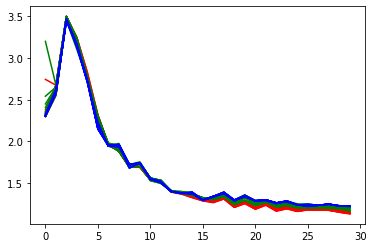

In [15]:
accshuffle = [[0.1, 0.1, 0.1143, 0.1642, 0.2082, 0.3013, 0.402, 0.4255, 0.4972, 0.4978, 0.5475, 0.5565, 0.5917, 0.5915, 0.6089, 0.6139, 0.6289, 0.617, 0.6512, 0.6355, 0.6593, 0.6522, 0.6702, 0.6659, 0.6789, 0.6783, 0.6826, 0.6826, 0.6865, 0.6912], [0.1, 0.1, 0.1118, 0.1603, 0.2102, 0.313, 0.403, 0.4262, 0.4984, 0.4988, 0.5485, 0.5569, 0.5917, 0.5915, 0.6115, 0.6146, 0.6283, 0.617, 0.6541, 0.636, 0.6582, 0.6522, 0.6688, 0.6662, 0.6789, 0.6777, 0.6821, 0.683, 0.6865, 0.6905], [0.1, 0.1, 0.1118, 0.1652, 0.2053, 0.3089, 0.4015, 0.4206, 0.497, 0.5019, 0.5485, 0.5569, 0.5918, 0.5917, 0.6115, 0.6146, 0.6289, 0.617, 0.6541, 0.636, 0.6582, 0.6526, 0.6718, 0.6641, 0.6785, 0.6786, 0.6793, 0.6815, 0.6851, 0.6917], [0.1, 0.1, 0.1161, 0.1631, 0.2023, 0.2988, 0.4038, 0.4265, 0.4994, 0.5027, 0.5487, 0.5568, 0.5934, 0.5914, 0.6144, 0.6157, 0.6317, 0.6199, 0.654, 0.639, 0.6617, 0.6505, 0.6721, 0.6634, 0.6781, 0.6751, 0.68, 0.6809, 0.6851, 0.6913], [0.1, 0.1, 0.1166, 0.1644, 0.2075, 0.3008, 0.403, 0.4276, 0.4973, 0.5035, 0.5487, 0.5569, 0.5926, 0.5899, 0.6162, 0.618, 0.6321, 0.6204, 0.6543, 0.6407, 0.6613, 0.6509, 0.673, 0.6624, 0.6777, 0.6762, 0.6789, 0.6809, 0.6846, 0.6919], [0.1, 0.1, 0.1147, 0.1636, 0.2063, 0.3012, 0.4029, 0.4276, 0.4988, 0.5031, 0.5492, 0.5565, 0.592, 0.5907, 0.6152, 0.6172, 0.6314, 0.6196, 0.654, 0.639, 0.66, 0.6517, 0.6715, 0.6635, 0.6768, 0.6783, 0.6793, 0.6815, 0.6851, 0.6917], [0.1, 0.1, 0.1116, 0.1652, 0.2077, 0.3089, 0.4, 0.4276, 0.4973, 0.5033, 0.5492, 0.5553, 0.593, 0.5907, 0.6152, 0.6172, 0.6309, 0.618, 0.6542, 0.6374, 0.6598, 0.6526, 0.6698, 0.6641, 0.6785, 0.6777, 0.6819, 0.681, 0.6851, 0.6917], [0.1, 0.1, 0.1147, 0.1651, 0.2053, 0.3015, 0.4, 0.4233, 0.497, 0.5031, 0.5496, 0.5565, 0.592, 0.5907, 0.6152, 0.6172, 0.6322, 0.6206, 0.6546, 0.6407, 0.6614, 0.6515, 0.6721, 0.6644, 0.6783, 0.677, 0.6795, 0.681, 0.6853, 0.6905], [0.1, 0.1, 0.1116, 0.1651, 0.2088, 0.3015, 0.3986, 0.4282, 0.497, 0.5019, 0.5485, 0.5569, 0.5919, 0.5907, 0.6144, 0.6157, 0.6317, 0.621, 0.6534, 0.6399, 0.6617, 0.6505, 0.6716, 0.6645, 0.6783, 0.6751, 0.68, 0.6809, 0.6851, 0.6917], [0.1, 0.1, 0.1147, 0.1631, 0.2023, 0.2987, 0.4038, 0.4265, 0.4989, 0.5011, 0.5478, 0.5575, 0.5926, 0.5919, 0.6144, 0.6178, 0.6316, 0.621, 0.6546, 0.6407, 0.6614, 0.6512, 0.6711, 0.6634, 0.6781, 0.6751, 0.68, 0.6809, 0.6849, 0.6915], [0.1, 0.1, 0.1128, 0.1624, 0.2062, 0.3251, 0.4031, 0.4176, 0.5, 0.5003, 0.5469, 0.5545, 0.5925, 0.5909, 0.6075, 0.6176, 0.6231, 0.6133, 0.6465, 0.6303, 0.6536, 0.653, 0.6676, 0.6656, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1152, 0.1628, 0.2065, 0.3063, 0.4029, 0.426, 0.497, 0.5019, 0.5485, 0.5565, 0.5917, 0.5915, 0.6089, 0.6151, 0.6289, 0.617, 0.6512, 0.6357, 0.6593, 0.6528, 0.6686, 0.6671, 0.6805, 0.6793, 0.6832, 0.6843, 0.6904, 0.695], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3215, 0.4098, 0.424, 0.4974, 0.4997, 0.5469, 0.5559, 0.5929, 0.5909, 0.6031, 0.6176, 0.6231, 0.6167, 0.6465, 0.6302, 0.6525, 0.6558, 0.6682, 0.6672, 0.678, 0.6801, 0.6842, 0.6834, 0.69, 0.695], [0.1, 0.1, 0.1143, 0.1652, 0.2065, 0.3129, 0.3998, 0.424, 0.4984, 0.4951, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6162, 0.6227, 0.6145, 0.6483, 0.6355, 0.656, 0.6525, 0.6686, 0.6671, 0.677, 0.6801, 0.6835, 0.6841, 0.692, 0.6962], [0.1, 0.1, 0.1116, 0.1666, 0.2053, 0.3013, 0.402, 0.4282, 0.4983, 0.4951, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6176, 0.6237, 0.6167, 0.6458, 0.6303, 0.6529, 0.6528, 0.6662, 0.6672, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6949], [0.1, 0.1, 0.1116, 0.1666, 0.2102, 0.313, 0.3993, 0.4233, 0.4974, 0.4997, 0.5491, 0.5562, 0.5914, 0.5906, 0.6031, 0.6176, 0.6237, 0.6167, 0.65, 0.6363, 0.6565, 0.6525, 0.6684, 0.6652, 0.6768, 0.6807, 0.6869, 0.6841, 0.6913, 0.6949], [0.1, 0.1, 0.1116, 0.1666, 0.2053, 0.3063, 0.3998, 0.4176, 0.4905, 0.5018, 0.5491, 0.5562, 0.5919, 0.588, 0.6042, 0.6187, 0.6219, 0.6167, 0.6458, 0.6303, 0.6536, 0.6528, 0.6662, 0.6643, 0.6762, 0.6807, 0.6869, 0.6841, 0.6907, 0.696], [0.1, 0.1, 0.1147, 0.1645, 0.2075, 0.3008, 0.403, 0.426, 0.497, 0.5019, 0.5485, 0.5542, 0.5924, 0.5886, 0.6056, 0.6139, 0.6279, 0.6172, 0.6508, 0.6355, 0.6593, 0.6518, 0.6683, 0.6673, 0.6786, 0.6793, 0.6832, 0.6845, 0.6899, 0.6957], [0.1, 0.1, 0.1143, 0.1601, 0.2055, 0.3206, 0.3998, 0.4176, 0.4905, 0.4964, 0.546, 0.5549, 0.5929, 0.5906, 0.6075, 0.6187, 0.6231, 0.6167, 0.6465, 0.6302, 0.6529, 0.6528, 0.6662, 0.6663, 0.6768, 0.6807, 0.6869, 0.6841, 0.6932, 0.6934], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3206, 0.4098, 0.4176, 0.4971, 0.4988, 0.5485, 0.5537, 0.5919, 0.588, 0.6056, 0.6139, 0.6279, 0.6172, 0.65, 0.6355, 0.656, 0.6525, 0.6684, 0.6653, 0.6774, 0.6793, 0.6838, 0.6831, 0.6899, 0.696], [0.1, 0.1, 0.1143, 0.161, 0.2055, 0.3088, 0.4098, 0.4101, 0.4905, 0.4986, 0.5458, 0.5549, 0.5919, 0.588, 0.6042, 0.6185, 0.6219, 0.6145, 0.6483, 0.6314, 0.6536, 0.653, 0.6662, 0.6671, 0.677, 0.6818, 0.6842, 0.6858, 0.6932, 0.6962], [0.1, 0.1, 0.117, 0.1642, 0.2088, 0.3013, 0.402, 0.4275, 0.4971, 0.4964, 0.5482, 0.5536, 0.5924, 0.5886, 0.6056, 0.6139, 0.6279, 0.6172, 0.6506, 0.6346, 0.6565, 0.6525, 0.6682, 0.6663, 0.677, 0.6795, 0.6846, 0.6858, 0.6932, 0.6958], [0.1, 0.1, 0.1126, 0.1607, 0.2055, 0.3097, 0.3998, 0.4176, 0.4905, 0.5018, 0.5456, 0.557, 0.5925, 0.5906, 0.6075, 0.6185, 0.6227, 0.6141, 0.6467, 0.6303, 0.6529, 0.6528, 0.6682, 0.6656, 0.6769, 0.6803, 0.6869, 0.6853, 0.69, 0.6934], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3101, 0.4018, 0.424, 0.4905, 0.4997, 0.5456, 0.5521, 0.5925, 0.5883, 0.6042, 0.6185, 0.6219, 0.6145, 0.65, 0.6363, 0.653, 0.6524, 0.6682, 0.6663, 0.6767, 0.6801, 0.6842, 0.6855, 0.692, 0.695], [0.1, 0.1, 0.1144, 0.161, 0.2065, 0.3206, 0.4073, 0.4249, 0.4974, 0.5007, 0.5482, 0.5521, 0.5914, 0.5906, 0.6056, 0.6139, 0.6279, 0.6172, 0.6506, 0.6346, 0.6565, 0.6525, 0.6684, 0.6652, 0.6767, 0.6814, 0.6873, 0.6841, 0.6941, 0.6934], [0.1, 0.1, 0.1144, 0.1607, 0.2065, 0.313, 0.4021, 0.4275, 0.4983, 0.4951, 0.546, 0.5521, 0.5925, 0.5906, 0.6048, 0.6187, 0.6219, 0.6173, 0.6458, 0.6303, 0.656, 0.6524, 0.6674, 0.6659, 0.678, 0.6795, 0.6842, 0.6855, 0.69, 0.6955], [0.1, 0.1, 0.1143, 0.1607, 0.2055, 0.3097, 0.4018, 0.424, 0.5007, 0.5007, 0.5456, 0.5549, 0.5925, 0.5906, 0.6048, 0.6176, 0.6219, 0.6173, 0.6483, 0.6303, 0.6545, 0.6558, 0.6682, 0.6659, 0.6768, 0.6814, 0.6873, 0.6853, 0.6937, 0.6955], [0.1, 0.1, 0.1116, 0.1642, 0.2088, 0.3064, 0.4018, 0.4233, 0.4974, 0.4997, 0.5456, 0.557, 0.5949, 0.5908, 0.6048, 0.6187, 0.6231, 0.6141, 0.6458, 0.6303, 0.6529, 0.6524, 0.6691, 0.6671, 0.6763, 0.6808, 0.6835, 0.6834, 0.6905, 0.6962], [0.1, 0.1, 0.1163, 0.1601, 0.2077, 0.3015, 0.4018, 0.4249, 0.5009, 0.5007, 0.5456, 0.5549, 0.591, 0.5908, 0.6048, 0.6187, 0.6231, 0.6173, 0.6467, 0.629, 0.6545, 0.6533, 0.6673, 0.6665, 0.6768, 0.6795, 0.6863, 0.6853, 0.6937, 0.6955], [0.1, 0.1, 0.1163, 0.1666, 0.2084, 0.3091, 0.4032, 0.424, 0.4924, 0.5014, 0.5508, 0.5575, 0.591, 0.5886, 0.6032, 0.6187, 0.6231, 0.6141, 0.6458, 0.6314, 0.6537, 0.6533, 0.6658, 0.6673, 0.678, 0.6801, 0.6835, 0.6845, 0.6899, 0.695], [0.1, 0.1, 0.1116, 0.1656, 0.2102, 0.3121, 0.3998, 0.4196, 0.4897, 0.5014, 0.5456, 0.557, 0.591, 0.5908, 0.6048, 0.6162, 0.6219, 0.6173, 0.6467, 0.629, 0.6537, 0.6533, 0.6658, 0.6665, 0.678, 0.6804, 0.6873, 0.6853, 0.6937, 0.6941], [0.1, 0.1, 0.1123, 0.1614, 0.2065, 0.3089, 0.402, 0.4275, 0.4971, 0.5019, 0.55, 0.5537, 0.5924, 0.5886, 0.6115, 0.6139, 0.6289, 0.6173, 0.6517, 0.6355, 0.6593, 0.6523, 0.6699, 0.6673, 0.6786, 0.678, 0.6834, 0.6843, 0.6891, 0.6957], [0.1, 0.1, 0.1143, 0.1607, 0.2057, 0.3091, 0.4034, 0.4196, 0.4924, 0.4978, 0.5482, 0.5521, 0.5919, 0.5883, 0.6062, 0.6139, 0.6279, 0.617, 0.6517, 0.6355, 0.6593, 0.6523, 0.6699, 0.6665, 0.678, 0.6784, 0.6835, 0.6849, 0.6883, 0.6937], [0.1, 0.1, 0.1143, 0.1603, 0.2124, 0.3091, 0.3998, 0.4122, 0.4897, 0.5014, 0.5508, 0.557, 0.591, 0.5893, 0.6031, 0.6162, 0.6231, 0.6141, 0.6483, 0.632, 0.6537, 0.6558, 0.6674, 0.6665, 0.678, 0.6804, 0.6869, 0.6859, 0.69, 0.6958], [0.1, 0.1, 0.1163, 0.1607, 0.2065, 0.3194, 0.4034, 0.4122, 0.4897, 0.4951, 0.5473, 0.5521, 0.5925, 0.5906, 0.6053, 0.6162, 0.6219, 0.6141, 0.6458, 0.6302, 0.6541, 0.6533, 0.6673, 0.6643, 0.6768, 0.6814, 0.6873, 0.6841, 0.6927, 0.6941], [0.1, 0.1, 0.1116, 0.1644, 0.2082, 0.3013, 0.402, 0.4233, 0.4971, 0.4983, 0.5482, 0.5544, 0.591, 0.5906, 0.6075, 0.6162, 0.6219, 0.6167, 0.6458, 0.6302, 0.6541, 0.6533, 0.6673, 0.6643, 0.6768, 0.6804, 0.6869, 0.6831, 0.6899, 0.6957], [0.1, 0.1, 0.1152, 0.1666, 0.2082, 0.3013, 0.3986, 0.4233, 0.4974, 0.4983, 0.5482, 0.5559, 0.593, 0.5906, 0.6053, 0.6187, 0.6231, 0.6123, 0.6458, 0.6314, 0.6536, 0.6533, 0.6658, 0.6643, 0.6768, 0.6814, 0.6867, 0.6841, 0.6937, 0.6958], [0.1, 0.1, 0.1137, 0.1607, 0.2057, 0.313, 0.4034, 0.4196, 0.4971, 0.4951, 0.5473, 0.5521, 0.5925, 0.5906, 0.6031, 0.6187, 0.6219, 0.6145, 0.6483, 0.6363, 0.653, 0.6558, 0.6658, 0.6643, 0.6767, 0.6814, 0.6867, 0.6834, 0.69, 0.6962], [0.1, 0.1, 0.1137, 0.1603, 0.2065, 0.3015, 0.4008, 0.4251, 0.4924, 0.4992, 0.5469, 0.5521, 0.5925, 0.5893, 0.6031, 0.6187, 0.6231, 0.6124, 0.6447, 0.6302, 0.6525, 0.6558, 0.6673, 0.6665, 0.6768, 0.6809, 0.6867, 0.6853, 0.6924, 0.6962], [0.1, 0.1, 0.1137, 0.1603, 0.2065, 0.3194, 0.4098, 0.4233, 0.4974, 0.4955, 0.5482, 0.5551, 0.5925, 0.5893, 0.6031, 0.6187, 0.6231, 0.6124, 0.6479, 0.6311, 0.654, 0.6519, 0.6691, 0.6652, 0.6767, 0.6795, 0.6867, 0.6846, 0.6932, 0.694], [0.1, 0.1, 0.1137, 0.1627, 0.2109, 0.3251, 0.4034, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6231, 0.6167, 0.6447, 0.6322, 0.654, 0.6519, 0.6676, 0.664, 0.678, 0.6795, 0.6867, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1137, 0.1603, 0.2057, 0.3194, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5559, 0.593, 0.5909, 0.6075, 0.6178, 0.6231, 0.6124, 0.6447, 0.6322, 0.6536, 0.653, 0.6676, 0.6672, 0.678, 0.6807, 0.6867, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3194, 0.4098, 0.4206, 0.4905, 0.4997, 0.5491, 0.5559, 0.593, 0.5909, 0.6031, 0.6187, 0.6231, 0.6124, 0.6447, 0.6322, 0.654, 0.6519, 0.6673, 0.6643, 0.678, 0.6807, 0.6869, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.313, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6075, 0.6187, 0.6231, 0.6141, 0.6458, 0.6322, 0.6536, 0.6519, 0.6658, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4905, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6231, 0.6124, 0.6458, 0.6322, 0.654, 0.653, 0.6676, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6955], [0.1, 0.1, 0.1137, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4996, 0.4997, 0.5491, 0.5551, 0.593, 0.5909, 0.6031, 0.6178, 0.6219, 0.6141, 0.6479, 0.6314, 0.6536, 0.6519, 0.6676, 0.6641, 0.678, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1139, 0.1627, 0.2077, 0.3251, 0.4034, 0.4206, 0.4905, 0.5003, 0.5482, 0.5545, 0.5914, 0.5906, 0.6075, 0.6162, 0.624, 0.6133, 0.6465, 0.6303, 0.6529, 0.6519, 0.6658, 0.6641, 0.678, 0.6807, 0.6867, 0.6846, 0.6937, 0.6934], [0.1, 0.1, 0.1139, 0.1607, 0.2077, 0.3194, 0.4098, 0.4122, 0.4996, 0.4997, 0.5482, 0.5551, 0.5941, 0.5906, 0.6031, 0.6178, 0.624, 0.6133, 0.6465, 0.6303, 0.6536, 0.6519, 0.6676, 0.6643, 0.678, 0.6807, 0.6867, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1143, 0.1627, 0.2077, 0.3251, 0.4098, 0.4122, 0.4905, 0.5003, 0.5491, 0.5551, 0.5941, 0.5909, 0.6075, 0.6178, 0.624, 0.6133, 0.6465, 0.6302, 0.6529, 0.6519, 0.6676, 0.6641, 0.6768, 0.6807, 0.6869, 0.6846, 0.6932, 0.6934], [0.1, 0.1, 0.1128, 0.1627, 0.2077, 0.3251, 0.4034, 0.4122, 0.4905, 0.5003, 0.5491, 0.5559, 0.5941, 0.5909, 0.6031, 0.6187, 0.6231, 0.6133, 0.6458, 0.6303, 0.6529, 0.6524, 0.6673, 0.6643, 0.678, 0.6805, 0.6869, 0.6846, 0.6932, 0.6934]]
lossshuffle = [[2.302586669921875, 2.552130482196808, 3.4729533123970033, 3.2414389276504516, 2.7709699368476866, 2.306362488269806, 1.9647595930099486, 1.8933792555332183, 1.697048671245575, 1.7317710900306702, 1.5511660444736481, 1.5155943089723587, 1.404426783323288, 1.3797707045078278, 1.3541198700666428, 1.3077057331800461, 1.3011579436063767, 1.3373360878229141, 1.2427619755268098, 1.292740559577942, 1.2263230800628662, 1.2527107322216033, 1.205464606285095, 1.229926666021347, 1.1918562573194504, 1.1939928847551347, 1.195872692465782, 1.195620698928833, 1.1832116222381592, 1.1636855655908585], [2.3075275111198423, 2.6438679003715517, 3.5023439526557922, 3.177270109653473, 2.737719612121582, 2.232659661769867, 1.9520419907569886, 1.8955491030216216, 1.6931398451328277, 1.7259604120254517, 1.5410828328132629, 1.5115718394517899, 1.404426783323288, 1.3797707045078278, 1.3481231927871704, 1.3065579152107238, 1.29880839407444, 1.3307577258348464, 1.2342171239852906, 1.2853971576690675, 1.2184755235910416, 1.2527107322216033, 1.1989732837677003, 1.2244733780622483, 1.1918562573194504, 1.19205016374588, 1.1890962129831315, 1.188557692170143, 1.1790587919950486, 1.1426731783151627], [2.302587058544159, 2.6438679003715517, 3.5023439526557922, 3.1991001033782958, 2.7702627396583557, 2.25997983455658, 1.957745646238327, 1.933597651720047, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5115718394517899, 1.3990898764133453, 1.374049745798111, 1.3481231927871704, 1.3065579152107238, 1.2948001205921174, 1.3307577258348464, 1.2342171239852906, 1.2853971576690675, 1.2184755235910416, 1.2495654493570327, 1.1889979708194733, 1.2133932733535766, 1.1812663191556931, 1.1889209336042403, 1.1879518413543702, 1.1865921026468278, 1.1685248452425003, 1.147725709080696], [2.3305732798576355, 2.6758850407600403, 3.500343005657196, 3.245230047702789, 2.826392774581909, 2.3224392175674438, 1.965462783575058, 1.8827664589881896, 1.6921020340919495, 1.6903079080581664, 1.540015777349472, 1.5120364201068879, 1.398958342075348, 1.3736294245719909, 1.3313883918523788, 1.2926079845428466, 1.2740235966444016, 1.3167740827798844, 1.2169540017843246, 1.2705491280555725, 1.1979192811250687, 1.2432794606685638, 1.16926427423954, 1.1956330847740173, 1.1615837228298187, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.1526659661531449, 1.134641744494438], [2.335748574733734, 2.6758850407600403, 3.4968648672103884, 3.2167298197746277, 2.7753422093391418, 2.3029297542572023, 1.9520419907569886, 1.8837871146202088, 1.6907727682590485, 1.6889723312854767, 1.540015777349472, 1.5102315986156463, 1.393014521598816, 1.3678319489955901, 1.3242650592327119, 1.2859063148498535, 1.2649694615602494, 1.3098175078630447, 1.2087257206439972, 1.2563499492406844, 1.1864617639780044, 1.2336379611492156, 1.163261079788208, 1.19118475317955, 1.1599277746677399, 1.1778128272294999, 1.1783358603715897, 1.1736491900682449, 1.1504293394088745, 1.130396614074707], [2.744264862537384, 2.6758850407600403, 3.4977765226364137, 3.2391914558410644, 2.7862229442596433, 2.305675950050354, 1.9646694695949554, 1.8837871146202088, 1.6901026809215545, 1.695512306690216, 1.5360819852352143, 1.5142690992355348, 1.4038281261920929, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.2809287405014038, 1.3228674411773682, 1.222843183875084, 1.2755136770009994, 1.2055258297920226, 1.2454188120365144, 1.183207637667656, 1.207615602016449, 1.178279821872711, 1.1868884110450744, 1.1879518413543702, 1.1865921026468278, 1.1685248452425003, 1.147725709080696], [2.308310627937317, 2.6007660675048827, 3.499389169216156, 3.1991001033782958, 2.762584354877472, 2.25997983455658, 1.9655590558052063, 1.8837871146202088, 1.6907727682590485, 1.6914602601528168, 1.5360819852352143, 1.5154405212402344, 1.3988326179981232, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.282814736366272, 1.3255106043815612, 1.2287578475475311, 1.2821507424116134, 1.2113389140367508, 1.2495654493570327, 1.194695091843605, 1.2133932733535766, 1.1812663191556931, 1.19205016374588, 1.188546040058136, 1.1860037475824357, 1.1685248452425003, 1.147725709080696], [2.3025877475738525, 2.557341284751892, 3.4681322884559633, 3.225234954357147, 2.7702627396583557, 2.2967079865932463, 1.9655590558052063, 1.9080431413650514, 1.6911639332771302, 1.695512306690216, 1.5373236072063445, 1.5142690992355348, 1.4038281261920929, 1.3765766525268555, 1.3330246496200562, 1.2980655997991561, 1.2778066104650498, 1.314759978055954, 1.210155219435692, 1.2559875571727752, 1.189251921772957, 1.2407058155536652, 1.16926427423954, 1.1981225323677063, 1.1649846476316452, 1.182499604821205, 1.1841095393896104, 1.1826216030120849, 1.1615116953849793, 1.1426731783151627], [2.379911117553711, 2.6640325474739073, 3.499389169216156, 3.225234954357147, 2.7560336780548096, 2.2967079865932463, 1.972073118686676, 1.8801599490642547, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5115718394517899, 1.4028764408826828, 1.3765766525268555, 1.3313883918523788, 1.2926079845428466, 1.2740235966444016, 1.3115139836072922, 1.2130004221200943, 1.2664763402938843, 1.1979192811250687, 1.2432794606685638, 1.1749184501171113, 1.1982055085897445, 1.1649846476316452, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.1526659661531449, 1.1347879493236541], [2.3025896453857424, 2.6758850407600403, 3.4977765226364137, 3.245230047702789, 2.826392774581909, 2.3138943803310394, 1.965462783575058, 1.8827664589881896, 1.692507438659668, 1.695265407562256, 1.5415069878101348, 1.5111049216985704, 1.393014521598816, 1.3682530677318574, 1.3274499702453613, 1.2908886295557023, 1.2703212791681289, 1.3115139836072922, 1.210155219435692, 1.2559875571727752, 1.189251921772957, 1.23906600356102, 1.1666525083780288, 1.1956330847740173, 1.1615837228298187, 1.182031473517418, 1.1778838390111923, 1.1751110923290253, 1.158007960319519, 1.136861275434494], [2.3025921845436095, 2.557341284751892, 3.464500517845154, 3.124824891090393, 2.728281252384186, 2.150837981700897, 1.95979576587677, 1.9372370743751526, 1.6831029236316681, 1.7379163908958435, 1.5577503752708435, 1.5248184794187545, 1.4044001257419587, 1.3806460630893707, 1.3733759796619416, 1.2968456268310546, 1.3407948970794679, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.2851874333620072, 1.2961604756116867, 1.262399678826332, 1.2755142837762832, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3025951528549196, 2.6438679003715517, 3.485606589317322, 3.1880682134628295, 2.7409523606300352, 2.285139867067337, 1.9646694695949554, 1.8915642261505128, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5155943089723587, 1.404426783323288, 1.3797707045078278, 1.3541198700666428, 1.3134387809038162, 1.3011579436063767, 1.3373360878229141, 1.2427619755268098, 1.2969856017827988, 1.2477466762065887, 1.2868246859312058, 1.2332966560125351, 1.2400374609231948, 1.2131482136249543, 1.2051480954885483, 1.2141085374355316, 1.2036272084712982, 1.19024483025074, 1.1664375656843184], [2.342620761394501, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.1727105736732484, 1.9439126169681549, 1.911664638519287, 1.7006540811061859, 1.7432200980186463, 1.5577503752708435, 1.5093494015932083, 1.3994915616512298, 1.3806460630893707, 1.3882309406995774, 1.2968456268310546, 1.3407948970794679, 1.371156365275383, 1.297810206413269, 1.3557912391424178, 1.2796762281656264, 1.291543498635292, 1.2569949460029601, 1.2712744522094725, 1.238722305893898, 1.219173977971077, 1.2312574934959413, 1.2364263069629668, 1.2260017067193985, 1.2072448456287384], [2.302600622177124, 2.557341284751892, 3.4729533123970033, 3.2086420607566835, 2.7409523606300352, 2.2282753670215607, 1.962945032119751, 1.911664638519287, 1.6975031352043153, 1.7399793207645415, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.309698121547699, 1.3293544179201127, 1.374674061536789, 1.280689309835434, 1.3275252240896225, 1.270133159160614, 1.284921641945839, 1.2332966560125351, 1.2510561776161193, 1.2305225318670272, 1.219173977971077, 1.232197139263153, 1.2312682688236236, 1.2111488193273545, 1.2046192914247513], [2.3512217593193054, 2.651919541358948, 3.499389169216156, 3.2203999948501587, 2.7702627396583557, 2.306362488269806, 1.9647595930099486, 1.8801599490642547, 1.692680915594101, 1.7399793207645415, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.2968456268310546, 1.3383821940422058, 1.371156365275383, 1.2916994911432267, 1.345832012295723, 1.288835735321045, 1.2996683877706527, 1.263412088751793, 1.2712744522094725, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.227612817287445], [2.542677204608917, 2.651919541358948, 3.499389169216156, 3.2203999948501587, 2.737719612121582, 2.232659661769867, 1.9658026707172394, 1.9080431413650514, 1.7006540811061859, 1.7432200980186463, 1.546645245552063, 1.5067053723335266, 1.4029998451471328, 1.3756726121902465, 1.3882309406995774, 1.2968456268310546, 1.3383821940422058, 1.371156365275383, 1.2683964312076568, 1.3298700219392776, 1.2583308827877044, 1.284921641945839, 1.2340412747859955, 1.2682794016599654, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.2275057965517044, 1.227612817287445], [2.3026084208488466, 2.557341284751892, 3.499389169216156, 3.2203999948501587, 2.7702627396583557, 2.285139867067337, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7327716898918153, 1.546645245552063, 1.5067053723335266, 1.4021743232011794, 1.3980198341608048, 1.3798463553190232, 1.2961744672060014, 1.3337578934431076, 1.371156365275383, 1.2916994911432267, 1.345832012295723, 1.2851874333620072, 1.2996683877706527, 1.263412088751793, 1.2835076969861985, 1.252085909843445, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.212453618645668, 1.1840929466485977], [2.3100679683685303, 2.6758850407600403, 3.4977765226364137, 3.2290517807006838, 2.7753422093391418, 2.3029297542572023, 1.9520419907569886, 1.8915642261505128, 1.6911639332771302, 1.6994093358516693, 1.5410828328132629, 1.5289407938718795, 1.4012486773729325, 1.3898992782831192, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3585397666692733, 1.2449103993177415, 1.292740559577942, 1.2406844520568847, 1.2759493291378021, 1.2154031956195832, 1.2345383882522583, 1.2036429995298386, 1.2051480954885483, 1.2141085374355316, 1.2135280257463454, 1.206000589132309, 1.170398817062378], [2.302617001533508, 2.562538070678711, 3.4729533123970033, 3.1651740002632143, 2.743682897090912, 2.1826910901069643, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7328628981113434, 1.5624996292591096, 1.5197126787900925, 1.3994915616512298, 1.3802936631441116, 1.3733759796619416, 1.2961744672060014, 1.3407948970794679, 1.371156365275383, 1.297810206413269, 1.3557912391424178, 1.288835735321045, 1.2996683877706527, 1.263412088751793, 1.2705945366621016, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.240816115140915, 1.2273502898216249, 1.2236660277843476], [2.3115528798103333, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.1826910901069643, 1.9439126169681549, 1.9372370743751526, 1.701652946472168, 1.7259604120254517, 1.5531380736827851, 1.5305290734767913, 1.4021743232011794, 1.3980198341608048, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3585397666692733, 1.2683964312076568, 1.3275252240896225, 1.270133159160614, 1.284921641945839, 1.2340412747859955, 1.2472953188419342, 1.2254944002628327, 1.2051480954885483, 1.2194637548923493, 1.2188398319482803, 1.206000589132309, 1.1840929466485977], [2.302632074356079, 2.5647903990745546, 3.4729533123970033, 3.1408115553855898, 2.743682897090912, 2.2536398458480833, 1.9439126169681549, 1.9763650059700013, 1.7223165726661682, 1.7557244300842285, 1.5589919734001159, 1.5197126787900925, 1.4021743232011794, 1.3980198341608048, 1.3798463553190232, 1.3064100247621537, 1.3337578934431076, 1.374674061536789, 1.280689309835434, 1.3443602257966996, 1.2851874333620072, 1.2961604756116867, 1.263412088751793, 1.2510561776161193, 1.2305225318670272, 1.2228186440467834, 1.2312574934959413, 1.2375455737113952, 1.2273502898216249, 1.2046192914247513], [3.2006966423988343, 2.6758850407600403, 3.498877820968628, 3.2414389276504516, 2.7560336780548096, 2.306362488269806, 1.9647595930099486, 1.8834899961948395, 1.701652946472168, 1.7328628981113434, 1.5561695611476898, 1.5177936643362044, 1.4012486773729325, 1.3898992782831192, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3472175669670106, 1.2534987485408784, 1.3228224086761475, 1.2583308827877044, 1.284921641945839, 1.2406503748893738, 1.2705945366621016, 1.2305225318670272, 1.2199810594320297, 1.2231684589385987, 1.2375455737113952, 1.2273502898216249, 1.207895161509514], [2.3131466579437254, 2.6142862749099733, 3.4589433121681212, 3.147702548503876, 2.743682897090912, 2.2583458614349365, 1.977278275489807, 1.9372370743751526, 1.7223165726661682, 1.7327716898918153, 1.5588042068481445, 1.4978421407938003, 1.4044001257419587, 1.3756726121902465, 1.3733759796619416, 1.3064100247621537, 1.3293544179201127, 1.3756103831529618, 1.2889063608646394, 1.345832012295723, 1.288835735321045, 1.2996683877706527, 1.2569949460029601, 1.2755142837762832, 1.2448687905073166, 1.249067295193672, 1.2335953605175018, 1.2414103829860688, 1.2260017067193985, 1.2236660277843476], [2.302648432254791, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.2501102674007414, 1.9540553975105286, 1.911664638519287, 1.7223165726661682, 1.7432200980186463, 1.5588042068481445, 1.5329364794492721, 1.4006835985183717, 1.3917348605394364, 1.3798463553190232, 1.3064100247621537, 1.3337578934431076, 1.374674061536789, 1.2683964312076568, 1.3298700219392776, 1.2828948444128037, 1.2878081792593001, 1.2569949460029601, 1.2705945366621016, 1.238724250793457, 1.219173977971077, 1.2312574934959413, 1.237719311118126, 1.2111488193273545, 1.2072448456287384], [2.302671353816986, 2.6142862749099733, 3.4535063695907593, 3.1408115553855898, 2.7409523606300352, 2.1826910901069643, 1.957605437040329, 1.905255388021469, 1.7006540811061859, 1.7322651720046998, 1.5561695611476898, 1.5329364794492721, 1.4029998451471328, 1.3756726121902465, 1.3732788240909577, 1.3245150297880173, 1.306728674173355, 1.3472175669670106, 1.2534987485408784, 1.3228224086761475, 1.2583308827877044, 1.284921641945839, 1.2340412747859955, 1.2587033414840698, 1.238724250793457, 1.2254757130146026, 1.2297479349374771, 1.239717652797699, 1.222591250538826, 1.2236660277843476], [2.3027071022987364, 2.5718435549736025, 3.4535063695907593, 3.147702548503876, 2.7409523606300352, 2.232659661769867, 1.9557599055767059, 1.8834899961948395, 1.692680915594101, 1.7399793207645415, 1.5624996292591096, 1.5329364794492721, 1.4006835985183717, 1.3756726121902465, 1.378655492067337, 1.2961744672060014, 1.3337578934431076, 1.3678605133295059, 1.2916994911432267, 1.345832012295723, 1.270133159160614, 1.2878081792593001, 1.2472918367385863, 1.277007726430893, 1.242658150792122, 1.2199810594320297, 1.2312574934959413, 1.237719311118126, 1.2260017067193985, 1.2188333719968796], [2.3152948665618895, 2.6284927701950074, 3.4729533123970033, 3.147702548503876, 2.743682897090912, 2.2583458614349365, 1.9540553975105286, 1.911664638519287, 1.680338715314865, 1.7322651720046998, 1.5588042068481445, 1.5197126787900925, 1.4006835985183717, 1.3756726121902465, 1.378655492067337, 1.2968456268310546, 1.3337578934431076, 1.3678605133295059, 1.280689309835434, 1.351912675499916, 1.2894033551216126, 1.291543498635292, 1.2569949460029601, 1.277007726430893, 1.2376591795682907, 1.2254757130146026, 1.2297479349374771, 1.2431820911169051, 1.2238343894481658, 1.2188333719968796], [2.4073319244384765, 2.651919541358948, 3.499389169216156, 3.2414389276504516, 2.7560336780548096, 2.2718910086154938, 1.9540553975105286, 1.9080431413650514, 1.7006540811061859, 1.7432200980186463, 1.5588042068481445, 1.4978421407938003, 1.3934760361909866, 1.376544730067253, 1.378655492067337, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.351912675499916, 1.288835735321045, 1.281854711174965, 1.2332598692178727, 1.2510561776161193, 1.2313321888446809, 1.2173432391881942, 1.232197139263153, 1.2364263069629668, 1.2056762439012527, 1.2046192914247513], [2.3027437353134155, 2.6142862749099733, 3.4748205161094665, 3.1651740002632143, 2.762584354877472, 2.2967079865932463, 1.9540553975105286, 1.905255388021469, 1.6870718824863433, 1.7322651720046998, 1.5588042068481445, 1.5197126787900925, 1.4083802020549774, 1.376544730067253, 1.378655492067337, 1.2961744672060014, 1.3407948970794679, 1.3678605133295059, 1.2889063608646394, 1.3503990137577058, 1.2894033551216126, 1.2964132368564605, 1.2533205604553224, 1.2714147013425827, 1.2376591795682907, 1.2199810594320297, 1.2248683786392212, 1.2414103829860688, 1.2238343894481658, 1.2188333719968796], [2.3174498105049133, 2.6363672542572023, 3.4748205161094665, 3.2203999948501587, 2.7483539986610412, 2.2586568748950957, 1.9743555176258087, 1.911664638519287, 1.7024928116798401, 1.7349306535720825, 1.5292100894451142, 1.4969947785139084, 1.4083802020549774, 1.3840631824731826, 1.3852653521299363, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.3443602257966996, 1.2833589726686478, 1.2964132368564605, 1.2603388476371764, 1.2760662585496902, 1.242658150792122, 1.219173977971077, 1.232197139263153, 1.2135280257463454, 1.206000589132309, 1.1664375656843184], [2.3027876901626585, 2.6363672542572023, 3.499389169216156, 3.1774135851860046, 2.737719612121582, 2.234567166566849, 1.977278275489807, 1.9260036969184875, 1.7219166135787964, 1.7349306535720825, 1.5588042068481445, 1.4978421407938003, 1.4083802020549774, 1.376544730067253, 1.378655492067337, 1.3009759086370467, 1.3337578934431076, 1.3678605133295059, 1.2889063608646394, 1.3503990137577058, 1.2833589726686478, 1.2964132368564605, 1.2603388476371764, 1.2714147013425827, 1.242658150792122, 1.2339168524742126, 1.2297479349374771, 1.2431820911169051, 1.2238343894481658, 1.2246351099014283], [2.3028463435173037, 2.5780766081809996, 3.448925633430481, 3.1008597683906554, 2.7409523606300352, 2.25997983455658, 1.9647595930099486, 1.8834899961948395, 1.701652946472168, 1.6994093358516693, 1.5378476393222809, 1.5305290734767913, 1.4012486773729325, 1.3898992782831192, 1.3481231927871704, 1.3077057331800461, 1.3011579436063767, 1.3348410773277282, 1.241990663409233, 1.292740559577942, 1.2263230800628662, 1.2675216317176818, 1.2124020785093308, 1.2345383882522583, 1.2036429995298386, 1.2016195499897002, 1.2026517897844315, 1.2036272084712982, 1.1982196003198624, 1.170398817062378], [2.3029181122779847, 2.6363672542572023, 3.4729533123970033, 3.147702548503876, 2.7437607645988464, 2.2586568748950957, 1.9577132892608642, 1.9260036969184875, 1.7024928116798401, 1.7321773064136505, 1.5561695611476898, 1.5329364794492721, 1.4021743232011794, 1.3917348605394364, 1.3647652173042297, 1.3245150297880173, 1.306728674173355, 1.3373360878229141, 1.241990663409233, 1.292740559577942, 1.2406844520568847, 1.2675216317176818, 1.2124020785093308, 1.2298021912574768, 1.1987410068511963, 1.1996943563222886, 1.201117109656334, 1.1965372085571289, 1.1917253601551057, 1.1656107163429261], [2.302999851703644, 2.6363672542572023, 3.4729533123970033, 3.177270109653473, 2.724338095188141, 2.2586568748950957, 1.977278275489807, 1.9623688495159148, 1.7219166135787964, 1.7349306535720825, 1.5292100894451142, 1.4978421407938003, 1.4083802020549774, 1.3849457824230194, 1.3882309406995774, 1.3009759086370467, 1.3407948970794679, 1.3756103831529618, 1.280689309835434, 1.3406588178873062, 1.2833589726686478, 1.291543498635292, 1.2472918367385863, 1.2714147013425827, 1.242658150792122, 1.2339168524742126, 1.234664769768715, 1.2471722769737243, 1.2260017067193985, 1.207895161509514], [2.3030930757522583, 2.5780766081809996, 3.4748205161094665, 3.147702548503876, 2.7409523606300352, 2.1899530136585237, 1.9577132892608642, 1.9623688495159148, 1.7219166135787964, 1.7399793207645415, 1.555640596151352, 1.5329364794492721, 1.4006835985183717, 1.3756726121902465, 1.3790653359889984, 1.3009759086370467, 1.3337578934431076, 1.3756103831529618, 1.2916994911432267, 1.3557912391424178, 1.2856393903493881, 1.2964132368564605, 1.2533205604553224, 1.2835076969861985, 1.2376591795682907, 1.2254757130146026, 1.2297479349374771, 1.240816115140915, 1.2296903669834136, 1.2246351099014283], [2.4501484203338624, 2.651919541358948, 3.499389169216156, 3.2167298197746277, 2.7709699368476866, 2.306362488269806, 1.9647595930099486, 1.9080431413650514, 1.701652946472168, 1.7406095790863036, 1.5561695611476898, 1.5069543558359146, 1.4083802020549774, 1.3756726121902465, 1.3733759796619416, 1.3009759086370467, 1.3337578934431076, 1.371156365275383, 1.2916994911432267, 1.3557912391424178, 1.2856393903493881, 1.2964132368564605, 1.2533205604553224, 1.2835076969861985, 1.2376591795682907, 1.2339168524742126, 1.234664769768715, 1.2188398319482803, 1.206000589132309, 1.170398817062378], [2.363085036277771, 2.6438679003715517, 3.485606589317322, 3.2203999948501587, 2.7709699368476866, 2.306362488269806, 1.972073118686676, 1.9080431413650514, 1.7006540811061859, 1.7406095790863036, 1.5561695611476898, 1.5093494015932083, 1.3988107234239577, 1.3756726121902465, 1.3790653359889984, 1.2961744672060014, 1.3407948970794679, 1.3883282297849655, 1.2916994911432267, 1.3443602257966996, 1.2851874333620072, 1.2964132368564605, 1.2603388476371764, 1.2835076969861985, 1.2376591795682907, 1.2254757130146026, 1.2348465329408647, 1.240816115140915, 1.2238343894481658, 1.207895161509514], [2.3032264614105227, 2.5780766081809996, 3.4646975350379945, 3.147702548503876, 2.7437607645988464, 2.232659661769867, 1.9577132892608642, 1.9260036969184875, 1.701652946472168, 1.7399793207645415, 1.5603646564483642, 1.5329364794492721, 1.4044001257419587, 1.3756726121902465, 1.3882309406995774, 1.2961744672060014, 1.3337578934431076, 1.374674061536789, 1.280689309835434, 1.3298700219392776, 1.2828948444128037, 1.291543498635292, 1.2603388476371764, 1.2835076969861985, 1.238724250793457, 1.2254757130146026, 1.2348465329408647, 1.2364263069629668, 1.2260017067193985, 1.2046192914247513], [2.3033593988418577, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7409523606300352, 2.2967079865932463, 1.964482340812683, 1.9141951489448548, 1.7024928116798401, 1.7426748526096345, 1.5577503752708435, 1.5329364794492721, 1.4006835985183717, 1.3849457824230194, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3557912391424178, 1.2796762281656264, 1.291543498635292, 1.2533205604553224, 1.2714147013425827, 1.2376591795682907, 1.2291911512613296, 1.2348465329408647, 1.2431820911169051, 1.2151476752758026, 1.2046192914247513], [2.3035509634017943, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7409523606300352, 2.1899530136585237, 1.9439126169681549, 1.9080431413650514, 1.7006540811061859, 1.7371064519882202, 1.5561695611476898, 1.506690480709076, 1.4006835985183717, 1.3849457824230194, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2840228736400605, 1.3509084659814834, 1.2877459758520127, 1.2996598052978516, 1.2332598692178727, 1.2682794016599654, 1.238724250793457, 1.2199810594320297, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2256556308269502], [2.30376042842865, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.703319902420044, 2.150837981700897, 1.9577132892608642, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3407948970794679, 1.371156365275383, 1.2946320348978042, 1.3391518247127534, 1.2877459758520127, 1.2996598052978516, 1.262399678826332, 1.2885348814725877, 1.238722305893898, 1.2199810594320297, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3039912033081054, 2.5780766081809996, 3.4646975350379945, 3.177270109653473, 2.7437607645988464, 2.1899530136585237, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.5093494015932083, 1.3988107234239577, 1.3806460630893707, 1.3733759796619416, 1.292024198770523, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3391518247127534, 1.2851874333620072, 1.2961604756116867, 1.262399678826332, 1.2712744522094725, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.3042902898788453, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.1899530136585237, 1.9439126169681549, 1.933597651720047, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.5093494015932083, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3888658303022385, 1.2946320348978042, 1.3391518247127534, 1.2877459758520127, 1.2996598052978516, 1.2533205604553224, 1.2835076969861985, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.304603788852692, 2.5780766081809996, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.232659661769867, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3733759796619416, 1.2961744672060014, 1.3407948970794679, 1.3756103831529618, 1.2916994911432267, 1.3391518247127534, 1.2851874333620072, 1.2996598052978516, 1.2603388476371764, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3049919509887697, 2.6208685994148255, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3407948970794679, 1.3888658303022385, 1.2916994911432267, 1.3391518247127534, 1.2877459758520127, 1.2961604756116867, 1.262399678826332, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2188333719968796], [2.32188383102417, 2.6208685994148255, 3.4646975350379945, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.681040245294571, 1.7432200980186463, 1.546645245552063, 1.506690480709076, 1.3988107234239577, 1.3806460630893707, 1.3882309406995774, 1.292024198770523, 1.3337578934431076, 1.3756103831529618, 1.2840228736400605, 1.3443602257966996, 1.2851874333620072, 1.2996598052978516, 1.262399678826332, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.305458323955536, 2.5839535450935363, 3.449414224624634, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9577132892608642, 1.933597651720047, 1.7223165726661682, 1.7379163908958435, 1.5561695611476898, 1.5248184794187545, 1.4029998451471328, 1.3756726121902465, 1.3733759796619416, 1.3009759086370467, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.288835735321045, 1.2996598052978516, 1.2603388476371764, 1.284162369966507, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2238343894481658, 1.2236660277843476], [2.3059693217277526, 2.5839535450935363, 3.449414224624634, 3.147702548503876, 2.715602433681488, 2.1899530136585237, 1.9439126169681549, 1.9623688495159148, 1.681040245294571, 1.7432200980186463, 1.5561695611476898, 1.506690480709076, 1.3953058022260665, 1.3756726121902465, 1.3882309406995774, 1.292024198770523, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.345832012295723, 1.2851874333620072, 1.2996598052978516, 1.262399678826332, 1.2835076969861985, 1.238722305893898, 1.2287052017450333, 1.2348465329408647, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3260886740684508, 2.6208685994148255, 3.4729533123970033, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9439126169681549, 1.9623688495159148, 1.7223165726661682, 1.7379163908958435, 1.546645245552063, 1.506690480709076, 1.3953058022260665, 1.3806460630893707, 1.3733759796619416, 1.292024198770523, 1.3338907325267793, 1.3908909463882446, 1.297810206413269, 1.3557912391424178, 1.288835735321045, 1.2996598052978516, 1.262399678826332, 1.284162369966507, 1.2376591795682907, 1.2287052017450333, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476], [2.3065733313560486, 2.589086499214172, 3.464500517845154, 3.138776595592499, 2.715602433681488, 2.150837981700897, 1.9577132892608642, 1.9623688495159148, 1.7223165726661682, 1.7379163908958435, 1.546645245552063, 1.5093494015932083, 1.3953058022260665, 1.3806460630893707, 1.3882309406995774, 1.2961744672060014, 1.3407948970794679, 1.3908909463882446, 1.2916994911432267, 1.345832012295723, 1.288835735321045, 1.2878081792593001, 1.2533205604553224, 1.2835076969861985, 1.238722305893898, 1.2471371603012085, 1.2335953605175018, 1.2472148263454437, 1.2273502898216249, 1.2236660277843476]]

import matplotlib.pyplot as plt

x = [i for i in range(400)]


count = 0

for j in lossshuffle:
    # print(len(j))
    if count< 10:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'red')
    elif count >= 10 and count<40:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'green')
    else:
        plt.plot(x[0:30], j[0:30],label=str(count),color = 'blue')
    # plt.legend(loc = 'lower right')
    count += 1
    
count = 0